<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/from_crash/main_cot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 789, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 789 (delta 55), reused 55 (delta 26), pack-reused 692 (from 1)
Receiving objects: 100% (789/789), 5.87 MiB | 10.24 MiB/s, done.
Resolving deltas: 100% (510/510), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import DiceLossWSigmoid, DiceLossWSoftmax, DiceMetric
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.29% complete (down: 17035.5 kB/s up: 511.6 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[1

## Load data

In [7]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [9]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 1, 128, 128, 128])


## Visual data

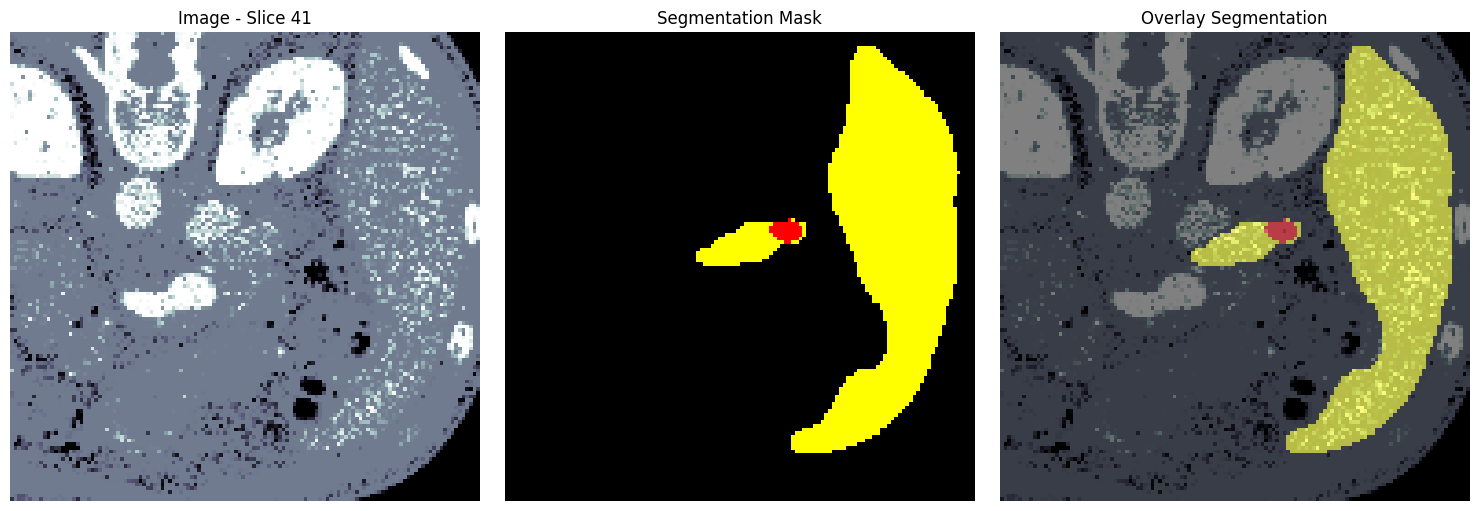

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 1, 128, 128, 128]

    label_data = label_sample[0, 0].numpy()  # shape: [128, 128, 128]
    image_data = image_sample[0, 0].numpy()

    # Tìm tất cả slice index có tumor
    tumor_slices = np.any(label_data == 2, axis=(1, 2))


    slice_idx = np.argmax(tumor_slices)

    img_slice = image_data[slice_idx, :, :]
    label_slice = label_data[slice_idx, :, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break


## Model

In [15]:
model = ModelFactory.get_model("unet3d_cot",in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 1704867


## Training

In [16]:
criterion = DiceLossWSoftmax().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [17]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    dices_tumor,
    dices_avg,
    loss_epochs,
    trains_epoch,
    ious_liver,
    ious_tumor,
    ious_avg,
    precisions_liver,
    precisions_tumor,
    precisions_avg,
    recalls_liver,
    recalls_tumor,
    recalls_avg,
    time_tmp,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8717 time 5.53s
Epoch 1/100 2/105 loss: 0.8531 time 2.60s
Epoch 1/100 3/105 loss: 0.8401 time 1.28s
Epoch 1/100 4/105 loss: 0.8308 time 5.09s
Epoch 1/100 5/105 loss: 0.8220 time 1.37s
Epoch 1/100 6/105 loss: 0.8153 time 6.56s
Epoch 1/100 7/105 loss: 0.8132 time 1.47s
Epoch 1/100 8/105 loss: 0.8107 time 1.53s
Epoch 1/100 9/105 loss: 0.8064 time 0.87s
Epoch 1/100 10/105 loss: 0.7996 time 4.62s
Epoch 1/100 11/105 loss: 0.7954 time 3.63s
Epoch 1/100 12/105 loss: 0.7906 time 2.19s
Epoch 1/100 13/105 loss: 0.7872 time 1.27s
Epoch 1/100 14/105 loss: 0.7835 time 3.30s
Epoch 1/100 15/105 loss: 0.7786 time 6.25s
Epoch 1/100 16/105 loss: 0.7760 time 5.34s
Epoch 1/100 17/105 loss: 0.7724 time 2.18s
Epoch 1/100 18/105 loss: 0.7692 time 1.05s
Epoch 1/100 19/105 loss: 0.7655 time 5.04s
Epoch 1/100 20/105 loss: 0.7625 time 3.12s
Epoch 1/100 21/105 loss: 0.7588 time 1.63s
Epoch 1/100 22/105 loss: 0.7553 time 3.98s
Epoch 1/100 23/105 loss: 0.7511 time 4.22s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.5871] ---[time 380.87s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.5871] ---[time 380.87s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.5871 time 4.92s


Val 1/100 1/26, Dice_Liver: 0.817892, Dice_Tumor: 0.000000, Dice_Avg: 0.408946, time 3.68s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.817892, Dice_Tumor: 0.000000, Dice_Avg: 0.408946, time 3.68s
Val 1/100 2/26, Dice_Liver: 0.842008, Dice_Tumor: 0.000000, Dice_Avg: 0.421004, time 2.86s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.842008, Dice_Tumor: 0.000000, Dice_Avg: 0.421004, time 2.86s
Val 1/100 3/26, Dice_Liver: 0.833658, Dice_Tumor: 0.000000, Dice_Avg: 0.416829, time 1.82s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.833658, Dice_Tumor: 0.000000, Dice_Avg: 0.416829, time 1.82s
Val 1/100 4/26, Dice_Liver: 0.815379, Dice_Tumor: 0.000000, Dice_Avg: 0.407690, time 6.77s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.815379, Dice_Tumor: 0.000000, Dice_Avg: 0.407690, time 6.77s
Val 1/100 5/26, Dice_Liver: 0.806112, Dice_Tumor: 0.000000, Dice_Avg: 0.403056, time 1.19s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.806112, Dice_Tumor: 0.000000, Dice_A

New best (0.000000 --> 0.378463). At epoch 1


Epoch 1/100 ---[loss: 0.5871] ---[val_dice: 0.378463] ---[time 97.22s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.5871] ---[val_dice: 0.378463] ---[time 97.22s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.4848 time 1.73s
Epoch 2/100 2/105 loss: 0.4757 time 5.32s
Epoch 2/100 3/105 loss: 0.4724 time 6.58s
Epoch 2/100 4/105 loss: 0.4725 time 4.70s
Epoch 2/100 5/105 loss: 0.4732 time 4.69s
Epoch 2/100 6/105 loss: 0.4722 time 2.96s
Epoch 2/100 7/105 loss: 0.4687 time 5.44s
Epoch 2/100 8/105 loss: 0.4686 time 5.10s
Epoch 2/100 9/105 loss: 0.4682 time 1.10s
Epoch 2/100 10/105 loss: 0.4667 time 4.91s
Epoch 2/100 11/105 loss: 0.4664 time 4.55s
Epoch 2/100 12/105 loss: 0.4656 time 5.32s
Epoch 2/100 13/105 loss: 0.4653 time 1.14s
Epoch 2/100 14/105 loss: 0.4656 time 5.12s
Epoch 2/100 15/105 loss: 0.4650 time 2.81s
Epoch 2/100 16/105 loss: 0.4640 time 4.19s
Epoch 2/100 17/105 loss: 0.4630 time 1.04s
Epoch 2/100 18/105 loss: 0.4637 time 2.56s
Epoch 2/100 19/105 loss: 0.4649 time 4.89s
Epoch 2/100 20/105 loss: 0.4645 time 1.17s
Epoch 2/100 21/105 loss: 0.4641 time 6.09s
Epoch 2/100 22/105 loss: 0.4639 time 0.89s
Epoch 2/100 23/105 loss: 0.4641 time 1.21s
Epoch 2/100 24/105 l

Final training epochs: 2/100 ---[loss: 0.4394] ---[time 370.74s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.4394] ---[time 370.74s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.4394 time 1.21s


Val 2/100 1/26, Dice_Liver: 0.747965, Dice_Tumor: 0.000000, Dice_Avg: 0.373982, time 1.13s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.747965, Dice_Tumor: 0.000000, Dice_Avg: 0.373982, time 1.13s
Val 2/100 2/26, Dice_Liver: 0.733022, Dice_Tumor: 0.000000, Dice_Avg: 0.366511, time 5.06s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.733022, Dice_Tumor: 0.000000, Dice_Avg: 0.366511, time 5.06s
Val 2/100 3/26, Dice_Liver: 0.744397, Dice_Tumor: 0.000000, Dice_Avg: 0.372198, time 1.38s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.744397, Dice_Tumor: 0.000000, Dice_Avg: 0.372198, time 1.38s
Val 2/100 4/26, Dice_Liver: 0.710947, Dice_Tumor: 0.000000, Dice_Avg: 0.355473, time 7.48s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.710947, Dice_Tumor: 0.000000, Dice_Avg: 0.355473, time 7.48s
Val 2/100 5/26, Dice_Liver: 0.706886, Dice_Tumor: 0.000000, Dice_Avg: 0.353443, time 1.23s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.706886, Dice_Tumor: 0.000000, Dice_A

Epoch 3/100 1/105 loss: 0.4032 time 4.99s
Epoch 3/100 2/105 loss: 0.4156 time 4.87s
Epoch 3/100 3/105 loss: 0.4146 time 1.73s
Epoch 3/100 4/105 loss: 0.4139 time 4.07s
Epoch 3/100 5/105 loss: 0.4149 time 5.60s
Epoch 3/100 6/105 loss: 0.4163 time 4.59s
Epoch 3/100 7/105 loss: 0.4149 time 1.34s
Epoch 3/100 8/105 loss: 0.4149 time 1.09s
Epoch 3/100 9/105 loss: 0.4141 time 2.36s
Epoch 3/100 10/105 loss: 0.4132 time 8.57s
Epoch 3/100 11/105 loss: 0.4118 time 1.52s
Epoch 3/100 12/105 loss: 0.4119 time 6.04s
Epoch 3/100 13/105 loss: 0.4094 time 6.63s
Epoch 3/100 14/105 loss: 0.4081 time 4.26s
Epoch 3/100 15/105 loss: 0.4074 time 2.70s
Epoch 3/100 16/105 loss: 0.4072 time 5.45s
Epoch 3/100 17/105 loss: 0.4064 time 5.02s
Epoch 3/100 18/105 loss: 0.4069 time 1.16s
Epoch 3/100 19/105 loss: 0.4069 time 0.90s
Epoch 3/100 20/105 loss: 0.4070 time 5.64s
Epoch 3/100 21/105 loss: 0.4076 time 4.23s
Epoch 3/100 22/105 loss: 0.4069 time 0.95s
Epoch 3/100 23/105 loss: 0.4062 time 3.91s
Epoch 3/100 24/105 l

Final training epochs: 3/100 ---[loss: 0.3996] ---[time 366.80s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.3996] ---[time 366.80s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.3996 time 0.89s


Val 3/100 1/26, Dice_Liver: 0.880542, Dice_Tumor: 0.000000, Dice_Avg: 0.440271, time 1.20s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.880542, Dice_Tumor: 0.000000, Dice_Avg: 0.440271, time 1.20s
Val 3/100 2/26, Dice_Liver: 0.881261, Dice_Tumor: 0.000000, Dice_Avg: 0.440630, time 5.08s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.881261, Dice_Tumor: 0.000000, Dice_Avg: 0.440630, time 5.08s
Val 3/100 3/26, Dice_Liver: 0.883569, Dice_Tumor: 0.000000, Dice_Avg: 0.441784, time 1.43s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.883569, Dice_Tumor: 0.000000, Dice_Avg: 0.441784, time 1.43s
Val 3/100 4/26, Dice_Liver: 0.856278, Dice_Tumor: 0.000000, Dice_Avg: 0.428139, time 7.54s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.856278, Dice_Tumor: 0.000000, Dice_Avg: 0.428139, time 7.54s
Val 3/100 5/26, Dice_Liver: 0.854948, Dice_Tumor: 0.000000, Dice_Avg: 0.427474, time 1.24s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.854948, Dice_Tumor: 0.000000, Dice_A

New best (0.378463 --> 0.420766). At epoch 3
Epoch 4/100 1/105 loss: 0.3834 time 6.07s
Epoch 4/100 2/105 loss: 0.3925 time 1.07s
Epoch 4/100 3/105 loss: 0.3883 time 1.23s
Epoch 4/100 4/105 loss: 0.3900 time 7.37s
Epoch 4/100 5/105 loss: 0.3885 time 5.72s
Epoch 4/100 6/105 loss: 0.3858 time 6.45s
Epoch 4/100 7/105 loss: 0.3891 time 4.66s
Epoch 4/100 8/105 loss: 0.3890 time 3.80s
Epoch 4/100 9/105 loss: 0.3891 time 3.80s
Epoch 4/100 10/105 loss: 0.3882 time 0.92s
Epoch 4/100 11/105 loss: 0.3865 time 4.27s
Epoch 4/100 12/105 loss: 0.3864 time 4.93s
Epoch 4/100 13/105 loss: 0.3866 time 5.43s
Epoch 4/100 14/105 loss: 0.3858 time 2.16s
Epoch 4/100 15/105 loss: 0.3849 time 1.52s
Epoch 4/100 16/105 loss: 0.3852 time 4.12s
Epoch 4/100 17/105 loss: 0.3850 time 5.59s
Epoch 4/100 18/105 loss: 0.3843 time 5.45s
Epoch 4/100 19/105 loss: 0.3851 time 0.90s
Epoch 4/100 20/105 loss: 0.3862 time 9.93s
Epoch 4/100 21/105 loss: 0.3861 time 2.87s
Epoch 4/100 22/105 loss: 0.3880 time 0.88s
Epoch 4/100 23/105

Final training epochs: 4/100 ---[loss: 0.3928] ---[time 373.78s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.3928] ---[time 373.78s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.3928 time 4.02s


Val 4/100 1/26, Dice_Liver: 0.851124, Dice_Tumor: 0.000000, Dice_Avg: 0.425562, time 1.00s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.851124, Dice_Tumor: 0.000000, Dice_Avg: 0.425562, time 1.00s
Val 4/100 2/26, Dice_Liver: 0.833837, Dice_Tumor: 0.000000, Dice_Avg: 0.416919, time 5.07s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.833837, Dice_Tumor: 0.000000, Dice_Avg: 0.416919, time 5.07s
Val 4/100 3/26, Dice_Liver: 0.842876, Dice_Tumor: 0.000000, Dice_Avg: 0.421438, time 1.50s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.842876, Dice_Tumor: 0.000000, Dice_Avg: 0.421438, time 1.50s
Val 4/100 4/26, Dice_Liver: 0.823697, Dice_Tumor: 0.000000, Dice_Avg: 0.411849, time 6.96s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.823697, Dice_Tumor: 0.000000, Dice_Avg: 0.411849, time 6.96s
Val 4/100 5/26, Dice_Liver: 0.817908, Dice_Tumor: 0.000000, Dice_Avg: 0.408954, time 1.14s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.817908, Dice_Tumor: 0.000000, Dice_A

Epoch 5/100 1/105 loss: 0.3828 time 8.19s
Epoch 5/100 2/105 loss: 0.3889 time 4.58s
Epoch 5/100 3/105 loss: 0.3851 time 1.16s
Epoch 5/100 4/105 loss: 0.3886 time 4.72s
Epoch 5/100 5/105 loss: 0.3861 time 1.05s
Epoch 5/100 6/105 loss: 0.3885 time 3.24s
Epoch 5/100 7/105 loss: 0.3874 time 4.89s
Epoch 5/100 8/105 loss: 0.3899 time 0.90s
Epoch 5/100 9/105 loss: 0.3892 time 4.56s
Epoch 5/100 10/105 loss: 0.3881 time 5.89s
Epoch 5/100 11/105 loss: 0.3906 time 4.54s
Epoch 5/100 12/105 loss: 0.3909 time 1.19s
Epoch 5/100 13/105 loss: 0.3922 time 1.09s
Epoch 5/100 14/105 loss: 0.3933 time 3.37s
Epoch 5/100 15/105 loss: 0.3916 time 4.42s
Epoch 5/100 16/105 loss: 0.3918 time 5.75s
Epoch 5/100 17/105 loss: 0.3911 time 7.05s
Epoch 5/100 18/105 loss: 0.3909 time 5.08s
Epoch 5/100 19/105 loss: 0.3902 time 2.49s
Epoch 5/100 20/105 loss: 0.3895 time 5.22s
Epoch 5/100 21/105 loss: 0.3895 time 1.69s
Epoch 5/100 22/105 loss: 0.3888 time 6.23s
Epoch 5/100 23/105 loss: 0.3881 time 3.77s
Epoch 5/100 24/105 l

Final training epochs: 5/100 ---[loss: 0.3823] ---[time 369.19s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.3823] ---[time 369.19s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.3823 time 0.88s


Val 5/100 1/26, Dice_Liver: 0.901245, Dice_Tumor: 0.000000, Dice_Avg: 0.450623, time 0.90s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.901245, Dice_Tumor: 0.000000, Dice_Avg: 0.450623, time 0.90s
Val 5/100 2/26, Dice_Liver: 0.878837, Dice_Tumor: 0.041847, Dice_Avg: 0.460342, time 4.68s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.878837, Dice_Tumor: 0.041847, Dice_Avg: 0.460342, time 4.68s
Val 5/100 3/26, Dice_Liver: 0.876822, Dice_Tumor: 0.137652, Dice_Avg: 0.507237, time 1.46s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.876822, Dice_Tumor: 0.137652, Dice_Avg: 0.507237, time 1.46s
Val 5/100 4/26, Dice_Liver: 0.864057, Dice_Tumor: 0.107797, Dice_Avg: 0.485927, time 6.93s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.864057, Dice_Tumor: 0.107797, Dice_Avg: 0.485927, time 6.93s
Val 5/100 5/26, Dice_Liver: 0.856390, Dice_Tumor: 0.086238, Dice_Avg: 0.471314, time 1.27s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.856390, Dice_Tumor: 0.086238, Dice_A

New best (0.420766 --> 0.437110). At epoch 5
Epoch 6/100 1/105 loss: 0.3696 time 2.05s
Epoch 6/100 2/105 loss: 0.3622 time 0.99s
Epoch 6/100 3/105 loss: 0.3650 time 6.24s
Epoch 6/100 4/105 loss: 0.3649 time 0.89s
Epoch 6/100 5/105 loss: 0.3585 time 4.01s
Epoch 6/100 6/105 loss: 0.3625 time 2.36s
Epoch 6/100 7/105 loss: 0.3574 time 5.95s
Epoch 6/100 8/105 loss: 0.3602 time 3.71s
Epoch 6/100 9/105 loss: 0.3549 time 4.88s
Epoch 6/100 10/105 loss: 0.3557 time 4.90s
Epoch 6/100 11/105 loss: 0.3592 time 5.01s
Epoch 6/100 12/105 loss: 0.3631 time 2.14s
Epoch 6/100 13/105 loss: 0.3660 time 1.25s
Epoch 6/100 14/105 loss: 0.3652 time 5.67s
Epoch 6/100 15/105 loss: 0.3645 time 4.08s
Epoch 6/100 16/105 loss: 0.3662 time 2.85s
Epoch 6/100 17/105 loss: 0.3647 time 4.95s
Epoch 6/100 18/105 loss: 0.3641 time 4.96s
Epoch 6/100 19/105 loss: 0.3624 time 4.53s
Epoch 6/100 20/105 loss: 0.3643 time 1.25s
Epoch 6/100 21/105 loss: 0.3671 time 1.56s
Epoch 6/100 22/105 loss: 0.3687 time 1.10s
Epoch 6/100 23/105

Final training epochs: 6/100 ---[loss: 0.3633] ---[time 394.27s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.3633] ---[time 394.27s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.3633 time 5.54s


Val 6/100 1/26, Dice_Liver: 0.863279, Dice_Tumor: 0.006454, Dice_Avg: 0.434866, time 1.09s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.863279, Dice_Tumor: 0.006454, Dice_Avg: 0.434866, time 1.09s
Val 6/100 2/26, Dice_Liver: 0.860369, Dice_Tumor: 0.018625, Dice_Avg: 0.439497, time 5.71s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.860369, Dice_Tumor: 0.018625, Dice_Avg: 0.439497, time 5.71s
Val 6/100 3/26, Dice_Liver: 0.838046, Dice_Tumor: 0.033448, Dice_Avg: 0.435747, time 1.56s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.838046, Dice_Tumor: 0.033448, Dice_Avg: 0.435747, time 1.56s
Val 6/100 4/26, Dice_Liver: 0.831682, Dice_Tumor: 0.191533, Dice_Avg: 0.511608, time 7.10s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.831682, Dice_Tumor: 0.191533, Dice_Avg: 0.511608, time 7.10s
Val 6/100 5/26, Dice_Liver: 0.813928, Dice_Tumor: 0.168656, Dice_Avg: 0.491292, time 1.65s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.813928, Dice_Tumor: 0.168656, Dice_A

New best (0.437110 --> 0.439442). At epoch 6
Epoch 7/100 1/105 loss: 0.3673 time 8.13s
Epoch 7/100 2/105 loss: 0.3520 time 2.97s
Epoch 7/100 3/105 loss: 0.3314 time 1.02s
Epoch 7/100 4/105 loss: 0.3390 time 6.40s
Epoch 7/100 5/105 loss: 0.3539 time 2.73s
Epoch 7/100 6/105 loss: 0.3496 time 1.14s
Epoch 7/100 7/105 loss: 0.3573 time 6.89s
Epoch 7/100 8/105 loss: 0.3474 time 1.52s
Epoch 7/100 9/105 loss: 0.3511 time 5.14s
Epoch 7/100 10/105 loss: 0.3500 time 1.12s
Epoch 7/100 11/105 loss: 0.3456 time 5.42s
Epoch 7/100 12/105 loss: 0.3491 time 1.95s
Epoch 7/100 13/105 loss: 0.3523 time 3.84s
Epoch 7/100 14/105 loss: 0.3535 time 1.25s
Epoch 7/100 15/105 loss: 0.3519 time 4.77s
Epoch 7/100 16/105 loss: 0.3471 time 4.64s
Epoch 7/100 17/105 loss: 0.3478 time 1.69s
Epoch 7/100 18/105 loss: 0.3497 time 3.16s
Epoch 7/100 19/105 loss: 0.3510 time 6.80s
Epoch 7/100 20/105 loss: 0.3524 time 2.50s
Epoch 7/100 21/105 loss: 0.3495 time 1.98s
Epoch 7/100 22/105 loss: 0.3426 time 1.47s
Epoch 7/100 23/105

Final training epochs: 7/100 ---[loss: 0.3500] ---[time 401.18s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.3500] ---[time 401.18s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.3500 time 5.48s


Val 7/100 1/26, Dice_Liver: 0.896029, Dice_Tumor: 0.026071, Dice_Avg: 0.461050, time 1.14s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.896029, Dice_Tumor: 0.026071, Dice_Avg: 0.461050, time 1.14s
Val 7/100 2/26, Dice_Liver: 0.892672, Dice_Tumor: 0.054369, Dice_Avg: 0.473521, time 5.30s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.892672, Dice_Tumor: 0.054369, Dice_Avg: 0.473521, time 5.30s
Val 7/100 3/26, Dice_Liver: 0.888763, Dice_Tumor: 0.048533, Dice_Avg: 0.468648, time 1.63s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.888763, Dice_Tumor: 0.048533, Dice_Avg: 0.468648, time 1.63s
Val 7/100 4/26, Dice_Liver: 0.883279, Dice_Tumor: 0.197038, Dice_Avg: 0.540158, time 7.34s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.883279, Dice_Tumor: 0.197038, Dice_Avg: 0.540158, time 7.34s
Val 7/100 5/26, Dice_Liver: 0.869014, Dice_Tumor: 0.157630, Dice_Avg: 0.513322, time 1.36s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.869014, Dice_Tumor: 0.157630, Dice_A

New best (0.439442 --> 0.459533). At epoch 7
Epoch 8/100 1/105 loss: 0.3392 time 6.36s
Epoch 8/100 2/105 loss: 0.3595 time 4.25s
Epoch 8/100 3/105 loss: 0.3704 time 1.18s
Epoch 8/100 4/105 loss: 0.3704 time 0.90s
Epoch 8/100 5/105 loss: 0.3697 time 5.43s
Epoch 8/100 6/105 loss: 0.3655 time 5.77s
Epoch 8/100 7/105 loss: 0.3688 time 0.94s
Epoch 8/100 8/105 loss: 0.3553 time 5.07s
Epoch 8/100 9/105 loss: 0.3564 time 1.22s
Epoch 8/100 10/105 loss: 0.3512 time 1.45s
Epoch 8/100 11/105 loss: 0.3442 time 1.06s
Epoch 8/100 12/105 loss: 0.3476 time 5.05s
Epoch 8/100 13/105 loss: 0.3494 time 5.15s
Epoch 8/100 14/105 loss: 0.3421 time 4.66s
Epoch 8/100 15/105 loss: 0.3412 time 6.55s
Epoch 8/100 16/105 loss: 0.3433 time 1.84s
Epoch 8/100 17/105 loss: 0.3378 time 3.77s
Epoch 8/100 18/105 loss: 0.3373 time 6.04s
Epoch 8/100 19/105 loss: 0.3408 time 4.40s
Epoch 8/100 20/105 loss: 0.3406 time 2.73s
Epoch 8/100 21/105 loss: 0.3424 time 7.35s
Epoch 8/100 22/105 loss: 0.3442 time 1.47s
Epoch 8/100 23/105

Final training epochs: 8/100 ---[loss: 0.3415] ---[time 408.40s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.3415] ---[time 408.40s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.3415 time 4.76s


Val 8/100 1/26, Dice_Liver: 0.871797, Dice_Tumor: 0.000000, Dice_Avg: 0.435899, time 1.08s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.871797, Dice_Tumor: 0.000000, Dice_Avg: 0.435899, time 1.08s
Val 8/100 2/26, Dice_Liver: 0.872490, Dice_Tumor: 0.041973, Dice_Avg: 0.457231, time 5.40s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.872490, Dice_Tumor: 0.041973, Dice_Avg: 0.457231, time 5.40s
Val 8/100 3/26, Dice_Liver: 0.860311, Dice_Tumor: 0.060986, Dice_Avg: 0.460649, time 1.63s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.860311, Dice_Tumor: 0.060986, Dice_Avg: 0.460649, time 1.63s
Val 8/100 4/26, Dice_Liver: 0.852863, Dice_Tumor: 0.168271, Dice_Avg: 0.510567, time 7.29s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.852863, Dice_Tumor: 0.168271, Dice_Avg: 0.510567, time 7.29s
Val 8/100 5/26, Dice_Liver: 0.837735, Dice_Tumor: 0.157042, Dice_Avg: 0.497388, time 1.36s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.837735, Dice_Tumor: 0.157042, Dice_A

New best (0.459533 --> 0.460602). At epoch 8
Epoch 9/100 1/105 loss: 0.3844 time 3.23s
Epoch 9/100 2/105 loss: 0.3956 time 4.86s
Epoch 9/100 3/105 loss: 0.3624 time 0.91s
Epoch 9/100 4/105 loss: 0.3592 time 0.89s
Epoch 9/100 5/105 loss: 0.3624 time 4.88s
Epoch 9/100 6/105 loss: 0.3597 time 1.33s
Epoch 9/100 7/105 loss: 0.3658 time 3.03s
Epoch 9/100 8/105 loss: 0.3606 time 2.16s
Epoch 9/100 9/105 loss: 0.3642 time 1.51s
Epoch 9/100 10/105 loss: 0.3522 time 4.93s
Epoch 9/100 11/105 loss: 0.3498 time 6.07s
Epoch 9/100 12/105 loss: 0.3413 time 5.06s
Epoch 9/100 13/105 loss: 0.3427 time 6.82s
Epoch 9/100 14/105 loss: 0.3464 time 1.32s
Epoch 9/100 15/105 loss: 0.3491 time 5.08s
Epoch 9/100 16/105 loss: 0.3523 time 2.90s
Epoch 9/100 17/105 loss: 0.3540 time 1.15s
Epoch 9/100 18/105 loss: 0.3533 time 0.98s
Epoch 9/100 19/105 loss: 0.3519 time 5.20s
Epoch 9/100 20/105 loss: 0.3533 time 5.55s
Epoch 9/100 21/105 loss: 0.3550 time 4.12s
Epoch 9/100 22/105 loss: 0.3507 time 2.07s
Epoch 9/100 23/105

Final training epochs: 9/100 ---[loss: 0.3326] ---[time 410.64s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.3326] ---[time 410.64s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.3326 time 1.75s


Val 9/100 1/26, Dice_Liver: 0.907516, Dice_Tumor: 0.096178, Dice_Avg: 0.501847, time 0.97s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.907516, Dice_Tumor: 0.096178, Dice_Avg: 0.501847, time 0.97s
Val 9/100 2/26, Dice_Liver: 0.911619, Dice_Tumor: 0.109875, Dice_Avg: 0.510747, time 5.49s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.911619, Dice_Tumor: 0.109875, Dice_Avg: 0.510747, time 5.49s
Val 9/100 3/26, Dice_Liver: 0.906476, Dice_Tumor: 0.118753, Dice_Avg: 0.512615, time 1.57s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.906476, Dice_Tumor: 0.118753, Dice_Avg: 0.512615, time 1.57s
Val 9/100 4/26, Dice_Liver: 0.899445, Dice_Tumor: 0.224557, Dice_Avg: 0.562001, time 7.72s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.899445, Dice_Tumor: 0.224557, Dice_Avg: 0.562001, time 7.72s
Val 9/100 5/26, Dice_Liver: 0.889121, Dice_Tumor: 0.233505, Dice_Avg: 0.561313, time 1.50s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.889121, Dice_Tumor: 0.233505, Dice_A

New best (0.460602 --> 0.519903). At epoch 9
Epoch 10/100 1/105 loss: 0.3207 time 8.11s
Epoch 10/100 2/105 loss: 0.3530 time 4.69s
Epoch 10/100 3/105 loss: 0.3568 time 5.68s
Epoch 10/100 4/105 loss: 0.3505 time 6.32s
Epoch 10/100 5/105 loss: 0.3566 time 1.46s
Epoch 10/100 6/105 loss: 0.3584 time 3.02s
Epoch 10/100 7/105 loss: 0.3512 time 1.03s
Epoch 10/100 8/105 loss: 0.3467 time 4.54s
Epoch 10/100 9/105 loss: 0.3466 time 7.22s
Epoch 10/100 10/105 loss: 0.3501 time 5.25s
Epoch 10/100 11/105 loss: 0.3535 time 1.25s
Epoch 10/100 12/105 loss: 0.3426 time 5.32s
Epoch 10/100 13/105 loss: 0.3442 time 1.69s
Epoch 10/100 14/105 loss: 0.3467 time 6.59s
Epoch 10/100 15/105 loss: 0.3382 time 8.07s
Epoch 10/100 16/105 loss: 0.3407 time 0.96s
Epoch 10/100 17/105 loss: 0.3434 time 1.90s
Epoch 10/100 18/105 loss: 0.3389 time 1.95s
Epoch 10/100 19/105 loss: 0.3368 time 6.55s
Epoch 10/100 20/105 loss: 0.3297 time 1.64s
Epoch 10/100 21/105 loss: 0.3311 time 1.94s
Epoch 10/100 22/105 loss: 0.3325 time 1.

Final training epochs: 10/100 ---[loss: 0.3329] ---[time 408.77s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.3329] ---[time 408.77s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.3329 time 10.23s


Val 10/100 1/26, Dice_Liver: 0.900987, Dice_Tumor: 0.033399, Dice_Avg: 0.467193, time 1.09s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.900987, Dice_Tumor: 0.033399, Dice_Avg: 0.467193, time 1.09s
Val 10/100 2/26, Dice_Liver: 0.896934, Dice_Tumor: 0.076390, Dice_Avg: 0.486662, time 4.83s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.896934, Dice_Tumor: 0.076390, Dice_Avg: 0.486662, time 4.83s
Val 10/100 3/26, Dice_Liver: 0.904394, Dice_Tumor: 0.197573, Dice_Avg: 0.550984, time 1.53s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.904394, Dice_Tumor: 0.197573, Dice_Avg: 0.550984, time 1.53s
Val 10/100 4/26, Dice_Liver: 0.888670, Dice_Tumor: 0.208201, Dice_Avg: 0.548435, time 6.91s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.888670, Dice_Tumor: 0.208201, Dice_Avg: 0.548435, time 6.91s
Val 10/100 5/26, Dice_Liver: 0.879812, Dice_Tumor: 0.244766, Dice_Avg: 0.562289, time 1.75s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.879812, Dice_Tumor: 0.2447

New best (0.519903 --> 0.531857). At epoch 10



==============================Training epoch 11==============================
INFO:kltn.utils.logger:
==============================Training epoch 11==============================


Epoch 11/100 1/105 loss: 0.2932 time 7.10s
Epoch 11/100 2/105 loss: 0.2821 time 1.14s
Epoch 11/100 3/105 loss: 0.3179 time 1.19s
Epoch 11/100 4/105 loss: 0.2961 time 4.73s
Epoch 11/100 5/105 loss: 0.3012 time 6.17s
Epoch 11/100 6/105 loss: 0.3071 time 0.94s
Epoch 11/100 7/105 loss: 0.3011 time 4.32s
Epoch 11/100 8/105 loss: 0.2974 time 7.47s
Epoch 11/100 9/105 loss: 0.3076 time 0.88s
Epoch 11/100 10/105 loss: 0.3142 time 4.26s
Epoch 11/100 11/105 loss: 0.3202 time 0.88s
Epoch 11/100 12/105 loss: 0.3247 time 2.30s
Epoch 11/100 13/105 loss: 0.3163 time 5.38s
Epoch 11/100 14/105 loss: 0.3143 time 1.16s
Epoch 11/100 15/105 loss: 0.3122 time 3.07s
Epoch 11/100 16/105 loss: 0.3164 time 8.32s
Epoch 11/100 17/105 loss: 0.3160 time 5.24s
Epoch 11/100 18/105 loss: 0.3149 time 1.83s
Epoch 11/100 19/105 loss: 0.3106 time 3.81s
Epoch 11/100 20/105 loss: 0.3144 time 1.06s
Epoch 11/100 21/105 loss: 0.3181 time 6.61s
Epoch 11/100 22/105 loss: 0.3142 time 5.61s
Epoch 11/100 23/105 loss: 0.3116 time 1.3

Final training epochs: 11/100 ---[loss: 0.3321] ---[time 418.53s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.3321] ---[time 418.53s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.3321 time 1.12s


Val 11/100 1/26, Dice_Liver: 0.907261, Dice_Tumor: 0.000000, Dice_Avg: 0.453630, time 0.95s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.907261, Dice_Tumor: 0.000000, Dice_Avg: 0.453630, time 0.95s
Val 11/100 2/26, Dice_Liver: 0.901128, Dice_Tumor: 0.032176, Dice_Avg: 0.466652, time 5.78s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.901128, Dice_Tumor: 0.032176, Dice_Avg: 0.466652, time 5.78s
Val 11/100 3/26, Dice_Liver: 0.899530, Dice_Tumor: 0.094553, Dice_Avg: 0.497042, time 2.00s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.899530, Dice_Tumor: 0.094553, Dice_Avg: 0.497042, time 2.00s
Val 11/100 4/26, Dice_Liver: 0.884797, Dice_Tumor: 0.084144, Dice_Avg: 0.484471, time 7.40s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.884797, Dice_Tumor: 0.084144, Dice_Avg: 0.484471, time 7.40s
Val 11/100 5/26, Dice_Liver: 0.873125, Dice_Tumor: 0.111869, Dice_Avg: 0.492497, time 1.48s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.873125, Dice_Tumor: 0.1118

Epoch 12/100 1/105 loss: 0.3796 time 6.41s
Epoch 12/100 2/105 loss: 0.3758 time 6.74s
Epoch 12/100 3/105 loss: 0.3205 time 4.80s
Epoch 12/100 4/105 loss: 0.3037 time 6.22s
Epoch 12/100 5/105 loss: 0.3180 time 4.38s
Epoch 12/100 6/105 loss: 0.2979 time 1.85s
Epoch 12/100 7/105 loss: 0.2862 time 5.75s
Epoch 12/100 8/105 loss: 0.2950 time 1.40s
Epoch 12/100 9/105 loss: 0.3048 time 6.36s
Epoch 12/100 10/105 loss: 0.2991 time 1.98s
Epoch 12/100 11/105 loss: 0.2972 time 6.71s
Epoch 12/100 12/105 loss: 0.3041 time 4.17s
Epoch 12/100 13/105 loss: 0.3091 time 5.10s
Epoch 12/100 14/105 loss: 0.3139 time 1.52s
Epoch 12/100 15/105 loss: 0.3175 time 0.89s
Epoch 12/100 16/105 loss: 0.3179 time 0.89s
Epoch 12/100 17/105 loss: 0.3184 time 5.11s
Epoch 12/100 18/105 loss: 0.3216 time 1.46s
Epoch 12/100 19/105 loss: 0.3246 time 6.38s
Epoch 12/100 20/105 loss: 0.3241 time 0.95s
Epoch 12/100 21/105 loss: 0.3261 time 6.74s
Epoch 12/100 22/105 loss: 0.3210 time 5.37s
Epoch 12/100 23/105 loss: 0.3221 time 5.8

Final training epochs: 12/100 ---[loss: 0.3321] ---[time 408.47s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.3321] ---[time 408.47s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.3321 time 8.01s


Val 12/100 1/26, Dice_Liver: 0.871702, Dice_Tumor: 0.113480, Dice_Avg: 0.492591, time 1.01s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.871702, Dice_Tumor: 0.113480, Dice_Avg: 0.492591, time 1.01s
Val 12/100 2/26, Dice_Liver: 0.861504, Dice_Tumor: 0.081714, Dice_Avg: 0.471609, time 5.75s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.861504, Dice_Tumor: 0.081714, Dice_Avg: 0.471609, time 5.75s
Val 12/100 3/26, Dice_Liver: 0.866623, Dice_Tumor: 0.207160, Dice_Avg: 0.536892, time 1.52s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.866623, Dice_Tumor: 0.207160, Dice_Avg: 0.536892, time 1.52s
Val 12/100 4/26, Dice_Liver: 0.852549, Dice_Tumor: 0.247392, Dice_Avg: 0.549971, time 6.95s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.852549, Dice_Tumor: 0.247392, Dice_Avg: 0.549971, time 6.95s
Val 12/100 5/26, Dice_Liver: 0.844880, Dice_Tumor: 0.288855, Dice_Avg: 0.566867, time 1.38s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.844880, Dice_Tumor: 0.2888

Epoch 13/100 1/105 loss: 0.2137 time 2.66s
Epoch 13/100 2/105 loss: 0.2960 time 1.06s
Epoch 13/100 3/105 loss: 0.3321 time 3.24s
Epoch 13/100 4/105 loss: 0.3428 time 1.88s
Epoch 13/100 5/105 loss: 0.3455 time 5.69s
Epoch 13/100 6/105 loss: 0.3470 time 1.93s
Epoch 13/100 7/105 loss: 0.3450 time 7.48s
Epoch 13/100 8/105 loss: 0.3269 time 4.48s
Epoch 13/100 9/105 loss: 0.3308 time 6.51s
Epoch 13/100 10/105 loss: 0.3205 time 2.27s
Epoch 13/100 11/105 loss: 0.3257 time 1.34s
Epoch 13/100 12/105 loss: 0.3290 time 6.14s
Epoch 13/100 13/105 loss: 0.3335 time 1.50s
Epoch 13/100 14/105 loss: 0.3365 time 2.60s
Epoch 13/100 15/105 loss: 0.3394 time 1.38s
Epoch 13/100 16/105 loss: 0.3379 time 2.65s
Epoch 13/100 17/105 loss: 0.3390 time 1.10s
Epoch 13/100 18/105 loss: 0.3418 time 1.39s
Epoch 13/100 19/105 loss: 0.3380 time 1.19s
Epoch 13/100 20/105 loss: 0.3380 time 0.96s
Epoch 13/100 21/105 loss: 0.3393 time 6.55s
Epoch 13/100 22/105 loss: 0.3334 time 4.68s
Epoch 13/100 23/105 loss: 0.3324 time 4.8

Final training epochs: 13/100 ---[loss: 0.3189] ---[time 411.75s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.3189] ---[time 411.75s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.3189 time 5.30s


Val 13/100 1/26, Dice_Liver: 0.890615, Dice_Tumor: 0.066731, Dice_Avg: 0.478673, time 1.04s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.890615, Dice_Tumor: 0.066731, Dice_Avg: 0.478673, time 1.04s
Val 13/100 2/26, Dice_Liver: 0.886726, Dice_Tumor: 0.071163, Dice_Avg: 0.478944, time 5.91s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.886726, Dice_Tumor: 0.071163, Dice_Avg: 0.478944, time 5.91s
Val 13/100 3/26, Dice_Liver: 0.891973, Dice_Tumor: 0.225400, Dice_Avg: 0.558686, time 1.66s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.891973, Dice_Tumor: 0.225400, Dice_Avg: 0.558686, time 1.66s
Val 13/100 4/26, Dice_Liver: 0.876360, Dice_Tumor: 0.194170, Dice_Avg: 0.535265, time 7.22s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.876360, Dice_Tumor: 0.194170, Dice_Avg: 0.535265, time 7.22s
Val 13/100 5/26, Dice_Liver: 0.868359, Dice_Tumor: 0.265018, Dice_Avg: 0.566689, time 1.66s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.868359, Dice_Tumor: 0.2650

Epoch 14/100 1/105 loss: 0.3516 time 8.45s
Epoch 14/100 2/105 loss: 0.2818 time 4.14s
Epoch 14/100 3/105 loss: 0.3107 time 5.42s
Epoch 14/100 4/105 loss: 0.3114 time 5.28s
Epoch 14/100 5/105 loss: 0.3207 time 7.01s
Epoch 14/100 6/105 loss: 0.3361 time 1.70s
Epoch 14/100 7/105 loss: 0.3395 time 4.77s
Epoch 14/100 8/105 loss: 0.3454 time 4.15s
Epoch 14/100 9/105 loss: 0.3484 time 5.51s
Epoch 14/100 10/105 loss: 0.3471 time 1.41s
Epoch 14/100 11/105 loss: 0.3486 time 6.18s
Epoch 14/100 12/105 loss: 0.3428 time 5.44s
Epoch 14/100 13/105 loss: 0.3457 time 1.60s
Epoch 14/100 14/105 loss: 0.3476 time 5.61s
Epoch 14/100 15/105 loss: 0.3491 time 0.89s
Epoch 14/100 16/105 loss: 0.3465 time 5.91s
Epoch 14/100 17/105 loss: 0.3488 time 5.19s
Epoch 14/100 18/105 loss: 0.3472 time 1.38s
Epoch 14/100 19/105 loss: 0.3404 time 5.33s
Epoch 14/100 20/105 loss: 0.3411 time 2.24s
Epoch 14/100 21/105 loss: 0.3430 time 1.11s
Epoch 14/100 22/105 loss: 0.3423 time 6.08s
Epoch 14/100 23/105 loss: 0.3368 time 5.8

Final training epochs: 14/100 ---[loss: 0.3243] ---[time 404.87s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.3243] ---[time 404.87s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.3243 time 5.70s


Val 14/100 1/26, Dice_Liver: 0.904864, Dice_Tumor: 0.078795, Dice_Avg: 0.491829, time 1.01s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.904864, Dice_Tumor: 0.078795, Dice_Avg: 0.491829, time 1.01s
Val 14/100 2/26, Dice_Liver: 0.897318, Dice_Tumor: 0.108260, Dice_Avg: 0.502789, time 5.52s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.897318, Dice_Tumor: 0.108260, Dice_Avg: 0.502789, time 5.52s
Val 14/100 3/26, Dice_Liver: 0.898128, Dice_Tumor: 0.281645, Dice_Avg: 0.589886, time 2.05s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.898128, Dice_Tumor: 0.281645, Dice_Avg: 0.589886, time 2.05s
Val 14/100 4/26, Dice_Liver: 0.892425, Dice_Tumor: 0.365964, Dice_Avg: 0.629195, time 6.98s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.892425, Dice_Tumor: 0.365964, Dice_Avg: 0.629195, time 6.98s
Val 14/100 5/26, Dice_Liver: 0.883671, Dice_Tumor: 0.395527, Dice_Avg: 0.639599, time 1.43s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.883671, Dice_Tumor: 0.3955

New best (0.531857 --> 0.563834). At epoch 14
Epoch 15/100 1/105 loss: 0.3876 time 2.28s
Epoch 15/100 2/105 loss: 0.3335 time 2.30s
Epoch 15/100 3/105 loss: 0.3063 time 9.73s
Epoch 15/100 4/105 loss: 0.2941 time 4.65s
Epoch 15/100 5/105 loss: 0.2843 time 3.23s
Epoch 15/100 6/105 loss: 0.3007 time 5.89s
Epoch 15/100 7/105 loss: 0.3024 time 4.99s
Epoch 15/100 8/105 loss: 0.3104 time 1.63s
Epoch 15/100 9/105 loss: 0.3180 time 4.70s
Epoch 15/100 10/105 loss: 0.3168 time 6.27s
Epoch 15/100 11/105 loss: 0.3110 time 5.23s
Epoch 15/100 12/105 loss: 0.3073 time 0.98s
Epoch 15/100 13/105 loss: 0.3053 time 1.08s
Epoch 15/100 14/105 loss: 0.3003 time 4.38s
Epoch 15/100 15/105 loss: 0.3060 time 1.40s
Epoch 15/100 16/105 loss: 0.3104 time 1.15s
Epoch 15/100 17/105 loss: 0.3140 time 3.04s
Epoch 15/100 18/105 loss: 0.3103 time 4.23s
Epoch 15/100 19/105 loss: 0.3068 time 5.61s
Epoch 15/100 20/105 loss: 0.3033 time 5.05s
Epoch 15/100 21/105 loss: 0.3047 time 6.18s
Epoch 15/100 22/105 loss: 0.3070 time 1

Final training epochs: 15/100 ---[loss: 0.3265] ---[time 403.21s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.3265] ---[time 403.21s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.3265 time 1.69s


Val 15/100 1/26, Dice_Liver: 0.916330, Dice_Tumor: 0.000000, Dice_Avg: 0.458165, time 1.08s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.916330, Dice_Tumor: 0.000000, Dice_Avg: 0.458165, time 1.08s
Val 15/100 2/26, Dice_Liver: 0.903081, Dice_Tumor: 0.041867, Dice_Avg: 0.472474, time 5.34s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.903081, Dice_Tumor: 0.041867, Dice_Avg: 0.472474, time 5.34s
Val 15/100 3/26, Dice_Liver: 0.900371, Dice_Tumor: 0.255505, Dice_Avg: 0.577938, time 1.67s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.900371, Dice_Tumor: 0.255505, Dice_Avg: 0.577938, time 1.67s
Val 15/100 4/26, Dice_Liver: 0.891923, Dice_Tumor: 0.227906, Dice_Avg: 0.559915, time 7.78s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.891923, Dice_Tumor: 0.227906, Dice_Avg: 0.559915, time 7.78s
Val 15/100 5/26, Dice_Liver: 0.882316, Dice_Tumor: 0.247193, Dice_Avg: 0.564754, time 1.46s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.882316, Dice_Tumor: 0.2471

Epoch 16/100 1/105 loss: 0.1784 time 5.93s
Epoch 16/100 2/105 loss: 0.2721 time 0.89s
Epoch 16/100 3/105 loss: 0.3021 time 1.34s
Epoch 16/100 4/105 loss: 0.3179 time 6.36s
Epoch 16/100 5/105 loss: 0.3053 time 7.90s
Epoch 16/100 6/105 loss: 0.3142 time 2.83s
Epoch 16/100 7/105 loss: 0.3248 time 4.84s
Epoch 16/100 8/105 loss: 0.3132 time 5.17s
Epoch 16/100 9/105 loss: 0.3029 time 3.28s
Epoch 16/100 10/105 loss: 0.3089 time 5.97s
Epoch 16/100 11/105 loss: 0.3053 time 1.05s
Epoch 16/100 12/105 loss: 0.3113 time 4.36s
Epoch 16/100 13/105 loss: 0.3188 time 4.87s
Epoch 16/100 14/105 loss: 0.3143 time 5.46s
Epoch 16/100 15/105 loss: 0.3122 time 4.04s
Epoch 16/100 16/105 loss: 0.3082 time 8.08s
Epoch 16/100 17/105 loss: 0.3136 time 0.88s
Epoch 16/100 18/105 loss: 0.3075 time 1.31s
Epoch 16/100 19/105 loss: 0.3045 time 8.53s
Epoch 16/100 20/105 loss: 0.3082 time 1.06s
Epoch 16/100 21/105 loss: 0.3110 time 1.12s
Epoch 16/100 22/105 loss: 0.3135 time 0.94s
Epoch 16/100 23/105 loss: 0.3118 time 0.9

Final training epochs: 16/100 ---[loss: 0.3155] ---[time 408.80s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.3155] ---[time 408.80s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.3155 time 5.67s


Val 16/100 1/26, Dice_Liver: 0.919831, Dice_Tumor: 0.000000, Dice_Avg: 0.459915, time 1.11s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.919831, Dice_Tumor: 0.000000, Dice_Avg: 0.459915, time 1.11s
Val 16/100 2/26, Dice_Liver: 0.910085, Dice_Tumor: 0.069251, Dice_Avg: 0.489668, time 5.25s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.910085, Dice_Tumor: 0.069251, Dice_Avg: 0.489668, time 5.25s
Val 16/100 3/26, Dice_Liver: 0.905820, Dice_Tumor: 0.228046, Dice_Avg: 0.566933, time 1.69s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.905820, Dice_Tumor: 0.228046, Dice_Avg: 0.566933, time 1.69s
Val 16/100 4/26, Dice_Liver: 0.895329, Dice_Tumor: 0.216136, Dice_Avg: 0.555732, time 7.78s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.895329, Dice_Tumor: 0.216136, Dice_Avg: 0.555732, time 7.78s
Val 16/100 5/26, Dice_Liver: 0.886068, Dice_Tumor: 0.282060, Dice_Avg: 0.584064, time 1.38s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.886068, Dice_Tumor: 0.2820

Epoch 17/100 1/105 loss: 0.3616 time 6.74s
Epoch 17/100 2/105 loss: 0.3015 time 1.96s
Epoch 17/100 3/105 loss: 0.2736 time 4.94s
Epoch 17/100 4/105 loss: 0.2932 time 1.37s
Epoch 17/100 5/105 loss: 0.2808 time 5.50s
Epoch 17/100 6/105 loss: 0.2975 time 1.52s
Epoch 17/100 7/105 loss: 0.3084 time 4.42s
Epoch 17/100 8/105 loss: 0.3179 time 1.64s
Epoch 17/100 9/105 loss: 0.3061 time 4.78s
Epoch 17/100 10/105 loss: 0.3053 time 5.07s
Epoch 17/100 11/105 loss: 0.3020 time 5.94s
Epoch 17/100 12/105 loss: 0.3071 time 1.35s
Epoch 17/100 13/105 loss: 0.3051 time 1.07s
Epoch 17/100 14/105 loss: 0.3062 time 0.89s
Epoch 17/100 15/105 loss: 0.3057 time 5.22s
Epoch 17/100 16/105 loss: 0.2992 time 4.77s
Epoch 17/100 17/105 loss: 0.2945 time 7.99s
Epoch 17/100 18/105 loss: 0.2993 time 2.76s
Epoch 17/100 19/105 loss: 0.3013 time 4.71s
Epoch 17/100 20/105 loss: 0.3011 time 1.39s
Epoch 17/100 21/105 loss: 0.2994 time 3.49s
Epoch 17/100 22/105 loss: 0.3029 time 5.73s
Epoch 17/100 23/105 loss: 0.3019 time 1.0

Final training epochs: 17/100 ---[loss: 0.3150] ---[time 405.94s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.3150] ---[time 405.94s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.3150 time 2.15s


Val 17/100 1/26, Dice_Liver: 0.911853, Dice_Tumor: 0.193575, Dice_Avg: 0.552714, time 1.14s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.911853, Dice_Tumor: 0.193575, Dice_Avg: 0.552714, time 1.14s
Val 17/100 2/26, Dice_Liver: 0.899958, Dice_Tumor: 0.177119, Dice_Avg: 0.538538, time 5.62s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.899958, Dice_Tumor: 0.177119, Dice_Avg: 0.538538, time 5.62s
Val 17/100 3/26, Dice_Liver: 0.902244, Dice_Tumor: 0.329111, Dice_Avg: 0.615677, time 1.72s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.902244, Dice_Tumor: 0.329111, Dice_Avg: 0.615677, time 1.72s
Val 17/100 4/26, Dice_Liver: 0.890700, Dice_Tumor: 0.376373, Dice_Avg: 0.633537, time 7.64s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.890700, Dice_Tumor: 0.376373, Dice_Avg: 0.633537, time 7.64s
Val 17/100 5/26, Dice_Liver: 0.881677, Dice_Tumor: 0.400355, Dice_Avg: 0.641016, time 1.45s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.881677, Dice_Tumor: 0.4003

New best (0.563834 --> 0.566348). At epoch 17
Epoch 18/100 1/105 loss: 0.3739 time 2.52s
Epoch 18/100 2/105 loss: 0.2969 time 5.55s
Epoch 18/100 3/105 loss: 0.2738 time 1.87s
Epoch 18/100 4/105 loss: 0.2809 time 4.21s
Epoch 18/100 5/105 loss: 0.2744 time 2.14s
Epoch 18/100 6/105 loss: 0.2686 time 2.26s
Epoch 18/100 7/105 loss: 0.2800 time 1.06s
Epoch 18/100 8/105 loss: 0.2941 time 6.94s
Epoch 18/100 9/105 loss: 0.2859 time 9.82s
Epoch 18/100 10/105 loss: 0.2943 time 2.36s
Epoch 18/100 11/105 loss: 0.2895 time 7.70s
Epoch 18/100 12/105 loss: 0.2816 time 1.80s
Epoch 18/100 13/105 loss: 0.2875 time 5.32s
Epoch 18/100 14/105 loss: 0.2872 time 2.30s
Epoch 18/100 15/105 loss: 0.2930 time 2.25s
Epoch 18/100 16/105 loss: 0.2989 time 4.38s
Epoch 18/100 17/105 loss: 0.2976 time 6.39s
Epoch 18/100 18/105 loss: 0.2980 time 1.33s
Epoch 18/100 19/105 loss: 0.2958 time 6.22s
Epoch 18/100 20/105 loss: 0.2997 time 6.22s
Epoch 18/100 21/105 loss: 0.3025 time 5.68s
Epoch 18/100 22/105 loss: 0.2995 time 3

Final training epochs: 18/100 ---[loss: 0.3167] ---[time 407.02s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.3167] ---[time 407.02s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.3167 time 1.52s


Val 18/100 1/26, Dice_Liver: 0.913857, Dice_Tumor: 0.166896, Dice_Avg: 0.540376, time 1.14s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.913857, Dice_Tumor: 0.166896, Dice_Avg: 0.540376, time 1.14s
Val 18/100 2/26, Dice_Liver: 0.910407, Dice_Tumor: 0.226121, Dice_Avg: 0.568264, time 5.51s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.910407, Dice_Tumor: 0.226121, Dice_Avg: 0.568264, time 5.51s
Val 18/100 3/26, Dice_Liver: 0.910571, Dice_Tumor: 0.369869, Dice_Avg: 0.640220, time 1.56s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.910571, Dice_Tumor: 0.369869, Dice_Avg: 0.640220, time 1.56s
Val 18/100 4/26, Dice_Liver: 0.900961, Dice_Tumor: 0.338694, Dice_Avg: 0.619827, time 7.43s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.900961, Dice_Tumor: 0.338694, Dice_Avg: 0.619827, time 7.43s
Val 18/100 5/26, Dice_Liver: 0.890383, Dice_Tumor: 0.401084, Dice_Avg: 0.645733, time 1.45s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.890383, Dice_Tumor: 0.4010

Epoch 19/100 1/105 loss: 0.2322 time 2.23s
Epoch 19/100 2/105 loss: 0.2717 time 5.58s
Epoch 19/100 3/105 loss: 0.3043 time 4.25s
Epoch 19/100 4/105 loss: 0.2817 time 10.08s
Epoch 19/100 5/105 loss: 0.2997 time 1.94s
Epoch 19/100 6/105 loss: 0.3027 time 0.89s
Epoch 19/100 7/105 loss: 0.2986 time 5.20s
Epoch 19/100 8/105 loss: 0.2923 time 1.39s
Epoch 19/100 9/105 loss: 0.2929 time 6.20s
Epoch 19/100 10/105 loss: 0.2845 time 1.47s
Epoch 19/100 11/105 loss: 0.2922 time 1.12s
Epoch 19/100 12/105 loss: 0.2993 time 3.15s
Epoch 19/100 13/105 loss: 0.2928 time 2.02s
Epoch 19/100 14/105 loss: 0.3010 time 1.36s
Epoch 19/100 15/105 loss: 0.2995 time 1.07s
Epoch 19/100 16/105 loss: 0.2968 time 4.30s
Epoch 19/100 17/105 loss: 0.2926 time 7.31s
Epoch 19/100 18/105 loss: 0.2966 time 0.89s
Epoch 19/100 19/105 loss: 0.3011 time 2.12s
Epoch 19/100 20/105 loss: 0.2951 time 5.01s
Epoch 19/100 21/105 loss: 0.2935 time 5.02s
Epoch 19/100 22/105 loss: 0.2949 time 10.00s
Epoch 19/100 23/105 loss: 0.2952 time 0

Final training epochs: 19/100 ---[loss: 0.3071] ---[time 409.87s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.3071] ---[time 409.87s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.3071 time 7.40s


Val 19/100 1/26, Dice_Liver: 0.896629, Dice_Tumor: 0.311167, Dice_Avg: 0.603898, time 1.02s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.896629, Dice_Tumor: 0.311167, Dice_Avg: 0.603898, time 1.02s
Val 19/100 2/26, Dice_Liver: 0.887210, Dice_Tumor: 0.213568, Dice_Avg: 0.550389, time 5.00s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.887210, Dice_Tumor: 0.213568, Dice_Avg: 0.550389, time 5.00s
Val 19/100 3/26, Dice_Liver: 0.887579, Dice_Tumor: 0.337378, Dice_Avg: 0.612478, time 1.50s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.887579, Dice_Tumor: 0.337378, Dice_Avg: 0.612478, time 1.50s
Val 19/100 4/26, Dice_Liver: 0.880874, Dice_Tumor: 0.374585, Dice_Avg: 0.627730, time 7.93s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.880874, Dice_Tumor: 0.374585, Dice_Avg: 0.627730, time 7.93s
Val 19/100 5/26, Dice_Liver: 0.868762, Dice_Tumor: 0.415791, Dice_Avg: 0.642277, time 1.44s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.868762, Dice_Tumor: 0.4157

Epoch 20/100 1/105 loss: 0.2062 time 2.55s
Epoch 20/100 2/105 loss: 0.2249 time 6.14s
Epoch 20/100 3/105 loss: 0.2084 time 5.20s
Epoch 20/100 4/105 loss: 0.2587 time 1.23s
Epoch 20/100 5/105 loss: 0.2748 time 5.05s
Epoch 20/100 6/105 loss: 0.2665 time 10.42s
Epoch 20/100 7/105 loss: 0.2755 time 1.84s
Epoch 20/100 8/105 loss: 0.2892 time 3.83s
Epoch 20/100 9/105 loss: 0.2886 time 1.70s
Epoch 20/100 10/105 loss: 0.2806 time 4.72s
Epoch 20/100 11/105 loss: 0.2839 time 1.81s
Epoch 20/100 12/105 loss: 0.2831 time 9.63s
Epoch 20/100 13/105 loss: 0.2909 time 1.19s
Epoch 20/100 14/105 loss: 0.2967 time 1.42s
Epoch 20/100 15/105 loss: 0.2939 time 6.43s
Epoch 20/100 16/105 loss: 0.2980 time 1.30s
Epoch 20/100 17/105 loss: 0.2965 time 1.15s
Epoch 20/100 18/105 loss: 0.3017 time 1.24s
Epoch 20/100 19/105 loss: 0.3004 time 5.14s
Epoch 20/100 20/105 loss: 0.3052 time 1.33s
Epoch 20/100 21/105 loss: 0.3053 time 5.85s
Epoch 20/100 22/105 loss: 0.3046 time 5.17s
Epoch 20/100 23/105 loss: 0.3076 time 6.

Final training epochs: 20/100 ---[loss: 0.3137] ---[time 408.96s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.3137] ---[time 408.96s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.3137 time 3.37s


Val 20/100 1/26, Dice_Liver: 0.924453, Dice_Tumor: 0.275331, Dice_Avg: 0.599892, time 1.06s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.924453, Dice_Tumor: 0.275331, Dice_Avg: 0.599892, time 1.06s
Val 20/100 2/26, Dice_Liver: 0.918215, Dice_Tumor: 0.220813, Dice_Avg: 0.569514, time 5.54s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.918215, Dice_Tumor: 0.220813, Dice_Avg: 0.569514, time 5.54s
Val 20/100 3/26, Dice_Liver: 0.913592, Dice_Tumor: 0.333974, Dice_Avg: 0.623783, time 2.06s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.913592, Dice_Tumor: 0.333974, Dice_Avg: 0.623783, time 2.06s
Val 20/100 4/26, Dice_Liver: 0.910125, Dice_Tumor: 0.363256, Dice_Avg: 0.636690, time 7.16s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.910125, Dice_Tumor: 0.363256, Dice_Avg: 0.636690, time 7.16s
Val 20/100 5/26, Dice_Liver: 0.894357, Dice_Tumor: 0.417854, Dice_Avg: 0.656106, time 1.43s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.894357, Dice_Tumor: 0.4178

New best (0.566348 --> 0.577945). At epoch 20



==============================Training epoch 21==============================
INFO:kltn.utils.logger:
==============================Training epoch 21==============================


Epoch 21/100 1/105 loss: 0.3765 time 2.28s
Epoch 21/100 2/105 loss: 0.3861 time 2.38s
Epoch 21/100 3/105 loss: 0.3761 time 7.36s
Epoch 21/100 4/105 loss: 0.3435 time 8.89s
Epoch 21/100 5/105 loss: 0.3499 time 4.51s
Epoch 21/100 6/105 loss: 0.3527 time 5.43s
Epoch 21/100 7/105 loss: 0.3366 time 1.43s
Epoch 21/100 8/105 loss: 0.3329 time 0.89s
Epoch 21/100 9/105 loss: 0.3175 time 5.05s
Epoch 21/100 10/105 loss: 0.3188 time 5.02s
Epoch 21/100 11/105 loss: 0.3229 time 8.13s
Epoch 21/100 12/105 loss: 0.3278 time 1.39s
Epoch 21/100 13/105 loss: 0.3197 time 1.04s
Epoch 21/100 14/105 loss: 0.3235 time 4.20s
Epoch 21/100 15/105 loss: 0.3163 time 4.16s
Epoch 21/100 16/105 loss: 0.3113 time 6.71s
Epoch 21/100 17/105 loss: 0.3162 time 4.14s
Epoch 21/100 18/105 loss: 0.3196 time 4.48s
Epoch 21/100 19/105 loss: 0.3144 time 5.61s
Epoch 21/100 20/105 loss: 0.3107 time 6.12s
Epoch 21/100 21/105 loss: 0.3063 time 4.27s
Epoch 21/100 22/105 loss: 0.3072 time 4.67s
Epoch 21/100 23/105 loss: 0.3099 time 2.7

Final training epochs: 21/100 ---[loss: 0.3070] ---[time 405.48s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.3070] ---[time 405.48s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.3070 time 0.89s


Val 21/100 1/26, Dice_Liver: 0.914701, Dice_Tumor: 0.210388, Dice_Avg: 0.562545, time 0.96s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.914701, Dice_Tumor: 0.210388, Dice_Avg: 0.562545, time 0.96s
Val 21/100 2/26, Dice_Liver: 0.910790, Dice_Tumor: 0.176297, Dice_Avg: 0.543544, time 5.40s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.910790, Dice_Tumor: 0.176297, Dice_Avg: 0.543544, time 5.40s
Val 21/100 3/26, Dice_Liver: 0.911774, Dice_Tumor: 0.350722, Dice_Avg: 0.631248, time 1.62s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.911774, Dice_Tumor: 0.350722, Dice_Avg: 0.631248, time 1.62s
Val 21/100 4/26, Dice_Liver: 0.900359, Dice_Tumor: 0.319869, Dice_Avg: 0.610114, time 7.74s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.900359, Dice_Tumor: 0.319869, Dice_Avg: 0.610114, time 7.74s
Val 21/100 5/26, Dice_Liver: 0.894087, Dice_Tumor: 0.387795, Dice_Avg: 0.640941, time 1.56s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.894087, Dice_Tumor: 0.3877

New best (0.577945 --> 0.578349). At epoch 21
Epoch 22/100 1/105 loss: 0.2079 time 5.40s
Epoch 22/100 2/105 loss: 0.2938 time 1.24s
Epoch 22/100 3/105 loss: 0.2561 time 5.46s
Epoch 22/100 4/105 loss: 0.2842 time 1.21s
Epoch 22/100 5/105 loss: 0.2765 time 3.42s
Epoch 22/100 6/105 loss: 0.2597 time 1.39s
Epoch 22/100 7/105 loss: 0.2524 time 2.15s
Epoch 22/100 8/105 loss: 0.2433 time 5.49s
Epoch 22/100 9/105 loss: 0.2576 time 1.46s
Epoch 22/100 10/105 loss: 0.2695 time 4.19s
Epoch 22/100 11/105 loss: 0.2777 time 4.56s
Epoch 22/100 12/105 loss: 0.2861 time 5.28s
Epoch 22/100 13/105 loss: 0.2918 time 0.99s
Epoch 22/100 14/105 loss: 0.2885 time 2.03s
Epoch 22/100 15/105 loss: 0.2934 time 7.36s
Epoch 22/100 16/105 loss: 0.2991 time 4.07s
Epoch 22/100 17/105 loss: 0.3046 time 3.21s
Epoch 22/100 18/105 loss: 0.3083 time 2.54s
Epoch 22/100 19/105 loss: 0.3117 time 1.76s
Epoch 22/100 20/105 loss: 0.3097 time 5.95s
Epoch 22/100 21/105 loss: 0.3090 time 5.04s
Epoch 22/100 22/105 loss: 0.3031 time 5

Final training epochs: 22/100 ---[loss: 0.3058] ---[time 403.91s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.3058] ---[time 403.91s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.3058 time 1.03s


Val 22/100 1/26, Dice_Liver: 0.924360, Dice_Tumor: 0.080227, Dice_Avg: 0.502293, time 1.19s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.924360, Dice_Tumor: 0.080227, Dice_Avg: 0.502293, time 1.19s
Val 22/100 2/26, Dice_Liver: 0.918688, Dice_Tumor: 0.208588, Dice_Avg: 0.563638, time 5.30s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.918688, Dice_Tumor: 0.208588, Dice_Avg: 0.563638, time 5.30s
Val 22/100 3/26, Dice_Liver: 0.915847, Dice_Tumor: 0.379034, Dice_Avg: 0.647441, time 1.60s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.915847, Dice_Tumor: 0.379034, Dice_Avg: 0.647441, time 1.60s
Val 22/100 4/26, Dice_Liver: 0.908991, Dice_Tumor: 0.404993, Dice_Avg: 0.656992, time 7.66s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.908991, Dice_Tumor: 0.404993, Dice_Avg: 0.656992, time 7.66s
Val 22/100 5/26, Dice_Liver: 0.897333, Dice_Tumor: 0.456864, Dice_Avg: 0.677098, time 1.38s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.897333, Dice_Tumor: 0.4568

Epoch 23/100 1/105 loss: 0.3823 time 6.48s
Epoch 23/100 2/105 loss: 0.3169 time 5.68s
Epoch 23/100 3/105 loss: 0.2776 time 3.47s
Epoch 23/100 4/105 loss: 0.2645 time 4.93s
Epoch 23/100 5/105 loss: 0.2576 time 1.92s
Epoch 23/100 6/105 loss: 0.2630 time 0.89s
Epoch 23/100 7/105 loss: 0.2767 time 5.48s
Epoch 23/100 8/105 loss: 0.2699 time 4.27s
Epoch 23/100 9/105 loss: 0.2628 time 10.39s
Epoch 23/100 10/105 loss: 0.2745 time 2.82s
Epoch 23/100 11/105 loss: 0.2737 time 4.58s
Epoch 23/100 12/105 loss: 0.2721 time 5.92s
Epoch 23/100 13/105 loss: 0.2814 time 1.44s
Epoch 23/100 14/105 loss: 0.2881 time 1.39s
Epoch 23/100 15/105 loss: 0.2816 time 4.69s
Epoch 23/100 16/105 loss: 0.2770 time 1.87s
Epoch 23/100 17/105 loss: 0.2794 time 0.88s
Epoch 23/100 18/105 loss: 0.2810 time 5.97s
Epoch 23/100 19/105 loss: 0.2793 time 5.35s
Epoch 23/100 20/105 loss: 0.2852 time 4.97s
Epoch 23/100 21/105 loss: 0.2893 time 2.52s
Epoch 23/100 22/105 loss: 0.2871 time 5.46s
Epoch 23/100 23/105 loss: 0.2902 time 6.

Final training epochs: 23/100 ---[loss: 0.3029] ---[time 394.30s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.3029] ---[time 394.30s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.3029 time 4.43s


Val 23/100 1/26, Dice_Liver: 0.921934, Dice_Tumor: 0.327447, Dice_Avg: 0.624690, time 1.22s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.921934, Dice_Tumor: 0.327447, Dice_Avg: 0.624690, time 1.22s
Val 23/100 2/26, Dice_Liver: 0.917466, Dice_Tumor: 0.227145, Dice_Avg: 0.572306, time 5.32s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.917466, Dice_Tumor: 0.227145, Dice_Avg: 0.572306, time 5.32s
Val 23/100 3/26, Dice_Liver: 0.919218, Dice_Tumor: 0.353197, Dice_Avg: 0.636207, time 1.68s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.919218, Dice_Tumor: 0.353197, Dice_Avg: 0.636207, time 1.68s
Val 23/100 4/26, Dice_Liver: 0.907681, Dice_Tumor: 0.364142, Dice_Avg: 0.635911, time 7.46s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.907681, Dice_Tumor: 0.364142, Dice_Avg: 0.635911, time 7.46s
Val 23/100 5/26, Dice_Liver: 0.897029, Dice_Tumor: 0.377393, Dice_Avg: 0.637211, time 1.39s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.897029, Dice_Tumor: 0.3773

Epoch 24/100 1/105 loss: 0.2080 time 6.22s
Epoch 24/100 2/105 loss: 0.2098 time 10.09s
Epoch 24/100 3/105 loss: 0.2702 time 2.43s
Epoch 24/100 4/105 loss: 0.2879 time 4.24s
Epoch 24/100 5/105 loss: 0.3049 time 1.82s
Epoch 24/100 6/105 loss: 0.3154 time 0.90s
Epoch 24/100 7/105 loss: 0.3005 time 4.82s
Epoch 24/100 8/105 loss: 0.3087 time 6.90s
Epoch 24/100 9/105 loss: 0.3184 time 1.33s
Epoch 24/100 10/105 loss: 0.3129 time 5.90s
Epoch 24/100 11/105 loss: 0.3012 time 1.56s
Epoch 24/100 12/105 loss: 0.3082 time 6.25s
Epoch 24/100 13/105 loss: 0.3057 time 1.48s
Epoch 24/100 14/105 loss: 0.3044 time 5.98s
Epoch 24/100 15/105 loss: 0.3093 time 4.98s
Epoch 24/100 16/105 loss: 0.3062 time 3.70s
Epoch 24/100 17/105 loss: 0.3008 time 2.13s
Epoch 24/100 18/105 loss: 0.3046 time 2.67s
Epoch 24/100 19/105 loss: 0.3003 time 4.62s
Epoch 24/100 20/105 loss: 0.3034 time 0.93s
Epoch 24/100 21/105 loss: 0.3069 time 0.97s
Epoch 24/100 22/105 loss: 0.3027 time 5.98s
Epoch 24/100 23/105 loss: 0.3051 time 5.

Final training epochs: 24/100 ---[loss: 0.3036] ---[time 397.75s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.3036] ---[time 397.75s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.3036 time 5.78s


Val 24/100 1/26, Dice_Liver: 0.910375, Dice_Tumor: 0.317632, Dice_Avg: 0.614004, time 1.04s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.910375, Dice_Tumor: 0.317632, Dice_Avg: 0.614004, time 1.04s
Val 24/100 2/26, Dice_Liver: 0.910946, Dice_Tumor: 0.309133, Dice_Avg: 0.610039, time 5.36s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.910946, Dice_Tumor: 0.309133, Dice_Avg: 0.610039, time 5.36s
Val 24/100 3/26, Dice_Liver: 0.906164, Dice_Tumor: 0.462851, Dice_Avg: 0.684507, time 2.11s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.906164, Dice_Tumor: 0.462851, Dice_Avg: 0.684507, time 2.11s
Val 24/100 4/26, Dice_Liver: 0.901436, Dice_Tumor: 0.444787, Dice_Avg: 0.673111, time 6.84s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.901436, Dice_Tumor: 0.444787, Dice_Avg: 0.673111, time 6.84s
Val 24/100 5/26, Dice_Liver: 0.888350, Dice_Tumor: 0.476002, Dice_Avg: 0.682176, time 1.32s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.888350, Dice_Tumor: 0.4760

Epoch 25/100 1/105 loss: 0.3788 time 3.83s
Epoch 25/100 2/105 loss: 0.3309 time 3.13s
Epoch 25/100 3/105 loss: 0.3148 time 4.96s
Epoch 25/100 4/105 loss: 0.3334 time 1.24s
Epoch 25/100 5/105 loss: 0.3239 time 5.97s
Epoch 25/100 6/105 loss: 0.3161 time 2.81s
Epoch 25/100 7/105 loss: 0.3081 time 5.85s
Epoch 25/100 8/105 loss: 0.3176 time 5.06s
Epoch 25/100 9/105 loss: 0.3229 time 7.54s
Epoch 25/100 10/105 loss: 0.3249 time 4.92s
Epoch 25/100 11/105 loss: 0.3179 time 1.81s
Epoch 25/100 12/105 loss: 0.3192 time 1.39s
Epoch 25/100 13/105 loss: 0.3125 time 4.32s
Epoch 25/100 14/105 loss: 0.3159 time 5.49s
Epoch 25/100 15/105 loss: 0.3084 time 4.91s
Epoch 25/100 16/105 loss: 0.3127 time 1.28s
Epoch 25/100 17/105 loss: 0.3121 time 5.49s
Epoch 25/100 18/105 loss: 0.3084 time 7.00s
Epoch 25/100 19/105 loss: 0.3034 time 7.08s
Epoch 25/100 20/105 loss: 0.3010 time 0.90s
Epoch 25/100 21/105 loss: 0.3044 time 4.47s
Epoch 25/100 22/105 loss: 0.3067 time 1.20s
Epoch 25/100 23/105 loss: 0.3107 time 4.2

Final training epochs: 25/100 ---[loss: 0.3001] ---[time 398.16s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.3001] ---[time 398.16s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.3001 time 0.89s


Val 25/100 1/26, Dice_Liver: 0.914410, Dice_Tumor: 0.233460, Dice_Avg: 0.573935, time 0.93s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.914410, Dice_Tumor: 0.233460, Dice_Avg: 0.573935, time 0.93s
Val 25/100 2/26, Dice_Liver: 0.907979, Dice_Tumor: 0.214819, Dice_Avg: 0.561399, time 5.77s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.907979, Dice_Tumor: 0.214819, Dice_Avg: 0.561399, time 5.77s
Val 25/100 3/26, Dice_Liver: 0.908814, Dice_Tumor: 0.358571, Dice_Avg: 0.633693, time 1.65s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.908814, Dice_Tumor: 0.358571, Dice_Avg: 0.633693, time 1.65s
Val 25/100 4/26, Dice_Liver: 0.899264, Dice_Tumor: 0.406099, Dice_Avg: 0.652681, time 7.50s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.899264, Dice_Tumor: 0.406099, Dice_Avg: 0.652681, time 7.50s
Val 25/100 5/26, Dice_Liver: 0.889426, Dice_Tumor: 0.453596, Dice_Avg: 0.671511, time 1.78s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.889426, Dice_Tumor: 0.4535

Epoch 26/100 1/105 loss: 0.3271 time 6.53s
Epoch 26/100 2/105 loss: 0.3071 time 6.29s
Epoch 26/100 3/105 loss: 0.3030 time 6.71s
Epoch 26/100 4/105 loss: 0.2894 time 4.39s
Epoch 26/100 5/105 loss: 0.2744 time 5.16s
Epoch 26/100 6/105 loss: 0.2921 time 1.47s
Epoch 26/100 7/105 loss: 0.2888 time 1.32s
Epoch 26/100 8/105 loss: 0.2989 time 4.58s
Epoch 26/100 9/105 loss: 0.3062 time 0.89s
Epoch 26/100 10/105 loss: 0.2932 time 4.44s
Epoch 26/100 11/105 loss: 0.2912 time 4.85s
Epoch 26/100 12/105 loss: 0.2927 time 4.36s
Epoch 26/100 13/105 loss: 0.2903 time 9.69s
Epoch 26/100 14/105 loss: 0.2977 time 2.27s
Epoch 26/100 15/105 loss: 0.2954 time 4.64s
Epoch 26/100 16/105 loss: 0.2903 time 3.54s
Epoch 26/100 17/105 loss: 0.2944 time 5.25s
Epoch 26/100 18/105 loss: 0.2995 time 1.18s
Epoch 26/100 19/105 loss: 0.2951 time 1.98s
Epoch 26/100 20/105 loss: 0.2989 time 7.40s
Epoch 26/100 21/105 loss: 0.3020 time 5.36s
Epoch 26/100 22/105 loss: 0.2983 time 10.00s
Epoch 26/100 23/105 loss: 0.3015 time 1.

Final training epochs: 26/100 ---[loss: 0.2983] ---[time 404.22s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.2983] ---[time 404.22s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.2983 time 1.36s


Val 26/100 1/26, Dice_Liver: 0.919501, Dice_Tumor: 0.171925, Dice_Avg: 0.545713, time 0.99s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.919501, Dice_Tumor: 0.171925, Dice_Avg: 0.545713, time 0.99s
Val 26/100 2/26, Dice_Liver: 0.912366, Dice_Tumor: 0.143544, Dice_Avg: 0.527955, time 6.25s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.912366, Dice_Tumor: 0.143544, Dice_Avg: 0.527955, time 6.25s
Val 26/100 3/26, Dice_Liver: 0.913390, Dice_Tumor: 0.345761, Dice_Avg: 0.629576, time 1.59s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.913390, Dice_Tumor: 0.345761, Dice_Avg: 0.629576, time 1.59s
Val 26/100 4/26, Dice_Liver: 0.901142, Dice_Tumor: 0.300592, Dice_Avg: 0.600867, time 6.94s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.901142, Dice_Tumor: 0.300592, Dice_Avg: 0.600867, time 6.94s
Val 26/100 5/26, Dice_Liver: 0.890603, Dice_Tumor: 0.381123, Dice_Avg: 0.635863, time 1.45s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.890603, Dice_Tumor: 0.3811

Epoch 27/100 1/105 loss: 0.2620 time 7.31s
Epoch 27/100 2/105 loss: 0.2904 time 3.40s
Epoch 27/100 3/105 loss: 0.2736 time 3.53s
Epoch 27/100 4/105 loss: 0.2741 time 5.59s
Epoch 27/100 5/105 loss: 0.2706 time 1.21s
Epoch 27/100 6/105 loss: 0.2748 time 5.44s
Epoch 27/100 7/105 loss: 0.2894 time 1.08s
Epoch 27/100 8/105 loss: 0.2762 time 4.56s
Epoch 27/100 9/105 loss: 0.2877 time 4.93s
Epoch 27/100 10/105 loss: 0.2957 time 0.94s
Epoch 27/100 11/105 loss: 0.3040 time 1.21s
Epoch 27/100 12/105 loss: 0.2981 time 1.36s
Epoch 27/100 13/105 loss: 0.3042 time 4.60s
Epoch 27/100 14/105 loss: 0.2965 time 3.58s
Epoch 27/100 15/105 loss: 0.3018 time 4.95s
Epoch 27/100 16/105 loss: 0.3012 time 5.87s
Epoch 27/100 17/105 loss: 0.3052 time 1.38s
Epoch 27/100 18/105 loss: 0.3086 time 6.45s
Epoch 27/100 19/105 loss: 0.3097 time 4.88s
Epoch 27/100 20/105 loss: 0.3118 time 5.00s
Epoch 27/100 21/105 loss: 0.3113 time 1.29s
Epoch 27/100 22/105 loss: 0.3143 time 3.10s
Epoch 27/100 23/105 loss: 0.3151 time 1.4

Final training epochs: 27/100 ---[loss: 0.3020] ---[time 404.97s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.3020] ---[time 404.97s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.3020 time 5.72s


Val 27/100 1/26, Dice_Liver: 0.927723, Dice_Tumor: 0.305127, Dice_Avg: 0.616425, time 1.07s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.927723, Dice_Tumor: 0.305127, Dice_Avg: 0.616425, time 1.07s
Val 27/100 2/26, Dice_Liver: 0.922458, Dice_Tumor: 0.312564, Dice_Avg: 0.617511, time 5.37s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.922458, Dice_Tumor: 0.312564, Dice_Avg: 0.617511, time 5.37s
Val 27/100 3/26, Dice_Liver: 0.924151, Dice_Tumor: 0.454987, Dice_Avg: 0.689569, time 2.07s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.924151, Dice_Tumor: 0.454987, Dice_Avg: 0.689569, time 2.07s
Val 27/100 4/26, Dice_Liver: 0.915568, Dice_Tumor: 0.421232, Dice_Avg: 0.668400, time 6.94s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.915568, Dice_Tumor: 0.421232, Dice_Avg: 0.668400, time 6.94s
Val 27/100 5/26, Dice_Liver: 0.904310, Dice_Tumor: 0.472534, Dice_Avg: 0.688422, time 1.31s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.904310, Dice_Tumor: 0.4725

New best (0.578349 --> 0.585981). At epoch 27
Epoch 28/100 1/105 loss: 0.2586 time 6.35s
Epoch 28/100 2/105 loss: 0.2873 time 5.58s
Epoch 28/100 3/105 loss: 0.3224 time 2.86s
Epoch 28/100 4/105 loss: 0.3227 time 1.29s
Epoch 28/100 5/105 loss: 0.3013 time 4.35s
Epoch 28/100 6/105 loss: 0.3167 time 1.31s
Epoch 28/100 7/105 loss: 0.3251 time 5.63s
Epoch 28/100 8/105 loss: 0.3353 time 4.27s
Epoch 28/100 9/105 loss: 0.3293 time 5.98s
Epoch 28/100 10/105 loss: 0.3332 time 1.22s
Epoch 28/100 11/105 loss: 0.3367 time 4.73s
Epoch 28/100 12/105 loss: 0.3254 time 7.62s
Epoch 28/100 13/105 loss: 0.3213 time 1.14s
Epoch 28/100 14/105 loss: 0.3139 time 7.14s
Epoch 28/100 15/105 loss: 0.3083 time 1.68s
Epoch 28/100 16/105 loss: 0.3121 time 2.41s
Epoch 28/100 17/105 loss: 0.3160 time 1.25s
Epoch 28/100 18/105 loss: 0.3085 time 5.66s
Epoch 28/100 19/105 loss: 0.3033 time 3.25s
Epoch 28/100 20/105 loss: 0.2994 time 1.03s
Epoch 28/100 21/105 loss: 0.2945 time 1.42s
Epoch 28/100 22/105 loss: 0.2910 time 5

Final training epochs: 28/100 ---[loss: 0.2972] ---[time 400.49s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.2972] ---[time 400.49s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.2972 time 1.14s


Val 28/100 1/26, Dice_Liver: 0.925472, Dice_Tumor: 0.413646, Dice_Avg: 0.669559, time 1.00s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.925472, Dice_Tumor: 0.413646, Dice_Avg: 0.669559, time 1.00s
Val 28/100 2/26, Dice_Liver: 0.914676, Dice_Tumor: 0.259258, Dice_Avg: 0.586967, time 5.41s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.914676, Dice_Tumor: 0.259258, Dice_Avg: 0.586967, time 5.41s
Val 28/100 3/26, Dice_Liver: 0.910161, Dice_Tumor: 0.378054, Dice_Avg: 0.644108, time 1.51s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.910161, Dice_Tumor: 0.378054, Dice_Avg: 0.644108, time 1.51s
Val 28/100 4/26, Dice_Liver: 0.908459, Dice_Tumor: 0.469285, Dice_Avg: 0.688872, time 7.59s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.908459, Dice_Tumor: 0.469285, Dice_Avg: 0.688872, time 7.59s
Val 28/100 5/26, Dice_Liver: 0.887186, Dice_Tumor: 0.412779, Dice_Avg: 0.649982, time 1.52s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.887186, Dice_Tumor: 0.4127

Epoch 29/100 1/105 loss: 0.2213 time 2.55s
Epoch 29/100 2/105 loss: 0.2950 time 1.15s
Epoch 29/100 3/105 loss: 0.3338 time 3.72s
Epoch 29/100 4/105 loss: 0.3347 time 5.86s
Epoch 29/100 5/105 loss: 0.3399 time 1.44s
Epoch 29/100 6/105 loss: 0.3128 time 1.46s
Epoch 29/100 7/105 loss: 0.3109 time 0.89s
Epoch 29/100 8/105 loss: 0.3035 time 1.36s
Epoch 29/100 9/105 loss: 0.2918 time 5.25s
Epoch 29/100 10/105 loss: 0.2947 time 5.77s
Epoch 29/100 11/105 loss: 0.2872 time 7.69s
Epoch 29/100 12/105 loss: 0.2943 time 1.34s
Epoch 29/100 13/105 loss: 0.2926 time 4.73s
Epoch 29/100 14/105 loss: 0.2988 time 3.42s
Epoch 29/100 15/105 loss: 0.2940 time 3.60s
Epoch 29/100 16/105 loss: 0.2927 time 5.08s
Epoch 29/100 17/105 loss: 0.2968 time 5.06s
Epoch 29/100 18/105 loss: 0.2900 time 4.33s
Epoch 29/100 19/105 loss: 0.2947 time 1.12s
Epoch 29/100 20/105 loss: 0.3007 time 4.77s
Epoch 29/100 21/105 loss: 0.3037 time 6.55s
Epoch 29/100 22/105 loss: 0.3060 time 4.12s
Epoch 29/100 23/105 loss: 0.3088 time 5.7

Final training epochs: 29/100 ---[loss: 0.3010] ---[time 402.63s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.3010] ---[time 402.63s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.3010 time 4.91s


Val 29/100 1/26, Dice_Liver: 0.923232, Dice_Tumor: 0.455380, Dice_Avg: 0.689306, time 1.00s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.923232, Dice_Tumor: 0.455380, Dice_Avg: 0.689306, time 1.00s
Val 29/100 2/26, Dice_Liver: 0.916525, Dice_Tumor: 0.363579, Dice_Avg: 0.640052, time 5.36s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.916525, Dice_Tumor: 0.363579, Dice_Avg: 0.640052, time 5.36s
Val 29/100 3/26, Dice_Liver: 0.914233, Dice_Tumor: 0.480128, Dice_Avg: 0.697181, time 2.02s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.914233, Dice_Tumor: 0.480128, Dice_Avg: 0.697181, time 2.02s
Val 29/100 4/26, Dice_Liver: 0.905964, Dice_Tumor: 0.466049, Dice_Avg: 0.686006, time 7.36s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.905964, Dice_Tumor: 0.466049, Dice_Avg: 0.686006, time 7.36s
Val 29/100 5/26, Dice_Liver: 0.897275, Dice_Tumor: 0.504579, Dice_Avg: 0.700927, time 1.51s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.897275, Dice_Tumor: 0.5045

New best (0.585981 --> 0.590001). At epoch 29
Epoch 30/100 1/105 loss: 0.2983 time 6.53s
Epoch 30/100 2/105 loss: 0.2511 time 1.53s
Epoch 30/100 3/105 loss: 0.2635 time 1.73s
Epoch 30/100 4/105 loss: 0.2913 time 1.61s
Epoch 30/100 5/105 loss: 0.3150 time 3.30s
Epoch 30/100 6/105 loss: 0.2991 time 4.72s
Epoch 30/100 7/105 loss: 0.2951 time 3.16s
Epoch 30/100 8/105 loss: 0.2891 time 1.02s
Epoch 30/100 9/105 loss: 0.2883 time 5.76s
Epoch 30/100 10/105 loss: 0.2959 time 4.51s
Epoch 30/100 11/105 loss: 0.2904 time 1.21s
Epoch 30/100 12/105 loss: 0.2998 time 1.34s
Epoch 30/100 13/105 loss: 0.2977 time 4.40s
Epoch 30/100 14/105 loss: 0.3044 time 1.18s
Epoch 30/100 15/105 loss: 0.2988 time 2.07s
Epoch 30/100 16/105 loss: 0.2993 time 5.12s
Epoch 30/100 17/105 loss: 0.2974 time 6.67s
Epoch 30/100 18/105 loss: 0.2945 time 5.42s
Epoch 30/100 19/105 loss: 0.2888 time 5.14s
Epoch 30/100 20/105 loss: 0.2915 time 2.21s
Epoch 30/100 21/105 loss: 0.2959 time 2.53s
Epoch 30/100 22/105 loss: 0.2937 time 6

Final training epochs: 30/100 ---[loss: 0.2969] ---[time 401.56s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.2969] ---[time 401.56s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.2969 time 4.51s


Val 30/100 1/26, Dice_Liver: 0.922356, Dice_Tumor: 0.159645, Dice_Avg: 0.541000, time 1.17s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.922356, Dice_Tumor: 0.159645, Dice_Avg: 0.541000, time 1.17s
Val 30/100 2/26, Dice_Liver: 0.913878, Dice_Tumor: 0.224708, Dice_Avg: 0.569293, time 5.43s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.913878, Dice_Tumor: 0.224708, Dice_Avg: 0.569293, time 5.43s
Val 30/100 3/26, Dice_Liver: 0.908791, Dice_Tumor: 0.388947, Dice_Avg: 0.648869, time 1.54s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.908791, Dice_Tumor: 0.388947, Dice_Avg: 0.648869, time 1.54s
Val 30/100 4/26, Dice_Liver: 0.906174, Dice_Tumor: 0.455108, Dice_Avg: 0.680641, time 7.99s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.906174, Dice_Tumor: 0.455108, Dice_Avg: 0.680641, time 7.99s
Val 30/100 5/26, Dice_Liver: 0.890448, Dice_Tumor: 0.503871, Dice_Avg: 0.697159, time 1.52s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.890448, Dice_Tumor: 0.5038

Epoch 31/100 1/105 loss: 0.3751 time 6.61s
Epoch 31/100 2/105 loss: 0.3712 time 4.09s
Epoch 31/100 3/105 loss: 0.3164 time 4.71s
Epoch 31/100 4/105 loss: 0.2980 time 3.52s
Epoch 31/100 5/105 loss: 0.2790 time 5.26s
Epoch 31/100 6/105 loss: 0.2816 time 1.61s
Epoch 31/100 7/105 loss: 0.2997 time 0.89s
Epoch 31/100 8/105 loss: 0.2981 time 6.18s
Epoch 31/100 9/105 loss: 0.3058 time 6.11s
Epoch 31/100 10/105 loss: 0.2961 time 4.91s
Epoch 31/100 11/105 loss: 0.2965 time 1.05s
Epoch 31/100 12/105 loss: 0.2882 time 5.64s
Epoch 31/100 13/105 loss: 0.2914 time 7.49s
Epoch 31/100 14/105 loss: 0.2831 time 1.54s
Epoch 31/100 15/105 loss: 0.2824 time 0.89s
Epoch 31/100 16/105 loss: 0.2875 time 1.13s
Epoch 31/100 17/105 loss: 0.2830 time 5.70s
Epoch 31/100 18/105 loss: 0.2847 time 1.19s
Epoch 31/100 19/105 loss: 0.2877 time 6.42s
Epoch 31/100 20/105 loss: 0.2945 time 4.10s
Epoch 31/100 21/105 loss: 0.2928 time 5.67s
Epoch 31/100 22/105 loss: 0.2971 time 2.43s
Epoch 31/100 23/105 loss: 0.2913 time 4.4

Final training epochs: 31/100 ---[loss: 0.3044] ---[time 400.70s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.3044] ---[time 400.70s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.3044 time 4.55s


Val 31/100 1/26, Dice_Liver: 0.924993, Dice_Tumor: 0.365905, Dice_Avg: 0.645449, time 1.05s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.924993, Dice_Tumor: 0.365905, Dice_Avg: 0.645449, time 1.05s
Val 31/100 2/26, Dice_Liver: 0.916268, Dice_Tumor: 0.239803, Dice_Avg: 0.578036, time 5.31s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.916268, Dice_Tumor: 0.239803, Dice_Avg: 0.578036, time 5.31s
Val 31/100 3/26, Dice_Liver: 0.911612, Dice_Tumor: 0.382552, Dice_Avg: 0.647082, time 2.02s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.911612, Dice_Tumor: 0.382552, Dice_Avg: 0.647082, time 2.02s
Val 31/100 4/26, Dice_Liver: 0.909881, Dice_Tumor: 0.476913, Dice_Avg: 0.693397, time 6.89s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.909881, Dice_Tumor: 0.476913, Dice_Avg: 0.693397, time 6.89s
Val 31/100 5/26, Dice_Liver: 0.894955, Dice_Tumor: 0.477290, Dice_Avg: 0.686123, time 1.41s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.894955, Dice_Tumor: 0.4772

Epoch 32/100 1/105 loss: 0.2738 time 6.75s
Epoch 32/100 2/105 loss: 0.3225 time 8.05s
Epoch 32/100 3/105 loss: 0.2878 time 1.89s
Epoch 32/100 4/105 loss: 0.2735 time 4.16s
Epoch 32/100 5/105 loss: 0.2552 time 5.33s
Epoch 32/100 6/105 loss: 0.2466 time 4.93s
Epoch 32/100 7/105 loss: 0.2412 time 5.05s
Epoch 32/100 8/105 loss: 0.2570 time 5.96s
Epoch 32/100 9/105 loss: 0.2708 time 1.50s
Epoch 32/100 10/105 loss: 0.2665 time 3.49s
Epoch 32/100 11/105 loss: 0.2684 time 6.44s
Epoch 32/100 12/105 loss: 0.2775 time 4.49s
Epoch 32/100 13/105 loss: 0.2708 time 1.21s
Epoch 32/100 14/105 loss: 0.2643 time 5.23s
Epoch 32/100 15/105 loss: 0.2684 time 5.17s
Epoch 32/100 16/105 loss: 0.2760 time 0.89s
Epoch 32/100 17/105 loss: 0.2819 time 5.27s
Epoch 32/100 18/105 loss: 0.2791 time 0.99s
Epoch 32/100 19/105 loss: 0.2760 time 7.59s
Epoch 32/100 20/105 loss: 0.2807 time 5.99s
Epoch 32/100 21/105 loss: 0.2853 time 1.14s
Epoch 32/100 22/105 loss: 0.2902 time 4.98s
Epoch 32/100 23/105 loss: 0.2926 time 4.9

Final training epochs: 32/100 ---[loss: 0.2925] ---[time 402.96s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.2925] ---[time 402.96s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.2925 time 5.94s


Val 32/100 1/26, Dice_Liver: 0.916805, Dice_Tumor: 0.299926, Dice_Avg: 0.608365, time 1.10s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.916805, Dice_Tumor: 0.299926, Dice_Avg: 0.608365, time 1.10s
Val 32/100 2/26, Dice_Liver: 0.909710, Dice_Tumor: 0.326433, Dice_Avg: 0.618072, time 5.47s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.909710, Dice_Tumor: 0.326433, Dice_Avg: 0.618072, time 5.47s
Val 32/100 3/26, Dice_Liver: 0.911174, Dice_Tumor: 0.457614, Dice_Avg: 0.684394, time 1.50s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.911174, Dice_Tumor: 0.457614, Dice_Avg: 0.684394, time 1.50s
Val 32/100 4/26, Dice_Liver: 0.904183, Dice_Tumor: 0.460683, Dice_Avg: 0.682433, time 7.41s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.904183, Dice_Tumor: 0.460683, Dice_Avg: 0.682433, time 7.41s
Val 32/100 5/26, Dice_Liver: 0.893414, Dice_Tumor: 0.517366, Dice_Avg: 0.705390, time 1.39s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.893414, Dice_Tumor: 0.5173

New best (0.590001 --> 0.606541). At epoch 32
Epoch 33/100 1/105 loss: 0.2833 time 7.33s
Epoch 33/100 2/105 loss: 0.3342 time 1.18s
Epoch 33/100 3/105 loss: 0.2846 time 1.48s
Epoch 33/100 4/105 loss: 0.3082 time 5.05s
Epoch 33/100 5/105 loss: 0.2975 time 4.41s
Epoch 33/100 6/105 loss: 0.2837 time 2.33s
Epoch 33/100 7/105 loss: 0.2759 time 6.77s
Epoch 33/100 8/105 loss: 0.2764 time 5.41s
Epoch 33/100 9/105 loss: 0.2702 time 7.95s
Epoch 33/100 10/105 loss: 0.2645 time 6.75s
Epoch 33/100 11/105 loss: 0.2619 time 3.84s
Epoch 33/100 12/105 loss: 0.2725 time 6.01s
Epoch 33/100 13/105 loss: 0.2800 time 1.15s
Epoch 33/100 14/105 loss: 0.2790 time 3.02s
Epoch 33/100 15/105 loss: 0.2839 time 1.36s
Epoch 33/100 16/105 loss: 0.2794 time 6.23s
Epoch 33/100 17/105 loss: 0.2847 time 5.14s
Epoch 33/100 18/105 loss: 0.2895 time 4.89s
Epoch 33/100 19/105 loss: 0.2871 time 7.66s
Epoch 33/100 20/105 loss: 0.2914 time 1.12s
Epoch 33/100 21/105 loss: 0.2968 time 1.23s
Epoch 33/100 22/105 loss: 0.2978 time 9

Final training epochs: 33/100 ---[loss: 0.2926] ---[time 401.94s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.2926] ---[time 401.94s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.2926 time 4.46s


Val 33/100 1/26, Dice_Liver: 0.923973, Dice_Tumor: 0.355487, Dice_Avg: 0.639730, time 1.03s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.923973, Dice_Tumor: 0.355487, Dice_Avg: 0.639730, time 1.03s
Val 33/100 2/26, Dice_Liver: 0.921903, Dice_Tumor: 0.231838, Dice_Avg: 0.576871, time 5.84s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.921903, Dice_Tumor: 0.231838, Dice_Avg: 0.576871, time 5.84s
Val 33/100 3/26, Dice_Liver: 0.921855, Dice_Tumor: 0.404899, Dice_Avg: 0.663377, time 1.55s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.921855, Dice_Tumor: 0.404899, Dice_Avg: 0.663377, time 1.55s
Val 33/100 4/26, Dice_Liver: 0.911681, Dice_Tumor: 0.392413, Dice_Avg: 0.652047, time 7.33s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.911681, Dice_Tumor: 0.392413, Dice_Avg: 0.652047, time 7.33s
Val 33/100 5/26, Dice_Liver: 0.905679, Dice_Tumor: 0.455663, Dice_Avg: 0.680671, time 1.73s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.905679, Dice_Tumor: 0.4556

Epoch 34/100 1/105 loss: 0.2336 time 6.95s
Epoch 34/100 2/105 loss: 0.3071 time 6.99s
Epoch 34/100 3/105 loss: 0.3017 time 5.81s
Epoch 34/100 4/105 loss: 0.2875 time 1.45s
Epoch 34/100 5/105 loss: 0.2847 time 5.81s
Epoch 34/100 6/105 loss: 0.2971 time 5.63s
Epoch 34/100 7/105 loss: 0.2800 time 4.51s
Epoch 34/100 8/105 loss: 0.2913 time 4.22s
Epoch 34/100 9/105 loss: 0.2786 time 4.98s
Epoch 34/100 10/105 loss: 0.2879 time 2.75s
Epoch 34/100 11/105 loss: 0.2902 time 6.04s
Epoch 34/100 12/105 loss: 0.2872 time 6.85s
Epoch 34/100 13/105 loss: 0.2932 time 4.34s
Epoch 34/100 14/105 loss: 0.2995 time 2.14s
Epoch 34/100 15/105 loss: 0.2922 time 2.03s
Epoch 34/100 16/105 loss: 0.2974 time 1.32s
Epoch 34/100 17/105 loss: 0.3035 time 4.64s
Epoch 34/100 18/105 loss: 0.3080 time 1.30s
Epoch 34/100 19/105 loss: 0.3115 time 4.29s
Epoch 34/100 20/105 loss: 0.3145 time 2.15s
Epoch 34/100 21/105 loss: 0.3079 time 5.00s
Epoch 34/100 22/105 loss: 0.3030 time 10.34s
Epoch 34/100 23/105 loss: 0.3020 time 2.

Final training epochs: 34/100 ---[loss: 0.2915] ---[time 395.80s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.2915] ---[time 395.80s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.2915 time 1.45s


Val 34/100 1/26, Dice_Liver: 0.917544, Dice_Tumor: 0.338308, Dice_Avg: 0.627926, time 1.04s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.917544, Dice_Tumor: 0.338308, Dice_Avg: 0.627926, time 1.04s
Val 34/100 2/26, Dice_Liver: 0.915228, Dice_Tumor: 0.221707, Dice_Avg: 0.568468, time 5.87s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.915228, Dice_Tumor: 0.221707, Dice_Avg: 0.568468, time 5.87s
Val 34/100 3/26, Dice_Liver: 0.912868, Dice_Tumor: 0.386995, Dice_Avg: 0.649932, time 1.60s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.912868, Dice_Tumor: 0.386995, Dice_Avg: 0.649932, time 1.60s
Val 34/100 4/26, Dice_Liver: 0.904195, Dice_Tumor: 0.353881, Dice_Avg: 0.629038, time 7.00s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.904195, Dice_Tumor: 0.353881, Dice_Avg: 0.629038, time 7.00s
Val 34/100 5/26, Dice_Liver: 0.898292, Dice_Tumor: 0.424195, Dice_Avg: 0.661243, time 1.68s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.898292, Dice_Tumor: 0.4241

Epoch 35/100 1/105 loss: 0.3892 time 6.99s
Epoch 35/100 2/105 loss: 0.3320 time 5.25s
Epoch 35/100 3/105 loss: 0.3415 time 7.10s
Epoch 35/100 4/105 loss: 0.3128 time 1.41s
Epoch 35/100 5/105 loss: 0.2929 time 4.13s
Epoch 35/100 6/105 loss: 0.2769 time 10.51s
Epoch 35/100 7/105 loss: 0.2763 time 1.13s
Epoch 35/100 8/105 loss: 0.2880 time 1.45s
Epoch 35/100 9/105 loss: 0.2936 time 1.46s
Epoch 35/100 10/105 loss: 0.2856 time 1.74s
Epoch 35/100 11/105 loss: 0.2839 time 1.01s
Epoch 35/100 12/105 loss: 0.2806 time 0.93s
Epoch 35/100 13/105 loss: 0.2793 time 6.14s
Epoch 35/100 14/105 loss: 0.2870 time 4.19s
Epoch 35/100 15/105 loss: 0.2918 time 5.57s
Epoch 35/100 16/105 loss: 0.2903 time 2.46s
Epoch 35/100 17/105 loss: 0.2887 time 6.20s
Epoch 35/100 18/105 loss: 0.2849 time 6.27s
Epoch 35/100 19/105 loss: 0.2822 time 6.23s
Epoch 35/100 20/105 loss: 0.2850 time 5.13s
Epoch 35/100 21/105 loss: 0.2813 time 7.32s
Epoch 35/100 22/105 loss: 0.2849 time 1.15s
Epoch 35/100 23/105 loss: 0.2895 time 5.

Final training epochs: 35/100 ---[loss: 0.2924] ---[time 403.69s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.2924] ---[time 403.69s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.2924 time 4.76s


Val 35/100 1/26, Dice_Liver: 0.937318, Dice_Tumor: 0.294340, Dice_Avg: 0.615829, time 1.03s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.937318, Dice_Tumor: 0.294340, Dice_Avg: 0.615829, time 1.03s
Val 35/100 2/26, Dice_Liver: 0.926486, Dice_Tumor: 0.213455, Dice_Avg: 0.569970, time 5.30s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.926486, Dice_Tumor: 0.213455, Dice_Avg: 0.569970, time 5.30s
Val 35/100 3/26, Dice_Liver: 0.923304, Dice_Tumor: 0.379412, Dice_Avg: 0.651358, time 1.87s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.923304, Dice_Tumor: 0.379412, Dice_Avg: 0.651358, time 1.87s
Val 35/100 4/26, Dice_Liver: 0.915798, Dice_Tumor: 0.363637, Dice_Avg: 0.639717, time 7.28s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.915798, Dice_Tumor: 0.363637, Dice_Avg: 0.639717, time 7.28s
Val 35/100 5/26, Dice_Liver: 0.907502, Dice_Tumor: 0.427864, Dice_Avg: 0.667683, time 1.46s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.907502, Dice_Tumor: 0.4278

Epoch 36/100 1/105 loss: 0.2259 time 1.91s
Epoch 36/100 2/105 loss: 0.2124 time 4.80s
Epoch 36/100 3/105 loss: 0.2680 time 6.31s
Epoch 36/100 4/105 loss: 0.2988 time 0.87s
Epoch 36/100 5/105 loss: 0.3129 time 4.78s
Epoch 36/100 6/105 loss: 0.3232 time 2.34s
Epoch 36/100 7/105 loss: 0.3157 time 6.89s
Epoch 36/100 8/105 loss: 0.3154 time 1.50s
Epoch 36/100 9/105 loss: 0.2993 time 1.45s
Epoch 36/100 10/105 loss: 0.3069 time 1.04s
Epoch 36/100 11/105 loss: 0.3127 time 2.40s
Epoch 36/100 12/105 loss: 0.3059 time 6.87s
Epoch 36/100 13/105 loss: 0.3031 time 7.87s
Epoch 36/100 14/105 loss: 0.3083 time 3.84s
Epoch 36/100 15/105 loss: 0.3081 time 5.66s
Epoch 36/100 16/105 loss: 0.3116 time 6.07s
Epoch 36/100 17/105 loss: 0.3075 time 1.58s
Epoch 36/100 18/105 loss: 0.3013 time 1.57s
Epoch 36/100 19/105 loss: 0.2989 time 5.41s
Epoch 36/100 20/105 loss: 0.3025 time 4.87s
Epoch 36/100 21/105 loss: 0.2997 time 5.20s
Epoch 36/100 22/105 loss: 0.2986 time 5.38s
Epoch 36/100 23/105 loss: 0.3024 time 1.4

Final training epochs: 36/100 ---[loss: 0.2850] ---[time 407.06s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.2850] ---[time 407.06s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.2850 time 0.94s


Val 36/100 1/26, Dice_Liver: 0.918025, Dice_Tumor: 0.423767, Dice_Avg: 0.670896, time 0.94s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.918025, Dice_Tumor: 0.423767, Dice_Avg: 0.670896, time 0.94s
Val 36/100 2/26, Dice_Liver: 0.912871, Dice_Tumor: 0.349413, Dice_Avg: 0.631142, time 5.43s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.912871, Dice_Tumor: 0.349413, Dice_Avg: 0.631142, time 5.43s
Val 36/100 3/26, Dice_Liver: 0.908429, Dice_Tumor: 0.472258, Dice_Avg: 0.690344, time 1.86s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.908429, Dice_Tumor: 0.472258, Dice_Avg: 0.690344, time 1.86s
Val 36/100 4/26, Dice_Liver: 0.905294, Dice_Tumor: 0.529739, Dice_Avg: 0.717516, time 7.50s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.905294, Dice_Tumor: 0.529739, Dice_Avg: 0.717516, time 7.50s
Val 36/100 5/26, Dice_Liver: 0.893710, Dice_Tumor: 0.561896, Dice_Avg: 0.727803, time 1.34s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.893710, Dice_Tumor: 0.5618

New best (0.606541 --> 0.607549). At epoch 36
Epoch 37/100 1/105 loss: 0.2217 time 1.84s
Epoch 37/100 2/105 loss: 0.3131 time 4.92s
Epoch 37/100 3/105 loss: 0.2760 time 4.60s
Epoch 37/100 4/105 loss: 0.2532 time 2.41s
Epoch 37/100 5/105 loss: 0.2496 time 6.41s
Epoch 37/100 6/105 loss: 0.2550 time 5.21s
Epoch 37/100 7/105 loss: 0.2723 time 1.29s
Epoch 37/100 8/105 loss: 0.2619 time 3.63s
Epoch 37/100 9/105 loss: 0.2747 time 1.08s
Epoch 37/100 10/105 loss: 0.2880 time 4.18s
Epoch 37/100 11/105 loss: 0.2924 time 5.54s
Epoch 37/100 12/105 loss: 0.2830 time 4.20s
Epoch 37/100 13/105 loss: 0.2779 time 7.23s
Epoch 37/100 14/105 loss: 0.2807 time 4.48s
Epoch 37/100 15/105 loss: 0.2748 time 5.54s
Epoch 37/100 16/105 loss: 0.2701 time 2.21s
Epoch 37/100 17/105 loss: 0.2765 time 1.21s
Epoch 37/100 18/105 loss: 0.2818 time 5.18s
Epoch 37/100 19/105 loss: 0.2776 time 4.11s
Epoch 37/100 20/105 loss: 0.2810 time 1.70s
Epoch 37/100 21/105 loss: 0.2806 time 7.57s
Epoch 37/100 22/105 loss: 0.2768 time 5

Final training epochs: 37/100 ---[loss: 0.2879] ---[time 395.43s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.2879] ---[time 395.43s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.2879 time 0.87s


Val 37/100 1/26, Dice_Liver: 0.919115, Dice_Tumor: 0.290446, Dice_Avg: 0.604781, time 0.92s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.919115, Dice_Tumor: 0.290446, Dice_Avg: 0.604781, time 0.92s
Val 37/100 2/26, Dice_Liver: 0.919482, Dice_Tumor: 0.245276, Dice_Avg: 0.582379, time 5.43s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.919482, Dice_Tumor: 0.245276, Dice_Avg: 0.582379, time 5.43s
Val 37/100 3/26, Dice_Liver: 0.920051, Dice_Tumor: 0.411920, Dice_Avg: 0.665985, time 1.99s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.920051, Dice_Tumor: 0.411920, Dice_Avg: 0.665985, time 1.99s
Val 37/100 4/26, Dice_Liver: 0.908285, Dice_Tumor: 0.325662, Dice_Avg: 0.616974, time 6.86s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.908285, Dice_Tumor: 0.325662, Dice_Avg: 0.616974, time 6.86s
Val 37/100 5/26, Dice_Liver: 0.903684, Dice_Tumor: 0.401361, Dice_Avg: 0.652522, time 1.37s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.903684, Dice_Tumor: 0.4013

Epoch 38/100 1/105 loss: 0.2562 time 3.75s
Epoch 38/100 2/105 loss: 0.2221 time 1.19s
Epoch 38/100 3/105 loss: 0.2209 time 5.33s
Epoch 38/100 4/105 loss: 0.2147 time 4.98s
Epoch 38/100 5/105 loss: 0.2448 time 1.13s
Epoch 38/100 6/105 loss: 0.2687 time 0.87s
Epoch 38/100 7/105 loss: 0.2648 time 4.82s
Epoch 38/100 8/105 loss: 0.2538 time 1.90s
Epoch 38/100 9/105 loss: 0.2654 time 4.76s
Epoch 38/100 10/105 loss: 0.2767 time 3.89s
Epoch 38/100 11/105 loss: 0.2853 time 2.49s
Epoch 38/100 12/105 loss: 0.2841 time 2.19s
Epoch 38/100 13/105 loss: 0.2794 time 5.57s
Epoch 38/100 14/105 loss: 0.2850 time 6.58s
Epoch 38/100 15/105 loss: 0.2905 time 1.44s
Epoch 38/100 16/105 loss: 0.2854 time 5.62s
Epoch 38/100 17/105 loss: 0.2876 time 5.27s
Epoch 38/100 18/105 loss: 0.2823 time 2.18s
Epoch 38/100 19/105 loss: 0.2872 time 4.72s
Epoch 38/100 20/105 loss: 0.2903 time 1.39s
Epoch 38/100 21/105 loss: 0.2943 time 1.05s
Epoch 38/100 22/105 loss: 0.2915 time 7.47s
Epoch 38/100 23/105 loss: 0.2953 time 4.2

Final training epochs: 38/100 ---[loss: 0.2883] ---[time 399.67s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.2883] ---[time 399.67s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.2883 time 6.54s


Val 38/100 1/26, Dice_Liver: 0.921753, Dice_Tumor: 0.403415, Dice_Avg: 0.662584, time 1.01s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.921753, Dice_Tumor: 0.403415, Dice_Avg: 0.662584, time 1.01s
Val 38/100 2/26, Dice_Liver: 0.915888, Dice_Tumor: 0.359765, Dice_Avg: 0.637826, time 5.43s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.915888, Dice_Tumor: 0.359765, Dice_Avg: 0.637826, time 5.43s
Val 38/100 3/26, Dice_Liver: 0.916013, Dice_Tumor: 0.487126, Dice_Avg: 0.701569, time 1.56s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.916013, Dice_Tumor: 0.487126, Dice_Avg: 0.701569, time 1.56s
Val 38/100 4/26, Dice_Liver: 0.909598, Dice_Tumor: 0.445453, Dice_Avg: 0.677526, time 6.82s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.909598, Dice_Tumor: 0.445453, Dice_Avg: 0.677526, time 6.82s
Val 38/100 5/26, Dice_Liver: 0.898258, Dice_Tumor: 0.451027, Dice_Avg: 0.674642, time 1.64s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.898258, Dice_Tumor: 0.4510

Epoch 39/100 1/105 loss: 0.3733 time 2.21s
Epoch 39/100 2/105 loss: 0.2867 time 2.26s
Epoch 39/100 3/105 loss: 0.2627 time 2.30s
Epoch 39/100 4/105 loss: 0.2516 time 7.11s
Epoch 39/100 5/105 loss: 0.2466 time 6.03s
Epoch 39/100 6/105 loss: 0.2455 time 1.03s
Epoch 39/100 7/105 loss: 0.2631 time 5.28s
Epoch 39/100 8/105 loss: 0.2623 time 4.97s
Epoch 39/100 9/105 loss: 0.2738 time 2.19s
Epoch 39/100 10/105 loss: 0.2637 time 4.81s
Epoch 39/100 11/105 loss: 0.2586 time 4.86s
Epoch 39/100 12/105 loss: 0.2614 time 6.44s
Epoch 39/100 13/105 loss: 0.2697 time 1.02s
Epoch 39/100 14/105 loss: 0.2663 time 0.98s
Epoch 39/100 15/105 loss: 0.2632 time 0.87s
Epoch 39/100 16/105 loss: 0.2634 time 2.82s
Epoch 39/100 17/105 loss: 0.2705 time 1.21s
Epoch 39/100 18/105 loss: 0.2699 time 5.82s
Epoch 39/100 19/105 loss: 0.2663 time 4.20s
Epoch 39/100 20/105 loss: 0.2713 time 7.05s
Epoch 39/100 21/105 loss: 0.2670 time 4.22s
Epoch 39/100 22/105 loss: 0.2642 time 5.27s
Epoch 39/100 23/105 loss: 0.2638 time 6.3

Final training epochs: 39/100 ---[loss: 0.2837] ---[time 396.95s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.2837] ---[time 396.95s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.2837 time 4.11s


Val 39/100 1/26, Dice_Liver: 0.931547, Dice_Tumor: 0.351537, Dice_Avg: 0.641542, time 1.21s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.931547, Dice_Tumor: 0.351537, Dice_Avg: 0.641542, time 1.21s
Val 39/100 2/26, Dice_Liver: 0.922513, Dice_Tumor: 0.301018, Dice_Avg: 0.611765, time 5.35s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.922513, Dice_Tumor: 0.301018, Dice_Avg: 0.611765, time 5.35s
Val 39/100 3/26, Dice_Liver: 0.920572, Dice_Tumor: 0.444067, Dice_Avg: 0.682319, time 1.60s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.920572, Dice_Tumor: 0.444067, Dice_Avg: 0.682319, time 1.60s
Val 39/100 4/26, Dice_Liver: 0.913835, Dice_Tumor: 0.463524, Dice_Avg: 0.688680, time 8.00s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.913835, Dice_Tumor: 0.463524, Dice_Avg: 0.688680, time 8.00s
Val 39/100 5/26, Dice_Liver: 0.907390, Dice_Tumor: 0.515950, Dice_Avg: 0.711670, time 1.48s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.907390, Dice_Tumor: 0.5159

Epoch 40/100 1/105 loss: 0.4234 time 4.02s
Epoch 40/100 2/105 loss: 0.3853 time 5.52s
Epoch 40/100 3/105 loss: 0.3224 time 0.97s
Epoch 40/100 4/105 loss: 0.2818 time 4.30s
Epoch 40/100 5/105 loss: 0.2996 time 1.31s
Epoch 40/100 6/105 loss: 0.2857 time 5.76s
Epoch 40/100 7/105 loss: 0.2985 time 3.94s
Epoch 40/100 8/105 loss: 0.2877 time 0.85s
Epoch 40/100 9/105 loss: 0.2959 time 0.93s
Epoch 40/100 10/105 loss: 0.2844 time 3.65s
Epoch 40/100 11/105 loss: 0.2916 time 6.76s
Epoch 40/100 12/105 loss: 0.2852 time 5.79s
Epoch 40/100 13/105 loss: 0.2876 time 4.64s
Epoch 40/100 14/105 loss: 0.2813 time 10.64s
Epoch 40/100 15/105 loss: 0.2875 time 1.19s
Epoch 40/100 16/105 loss: 0.2911 time 3.80s
Epoch 40/100 17/105 loss: 0.2933 time 5.56s
Epoch 40/100 18/105 loss: 0.2936 time 5.73s
Epoch 40/100 19/105 loss: 0.2969 time 4.34s
Epoch 40/100 20/105 loss: 0.3000 time 6.17s
Epoch 40/100 21/105 loss: 0.3033 time 4.31s
Epoch 40/100 22/105 loss: 0.3070 time 0.86s
Epoch 40/100 23/105 loss: 0.3028 time 7.

Final training epochs: 40/100 ---[loss: 0.2829] ---[time 398.91s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.2829] ---[time 398.91s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.2829 time 1.18s


Val 40/100 1/26, Dice_Liver: 0.929583, Dice_Tumor: 0.291508, Dice_Avg: 0.610546, time 0.96s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.929583, Dice_Tumor: 0.291508, Dice_Avg: 0.610546, time 0.96s
Val 40/100 2/26, Dice_Liver: 0.927620, Dice_Tumor: 0.240688, Dice_Avg: 0.584154, time 5.26s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.927620, Dice_Tumor: 0.240688, Dice_Avg: 0.584154, time 5.26s
Val 40/100 3/26, Dice_Liver: 0.922566, Dice_Tumor: 0.399348, Dice_Avg: 0.660957, time 1.50s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.922566, Dice_Tumor: 0.399348, Dice_Avg: 0.660957, time 1.50s
Val 40/100 4/26, Dice_Liver: 0.918124, Dice_Tumor: 0.438283, Dice_Avg: 0.678204, time 7.62s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.918124, Dice_Tumor: 0.438283, Dice_Avg: 0.678204, time 7.62s
Val 40/100 5/26, Dice_Liver: 0.906861, Dice_Tumor: 0.490840, Dice_Avg: 0.698850, time 1.42s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.906861, Dice_Tumor: 0.4908

Epoch 41/100 1/105 loss: 0.3605 time 2.60s
Epoch 41/100 2/105 loss: 0.3039 time 8.88s
Epoch 41/100 3/105 loss: 0.3023 time 4.47s
Epoch 41/100 4/105 loss: 0.2739 time 5.35s
Epoch 41/100 5/105 loss: 0.2571 time 5.44s
Epoch 41/100 6/105 loss: 0.2494 time 0.85s
Epoch 41/100 7/105 loss: 0.2658 time 0.86s
Epoch 41/100 8/105 loss: 0.2591 time 2.06s
Epoch 41/100 9/105 loss: 0.2508 time 4.72s
Epoch 41/100 10/105 loss: 0.2440 time 5.02s
Epoch 41/100 11/105 loss: 0.2452 time 4.98s
Epoch 41/100 12/105 loss: 0.2556 time 0.89s
Epoch 41/100 13/105 loss: 0.2551 time 7.27s
Epoch 41/100 14/105 loss: 0.2562 time 2.66s
Epoch 41/100 15/105 loss: 0.2540 time 2.03s
Epoch 41/100 16/105 loss: 0.2608 time 7.81s
Epoch 41/100 17/105 loss: 0.2673 time 1.43s
Epoch 41/100 18/105 loss: 0.2674 time 5.01s
Epoch 41/100 19/105 loss: 0.2736 time 1.27s
Epoch 41/100 20/105 loss: 0.2694 time 1.86s
Epoch 41/100 21/105 loss: 0.2651 time 5.09s
Epoch 41/100 22/105 loss: 0.2703 time 2.86s
Epoch 41/100 23/105 loss: 0.2703 time 8.0

Final training epochs: 41/100 ---[loss: 0.2870] ---[time 399.63s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.2870] ---[time 399.63s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.2870 time 5.02s


Val 41/100 1/26, Dice_Liver: 0.921440, Dice_Tumor: 0.298218, Dice_Avg: 0.609829, time 1.08s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.921440, Dice_Tumor: 0.298218, Dice_Avg: 0.609829, time 1.08s
Val 41/100 2/26, Dice_Liver: 0.921673, Dice_Tumor: 0.304263, Dice_Avg: 0.612968, time 5.90s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.921673, Dice_Tumor: 0.304263, Dice_Avg: 0.612968, time 5.90s
Val 41/100 3/26, Dice_Liver: 0.918854, Dice_Tumor: 0.450594, Dice_Avg: 0.684724, time 1.57s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.918854, Dice_Tumor: 0.450594, Dice_Avg: 0.684724, time 1.57s
Val 41/100 4/26, Dice_Liver: 0.914170, Dice_Tumor: 0.455162, Dice_Avg: 0.684666, time 7.76s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.914170, Dice_Tumor: 0.455162, Dice_Avg: 0.684666, time 7.76s
Val 41/100 5/26, Dice_Liver: 0.904589, Dice_Tumor: 0.503619, Dice_Avg: 0.704104, time 1.38s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.904589, Dice_Tumor: 0.5036

New best (0.607549 --> 0.613261). At epoch 41
Epoch 42/100 1/105 loss: 0.3757 time 2.10s
Epoch 42/100 2/105 loss: 0.3746 time 1.14s
Epoch 42/100 3/105 loss: 0.3254 time 0.96s
Epoch 42/100 4/105 loss: 0.3339 time 1.55s
Epoch 42/100 5/105 loss: 0.3094 time 5.39s
Epoch 42/100 6/105 loss: 0.3053 time 5.50s
Epoch 42/100 7/105 loss: 0.2891 time 5.94s
Epoch 42/100 8/105 loss: 0.2993 time 4.19s
Epoch 42/100 9/105 loss: 0.2871 time 1.43s
Epoch 42/100 10/105 loss: 0.2836 time 6.61s
Epoch 42/100 11/105 loss: 0.2763 time 4.30s
Epoch 42/100 12/105 loss: 0.2839 time 2.13s
Epoch 42/100 13/105 loss: 0.2749 time 6.51s
Epoch 42/100 14/105 loss: 0.2699 time 2.00s
Epoch 42/100 15/105 loss: 0.2762 time 6.81s
Epoch 42/100 16/105 loss: 0.2698 time 4.84s
Epoch 42/100 17/105 loss: 0.2656 time 1.75s
Epoch 42/100 18/105 loss: 0.2678 time 4.66s
Epoch 42/100 19/105 loss: 0.2701 time 1.36s
Epoch 42/100 20/105 loss: 0.2763 time 3.78s
Epoch 42/100 21/105 loss: 0.2728 time 5.46s
Epoch 42/100 22/105 loss: 0.2703 time 6

Final training epochs: 42/100 ---[loss: 0.2860] ---[time 399.33s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.2860] ---[time 399.33s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.2860 time 1.03s


Val 42/100 1/26, Dice_Liver: 0.931832, Dice_Tumor: 0.359958, Dice_Avg: 0.645895, time 0.94s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.931832, Dice_Tumor: 0.359958, Dice_Avg: 0.645895, time 0.94s
Val 42/100 2/26, Dice_Liver: 0.927114, Dice_Tumor: 0.362157, Dice_Avg: 0.644636, time 5.62s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.927114, Dice_Tumor: 0.362157, Dice_Avg: 0.644636, time 5.62s
Val 42/100 3/26, Dice_Liver: 0.922305, Dice_Tumor: 0.478442, Dice_Avg: 0.700374, time 1.63s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.922305, Dice_Tumor: 0.478442, Dice_Avg: 0.700374, time 1.63s
Val 42/100 4/26, Dice_Liver: 0.917117, Dice_Tumor: 0.503065, Dice_Avg: 0.710091, time 7.39s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.917117, Dice_Tumor: 0.503065, Dice_Avg: 0.710091, time 7.39s
Val 42/100 5/26, Dice_Liver: 0.906196, Dice_Tumor: 0.539971, Dice_Avg: 0.723084, time 1.34s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.906196, Dice_Tumor: 0.5399

Epoch 43/100 1/105 loss: 0.3720 time 6.65s
Epoch 43/100 2/105 loss: 0.3124 time 1.09s
Epoch 43/100 3/105 loss: 0.3185 time 1.34s
Epoch 43/100 4/105 loss: 0.2981 time 5.78s
Epoch 43/100 5/105 loss: 0.3184 time 4.90s
Epoch 43/100 6/105 loss: 0.3270 time 4.99s
Epoch 43/100 7/105 loss: 0.3278 time 1.43s
Epoch 43/100 8/105 loss: 0.3157 time 8.68s
Epoch 43/100 9/105 loss: 0.3003 time 4.94s
Epoch 43/100 10/105 loss: 0.3077 time 1.25s
Epoch 43/100 11/105 loss: 0.2985 time 1.89s
Epoch 43/100 12/105 loss: 0.2912 time 5.13s
Epoch 43/100 13/105 loss: 0.2844 time 1.63s
Epoch 43/100 14/105 loss: 0.2824 time 1.62s
Epoch 43/100 15/105 loss: 0.2889 time 5.18s
Epoch 43/100 16/105 loss: 0.2836 time 2.32s
Epoch 43/100 17/105 loss: 0.2831 time 6.70s
Epoch 43/100 18/105 loss: 0.2807 time 3.28s
Epoch 43/100 19/105 loss: 0.2812 time 0.86s
Epoch 43/100 20/105 loss: 0.2764 time 2.09s
Epoch 43/100 21/105 loss: 0.2724 time 10.31s
Epoch 43/100 22/105 loss: 0.2776 time 1.24s
Epoch 43/100 23/105 loss: 0.2760 time 5.

Final training epochs: 43/100 ---[loss: 0.2856] ---[time 393.29s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.2856] ---[time 393.29s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.2856 time 4.92s


Val 43/100 1/26, Dice_Liver: 0.932729, Dice_Tumor: 0.389762, Dice_Avg: 0.661246, time 0.97s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.932729, Dice_Tumor: 0.389762, Dice_Avg: 0.661246, time 0.97s
Val 43/100 2/26, Dice_Liver: 0.927933, Dice_Tumor: 0.374501, Dice_Avg: 0.651217, time 5.47s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.927933, Dice_Tumor: 0.374501, Dice_Avg: 0.651217, time 5.47s
Val 43/100 3/26, Dice_Liver: 0.925778, Dice_Tumor: 0.477627, Dice_Avg: 0.701702, time 1.66s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.925778, Dice_Tumor: 0.477627, Dice_Avg: 0.701702, time 1.66s
Val 43/100 4/26, Dice_Liver: 0.916684, Dice_Tumor: 0.480686, Dice_Avg: 0.698685, time 7.16s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.916684, Dice_Tumor: 0.480686, Dice_Avg: 0.698685, time 7.16s
Val 43/100 5/26, Dice_Liver: 0.905881, Dice_Tumor: 0.492662, Dice_Avg: 0.699271, time 1.44s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.905881, Dice_Tumor: 0.4926

Epoch 44/100 1/105 loss: 0.4026 time 2.30s
Epoch 44/100 2/105 loss: 0.3378 time 2.91s
Epoch 44/100 3/105 loss: 0.3375 time 1.41s
Epoch 44/100 4/105 loss: 0.3022 time 6.23s
Epoch 44/100 5/105 loss: 0.3142 time 4.35s
Epoch 44/100 6/105 loss: 0.2916 time 5.48s
Epoch 44/100 7/105 loss: 0.2823 time 5.90s
Epoch 44/100 8/105 loss: 0.2776 time 0.87s
Epoch 44/100 9/105 loss: 0.2890 time 2.38s
Epoch 44/100 10/105 loss: 0.2814 time 5.31s
Epoch 44/100 11/105 loss: 0.2922 time 0.90s
Epoch 44/100 12/105 loss: 0.2983 time 1.68s
Epoch 44/100 13/105 loss: 0.2936 time 3.04s
Epoch 44/100 14/105 loss: 0.2925 time 5.47s
Epoch 44/100 15/105 loss: 0.2987 time 1.28s
Epoch 44/100 16/105 loss: 0.2944 time 8.15s
Epoch 44/100 17/105 loss: 0.2887 time 1.35s
Epoch 44/100 18/105 loss: 0.2857 time 4.88s
Epoch 44/100 19/105 loss: 0.2852 time 6.04s
Epoch 44/100 20/105 loss: 0.2794 time 4.42s
Epoch 44/100 21/105 loss: 0.2755 time 1.64s
Epoch 44/100 22/105 loss: 0.2740 time 6.31s
Epoch 44/100 23/105 loss: 0.2714 time 4.8

Final training epochs: 44/100 ---[loss: 0.2816] ---[time 396.69s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.2816] ---[time 396.69s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.2816 time 0.89s


Val 44/100 1/26, Dice_Liver: 0.918438, Dice_Tumor: 0.320064, Dice_Avg: 0.619251, time 0.95s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.918438, Dice_Tumor: 0.320064, Dice_Avg: 0.619251, time 0.95s
Val 44/100 2/26, Dice_Liver: 0.915285, Dice_Tumor: 0.239360, Dice_Avg: 0.577323, time 5.38s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.915285, Dice_Tumor: 0.239360, Dice_Avg: 0.577323, time 5.38s
Val 44/100 3/26, Dice_Liver: 0.915139, Dice_Tumor: 0.379803, Dice_Avg: 0.647471, time 1.99s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.915139, Dice_Tumor: 0.379803, Dice_Avg: 0.647471, time 1.99s
Val 44/100 4/26, Dice_Liver: 0.906673, Dice_Tumor: 0.376691, Dice_Avg: 0.641682, time 6.99s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.906673, Dice_Tumor: 0.376691, Dice_Avg: 0.641682, time 6.99s
Val 44/100 5/26, Dice_Liver: 0.898631, Dice_Tumor: 0.431265, Dice_Avg: 0.664948, time 1.43s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.898631, Dice_Tumor: 0.4312

Epoch 45/100 1/105 loss: 0.2051 time 5.20s
Epoch 45/100 2/105 loss: 0.1968 time 2.09s
Epoch 45/100 3/105 loss: 0.2611 time 1.35s
Epoch 45/100 4/105 loss: 0.2586 time 1.29s
Epoch 45/100 5/105 loss: 0.2727 time 5.42s
Epoch 45/100 6/105 loss: 0.2655 time 5.14s
Epoch 45/100 7/105 loss: 0.2793 time 1.34s
Epoch 45/100 8/105 loss: 0.2906 time 1.74s
Epoch 45/100 9/105 loss: 0.2818 time 5.23s
Epoch 45/100 10/105 loss: 0.2901 time 2.48s
Epoch 45/100 11/105 loss: 0.2974 time 2.18s
Epoch 45/100 12/105 loss: 0.2912 time 0.90s
Epoch 45/100 13/105 loss: 0.2963 time 1.38s
Epoch 45/100 14/105 loss: 0.2881 time 4.96s
Epoch 45/100 15/105 loss: 0.2827 time 3.26s
Epoch 45/100 16/105 loss: 0.2807 time 1.03s
Epoch 45/100 17/105 loss: 0.2763 time 5.40s
Epoch 45/100 18/105 loss: 0.2812 time 6.43s
Epoch 45/100 19/105 loss: 0.2798 time 7.28s
Epoch 45/100 20/105 loss: 0.2825 time 1.65s
Epoch 45/100 21/105 loss: 0.2774 time 4.66s
Epoch 45/100 22/105 loss: 0.2734 time 1.79s
Epoch 45/100 23/105 loss: 0.2741 time 6.4

Final training epochs: 45/100 ---[loss: 0.2811] ---[time 400.17s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.2811] ---[time 400.17s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.2811 time 0.88s


Val 45/100 1/26, Dice_Liver: 0.932702, Dice_Tumor: 0.413585, Dice_Avg: 0.673144, time 1.02s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.932702, Dice_Tumor: 0.413585, Dice_Avg: 0.673144, time 1.02s
Val 45/100 2/26, Dice_Liver: 0.925020, Dice_Tumor: 0.355894, Dice_Avg: 0.640457, time 5.76s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.925020, Dice_Tumor: 0.355894, Dice_Avg: 0.640457, time 5.76s
Val 45/100 3/26, Dice_Liver: 0.922972, Dice_Tumor: 0.487992, Dice_Avg: 0.705482, time 1.62s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.922972, Dice_Tumor: 0.487992, Dice_Avg: 0.705482, time 1.62s
Val 45/100 4/26, Dice_Liver: 0.912054, Dice_Tumor: 0.441582, Dice_Avg: 0.676818, time 7.76s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.912054, Dice_Tumor: 0.441582, Dice_Avg: 0.676818, time 7.76s
Val 45/100 5/26, Dice_Liver: 0.901816, Dice_Tumor: 0.476512, Dice_Avg: 0.689164, time 1.43s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.901816, Dice_Tumor: 0.4765

Epoch 46/100 1/105 loss: 0.3621 time 7.80s
Epoch 46/100 2/105 loss: 0.3663 time 4.49s
Epoch 46/100 3/105 loss: 0.3635 time 1.36s
Epoch 46/100 4/105 loss: 0.3324 time 6.48s
Epoch 46/100 5/105 loss: 0.3424 time 2.94s
Epoch 46/100 6/105 loss: 0.3483 time 4.36s
Epoch 46/100 7/105 loss: 0.3273 time 4.77s
Epoch 46/100 8/105 loss: 0.3094 time 5.61s
Epoch 46/100 9/105 loss: 0.3170 time 6.49s
Epoch 46/100 10/105 loss: 0.3047 time 4.77s
Epoch 46/100 11/105 loss: 0.2953 time 10.57s
Epoch 46/100 12/105 loss: 0.2908 time 1.16s
Epoch 46/100 13/105 loss: 0.2851 time 1.55s
Epoch 46/100 14/105 loss: 0.2916 time 4.31s
Epoch 46/100 15/105 loss: 0.2971 time 1.32s
Epoch 46/100 16/105 loss: 0.3017 time 1.81s
Epoch 46/100 17/105 loss: 0.2988 time 1.61s
Epoch 46/100 18/105 loss: 0.3025 time 0.93s
Epoch 46/100 19/105 loss: 0.2975 time 7.52s
Epoch 46/100 20/105 loss: 0.2938 time 6.77s
Epoch 46/100 21/105 loss: 0.2943 time 4.49s
Epoch 46/100 22/105 loss: 0.2956 time 6.21s
Epoch 46/100 23/105 loss: 0.2986 time 1.

Final training epochs: 46/100 ---[loss: 0.2815] ---[time 407.02s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.2815] ---[time 407.02s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.2815 time 1.23s


Val 46/100 1/26, Dice_Liver: 0.929870, Dice_Tumor: 0.255430, Dice_Avg: 0.592650, time 1.16s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.929870, Dice_Tumor: 0.255430, Dice_Avg: 0.592650, time 1.16s
Val 46/100 2/26, Dice_Liver: 0.925709, Dice_Tumor: 0.272425, Dice_Avg: 0.599067, time 5.57s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.925709, Dice_Tumor: 0.272425, Dice_Avg: 0.599067, time 5.57s
Val 46/100 3/26, Dice_Liver: 0.921916, Dice_Tumor: 0.452390, Dice_Avg: 0.687153, time 1.51s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.921916, Dice_Tumor: 0.452390, Dice_Avg: 0.687153, time 1.51s
Val 46/100 4/26, Dice_Liver: 0.911143, Dice_Tumor: 0.382183, Dice_Avg: 0.646663, time 7.86s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.911143, Dice_Tumor: 0.382183, Dice_Avg: 0.646663, time 7.86s
Val 46/100 5/26, Dice_Liver: 0.900701, Dice_Tumor: 0.446722, Dice_Avg: 0.673711, time 1.52s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.900701, Dice_Tumor: 0.4467

Epoch 47/100 1/105 loss: 0.2453 time 2.93s
Epoch 47/100 2/105 loss: 0.2063 time 4.21s
Epoch 47/100 3/105 loss: 0.2162 time 1.49s
Epoch 47/100 4/105 loss: 0.2098 time 4.93s
Epoch 47/100 5/105 loss: 0.2023 time 5.94s
Epoch 47/100 6/105 loss: 0.2009 time 10.62s
Epoch 47/100 7/105 loss: 0.2245 time 2.43s
Epoch 47/100 8/105 loss: 0.2183 time 3.91s
Epoch 47/100 9/105 loss: 0.2251 time 6.07s
Epoch 47/100 10/105 loss: 0.2415 time 3.03s
Epoch 47/100 11/105 loss: 0.2547 time 1.23s
Epoch 47/100 12/105 loss: 0.2648 time 5.15s
Epoch 47/100 13/105 loss: 0.2603 time 1.96s
Epoch 47/100 14/105 loss: 0.2678 time 2.93s
Epoch 47/100 15/105 loss: 0.2647 time 0.98s
Epoch 47/100 16/105 loss: 0.2659 time 0.91s
Epoch 47/100 17/105 loss: 0.2616 time 2.46s
Epoch 47/100 18/105 loss: 0.2572 time 7.33s
Epoch 47/100 19/105 loss: 0.2563 time 7.52s
Epoch 47/100 20/105 loss: 0.2566 time 4.92s
Epoch 47/100 21/105 loss: 0.2561 time 6.36s
Epoch 47/100 22/105 loss: 0.2534 time 1.82s
Epoch 47/100 23/105 loss: 0.2578 time 1.

Final training epochs: 47/100 ---[loss: 0.2752] ---[time 403.76s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.2752] ---[time 403.76s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.2752 time 3.20s


Val 47/100 1/26, Dice_Liver: 0.928703, Dice_Tumor: 0.411901, Dice_Avg: 0.670302, time 1.13s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.928703, Dice_Tumor: 0.411901, Dice_Avg: 0.670302, time 1.13s
Val 47/100 2/26, Dice_Liver: 0.922255, Dice_Tumor: 0.269166, Dice_Avg: 0.595711, time 5.78s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.922255, Dice_Tumor: 0.269166, Dice_Avg: 0.595711, time 5.78s
Val 47/100 3/26, Dice_Liver: 0.918793, Dice_Tumor: 0.399290, Dice_Avg: 0.659041, time 1.62s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.918793, Dice_Tumor: 0.399290, Dice_Avg: 0.659041, time 1.62s
Val 47/100 4/26, Dice_Liver: 0.912465, Dice_Tumor: 0.444998, Dice_Avg: 0.678732, time 7.79s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.912465, Dice_Tumor: 0.444998, Dice_Avg: 0.678732, time 7.79s
Val 47/100 5/26, Dice_Liver: 0.903922, Dice_Tumor: 0.494384, Dice_Avg: 0.699153, time 1.54s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.903922, Dice_Tumor: 0.4943

Epoch 48/100 1/105 loss: 0.2197 time 3.09s
Epoch 48/100 2/105 loss: 0.2102 time 3.93s
Epoch 48/100 3/105 loss: 0.2616 time 6.41s
Epoch 48/100 4/105 loss: 0.2887 time 1.52s
Epoch 48/100 5/105 loss: 0.2849 time 6.46s
Epoch 48/100 6/105 loss: 0.2805 time 5.49s
Epoch 48/100 7/105 loss: 0.2674 time 10.36s
Epoch 48/100 8/105 loss: 0.2606 time 1.07s
Epoch 48/100 9/105 loss: 0.2739 time 1.21s
Epoch 48/100 10/105 loss: 0.2826 time 2.12s
Epoch 48/100 11/105 loss: 0.2723 time 4.87s
Epoch 48/100 12/105 loss: 0.2797 time 4.86s
Epoch 48/100 13/105 loss: 0.2766 time 5.28s
Epoch 48/100 14/105 loss: 0.2751 time 4.81s
Epoch 48/100 15/105 loss: 0.2796 time 4.74s
Epoch 48/100 16/105 loss: 0.2852 time 4.81s
Epoch 48/100 17/105 loss: 0.2788 time 1.98s
Epoch 48/100 18/105 loss: 0.2773 time 6.19s
Epoch 48/100 19/105 loss: 0.2719 time 5.30s
Epoch 48/100 20/105 loss: 0.2758 time 5.19s
Epoch 48/100 21/105 loss: 0.2721 time 1.86s
Epoch 48/100 22/105 loss: 0.2706 time 6.03s
Epoch 48/100 23/105 loss: 0.2663 time 1.

Final training epochs: 48/100 ---[loss: 0.2764] ---[time 408.78s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.2764] ---[time 408.78s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.2764 time 2.96s


Val 48/100 1/26, Dice_Liver: 0.940099, Dice_Tumor: 0.411765, Dice_Avg: 0.675932, time 1.15s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.940099, Dice_Tumor: 0.411765, Dice_Avg: 0.675932, time 1.15s
Val 48/100 2/26, Dice_Liver: 0.931608, Dice_Tumor: 0.379365, Dice_Avg: 0.655486, time 5.51s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.931608, Dice_Tumor: 0.379365, Dice_Avg: 0.655486, time 5.51s
Val 48/100 3/26, Dice_Liver: 0.925995, Dice_Tumor: 0.498557, Dice_Avg: 0.712276, time 1.59s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.925995, Dice_Tumor: 0.498557, Dice_Avg: 0.712276, time 1.59s
Val 48/100 4/26, Dice_Liver: 0.921349, Dice_Tumor: 0.509278, Dice_Avg: 0.715313, time 7.86s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.921349, Dice_Tumor: 0.509278, Dice_Avg: 0.715313, time 7.86s
Val 48/100 5/26, Dice_Liver: 0.911983, Dice_Tumor: 0.544284, Dice_Avg: 0.728133, time 1.43s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.911983, Dice_Tumor: 0.5442

Epoch 49/100 1/105 loss: 0.3885 time 6.25s
Epoch 49/100 2/105 loss: 0.3811 time 1.13s
Epoch 49/100 3/105 loss: 0.3209 time 4.84s
Epoch 49/100 4/105 loss: 0.3376 time 4.80s
Epoch 49/100 5/105 loss: 0.3290 time 1.48s
Epoch 49/100 6/105 loss: 0.3366 time 4.60s
Epoch 49/100 7/105 loss: 0.3233 time 9.54s
Epoch 49/100 8/105 loss: 0.3100 time 1.57s
Epoch 49/100 9/105 loss: 0.3082 time 4.58s
Epoch 49/100 10/105 loss: 0.2990 time 0.98s
Epoch 49/100 11/105 loss: 0.2997 time 0.93s
Epoch 49/100 12/105 loss: 0.2917 time 2.84s
Epoch 49/100 13/105 loss: 0.2990 time 1.32s
Epoch 49/100 14/105 loss: 0.2915 time 0.99s
Epoch 49/100 15/105 loss: 0.2880 time 3.06s
Epoch 49/100 16/105 loss: 0.2889 time 5.71s
Epoch 49/100 17/105 loss: 0.2819 time 5.84s
Epoch 49/100 18/105 loss: 0.2811 time 5.81s
Epoch 49/100 19/105 loss: 0.2800 time 0.89s
Epoch 49/100 20/105 loss: 0.2839 time 1.71s
Epoch 49/100 21/105 loss: 0.2851 time 4.96s
Epoch 49/100 22/105 loss: 0.2832 time 0.95s
Epoch 49/100 23/105 loss: 0.2868 time 7.1

Final training epochs: 49/100 ---[loss: 0.2728] ---[time 402.93s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.2728] ---[time 402.93s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.2728 time 5.04s


Val 49/100 1/26, Dice_Liver: 0.939938, Dice_Tumor: 0.437850, Dice_Avg: 0.688894, time 1.08s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.939938, Dice_Tumor: 0.437850, Dice_Avg: 0.688894, time 1.08s
Val 49/100 2/26, Dice_Liver: 0.936061, Dice_Tumor: 0.361874, Dice_Avg: 0.648968, time 5.80s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.936061, Dice_Tumor: 0.361874, Dice_Avg: 0.648968, time 5.80s
Val 49/100 3/26, Dice_Liver: 0.931106, Dice_Tumor: 0.495678, Dice_Avg: 0.713392, time 1.59s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.931106, Dice_Tumor: 0.495678, Dice_Avg: 0.713392, time 1.59s
Val 49/100 4/26, Dice_Liver: 0.926157, Dice_Tumor: 0.526230, Dice_Avg: 0.726194, time 7.49s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.926157, Dice_Tumor: 0.526230, Dice_Avg: 0.726194, time 7.49s
Val 49/100 5/26, Dice_Liver: 0.916407, Dice_Tumor: 0.563847, Dice_Avg: 0.740127, time 1.71s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.916407, Dice_Tumor: 0.5638

New best (0.613261 --> 0.624221). At epoch 49
Epoch 50/100 1/105 loss: 0.1976 time 2.76s
Epoch 50/100 2/105 loss: 0.2838 time 5.84s
Epoch 50/100 3/105 loss: 0.2556 time 1.83s
Epoch 50/100 4/105 loss: 0.2353 time 2.10s
Epoch 50/100 5/105 loss: 0.2444 time 5.02s
Epoch 50/100 6/105 loss: 0.2648 time 2.28s
Epoch 50/100 7/105 loss: 0.2531 time 1.25s
Epoch 50/100 8/105 loss: 0.2570 time 5.63s
Epoch 50/100 9/105 loss: 0.2637 time 1.38s
Epoch 50/100 10/105 loss: 0.2649 time 8.02s
Epoch 50/100 11/105 loss: 0.2727 time 2.43s
Epoch 50/100 12/105 loss: 0.2656 time 0.91s
Epoch 50/100 13/105 loss: 0.2599 time 4.94s
Epoch 50/100 14/105 loss: 0.2550 time 3.98s
Epoch 50/100 15/105 loss: 0.2633 time 4.95s
Epoch 50/100 16/105 loss: 0.2659 time 6.68s
Epoch 50/100 17/105 loss: 0.2627 time 3.23s
Epoch 50/100 18/105 loss: 0.2612 time 1.08s
Epoch 50/100 19/105 loss: 0.2565 time 4.33s
Epoch 50/100 20/105 loss: 0.2575 time 5.37s
Epoch 50/100 21/105 loss: 0.2625 time 0.89s
Epoch 50/100 22/105 loss: 0.2601 time 5

Final training epochs: 50/100 ---[loss: 0.2760] ---[time 408.22s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.2760] ---[time 408.22s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.2760 time 5.47s


Val 50/100 1/26, Dice_Liver: 0.939147, Dice_Tumor: 0.461793, Dice_Avg: 0.700470, time 1.29s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.939147, Dice_Tumor: 0.461793, Dice_Avg: 0.700470, time 1.29s
Val 50/100 2/26, Dice_Liver: 0.926704, Dice_Tumor: 0.348594, Dice_Avg: 0.637649, time 5.50s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.926704, Dice_Tumor: 0.348594, Dice_Avg: 0.637649, time 5.50s
Val 50/100 3/26, Dice_Liver: 0.922409, Dice_Tumor: 0.467676, Dice_Avg: 0.695043, time 1.53s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.922409, Dice_Tumor: 0.467676, Dice_Avg: 0.695043, time 1.53s
Val 50/100 4/26, Dice_Liver: 0.918183, Dice_Tumor: 0.483366, Dice_Avg: 0.700775, time 7.66s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.918183, Dice_Tumor: 0.483366, Dice_Avg: 0.700775, time 7.66s
Val 50/100 5/26, Dice_Liver: 0.907435, Dice_Tumor: 0.516197, Dice_Avg: 0.711816, time 1.43s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.907435, Dice_Tumor: 0.5161

Epoch 51/100 1/105 loss: 0.2264 time 7.75s
Epoch 51/100 2/105 loss: 0.2981 time 7.05s
Epoch 51/100 3/105 loss: 0.3240 time 1.80s
Epoch 51/100 4/105 loss: 0.3199 time 1.38s
Epoch 51/100 5/105 loss: 0.3029 time 1.34s
Epoch 51/100 6/105 loss: 0.2887 time 7.45s
Epoch 51/100 7/105 loss: 0.3034 time 4.26s
Epoch 51/100 8/105 loss: 0.3159 time 1.01s
Epoch 51/100 9/105 loss: 0.3089 time 0.92s
Epoch 51/100 10/105 loss: 0.3015 time 1.46s
Epoch 51/100 11/105 loss: 0.3077 time 5.61s
Epoch 51/100 12/105 loss: 0.3047 time 5.44s
Epoch 51/100 13/105 loss: 0.3002 time 1.58s
Epoch 51/100 14/105 loss: 0.3047 time 5.48s
Epoch 51/100 15/105 loss: 0.2961 time 2.38s
Epoch 51/100 16/105 loss: 0.3004 time 2.32s
Epoch 51/100 17/105 loss: 0.2999 time 6.27s
Epoch 51/100 18/105 loss: 0.3002 time 5.68s
Epoch 51/100 19/105 loss: 0.2956 time 5.07s
Epoch 51/100 20/105 loss: 0.2895 time 1.94s
Epoch 51/100 21/105 loss: 0.2851 time 6.43s
Epoch 51/100 22/105 loss: 0.2824 time 6.70s
Epoch 51/100 23/105 loss: 0.2783 time 1.3

Final training epochs: 51/100 ---[loss: 0.2761] ---[time 405.70s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.2761] ---[time 405.70s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.2761 time 5.04s


Val 51/100 1/26, Dice_Liver: 0.942102, Dice_Tumor: 0.419148, Dice_Avg: 0.680625, time 1.05s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.942102, Dice_Tumor: 0.419148, Dice_Avg: 0.680625, time 1.05s
Val 51/100 2/26, Dice_Liver: 0.920457, Dice_Tumor: 0.356065, Dice_Avg: 0.638261, time 5.35s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.920457, Dice_Tumor: 0.356065, Dice_Avg: 0.638261, time 5.35s
Val 51/100 3/26, Dice_Liver: 0.915492, Dice_Tumor: 0.471637, Dice_Avg: 0.693564, time 1.69s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.915492, Dice_Tumor: 0.471637, Dice_Avg: 0.693564, time 1.69s
Val 51/100 4/26, Dice_Liver: 0.913131, Dice_Tumor: 0.497741, Dice_Avg: 0.705436, time 7.56s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.913131, Dice_Tumor: 0.497741, Dice_Avg: 0.705436, time 7.56s
Val 51/100 5/26, Dice_Liver: 0.902468, Dice_Tumor: 0.537246, Dice_Avg: 0.719857, time 1.34s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.902468, Dice_Tumor: 0.5372

Epoch 52/100 1/105 loss: 0.2257 time 6.55s
Epoch 52/100 2/105 loss: 0.2117 time 4.49s
Epoch 52/100 3/105 loss: 0.2757 time 3.39s
Epoch 52/100 4/105 loss: 0.2869 time 1.36s
Epoch 52/100 5/105 loss: 0.2748 time 5.55s
Epoch 52/100 6/105 loss: 0.2676 time 7.55s
Epoch 52/100 7/105 loss: 0.2574 time 4.25s
Epoch 52/100 8/105 loss: 0.2732 time 5.73s
Epoch 52/100 9/105 loss: 0.2654 time 6.78s
Epoch 52/100 10/105 loss: 0.2714 time 4.34s
Epoch 52/100 11/105 loss: 0.2800 time 4.59s
Epoch 52/100 12/105 loss: 0.2730 time 2.23s
Epoch 52/100 13/105 loss: 0.2771 time 5.79s
Epoch 52/100 14/105 loss: 0.2859 time 1.41s
Epoch 52/100 15/105 loss: 0.2795 time 1.25s
Epoch 52/100 16/105 loss: 0.2742 time 3.29s
Epoch 52/100 17/105 loss: 0.2751 time 1.11s
Epoch 52/100 18/105 loss: 0.2696 time 4.93s
Epoch 52/100 19/105 loss: 0.2688 time 6.78s
Epoch 52/100 20/105 loss: 0.2738 time 2.52s
Epoch 52/100 21/105 loss: 0.2721 time 5.52s
Epoch 52/100 22/105 loss: 0.2765 time 2.69s
Epoch 52/100 23/105 loss: 0.2721 time 4.4

Final training epochs: 52/100 ---[loss: 0.2775] ---[time 406.87s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.2775] ---[time 406.87s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.2775 time 2.05s


Val 52/100 1/26, Dice_Liver: 0.944357, Dice_Tumor: 0.402783, Dice_Avg: 0.673570, time 0.99s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.944357, Dice_Tumor: 0.402783, Dice_Avg: 0.673570, time 0.99s
Val 52/100 2/26, Dice_Liver: 0.928366, Dice_Tumor: 0.384267, Dice_Avg: 0.656316, time 5.37s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.928366, Dice_Tumor: 0.384267, Dice_Avg: 0.656316, time 5.37s
Val 52/100 3/26, Dice_Liver: 0.923361, Dice_Tumor: 0.508373, Dice_Avg: 0.715867, time 1.62s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.923361, Dice_Tumor: 0.508373, Dice_Avg: 0.715867, time 1.62s
Val 52/100 4/26, Dice_Liver: 0.917278, Dice_Tumor: 0.473253, Dice_Avg: 0.695265, time 7.26s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.917278, Dice_Tumor: 0.473253, Dice_Avg: 0.695265, time 7.26s
Val 52/100 5/26, Dice_Liver: 0.908281, Dice_Tumor: 0.525889, Dice_Avg: 0.717085, time 1.44s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.908281, Dice_Tumor: 0.5258

Epoch 53/100 1/105 loss: 0.1979 time 2.36s
Epoch 53/100 2/105 loss: 0.2549 time 5.80s
Epoch 53/100 3/105 loss: 0.2294 time 5.16s
Epoch 53/100 4/105 loss: 0.2659 time 1.41s
Epoch 53/100 5/105 loss: 0.2870 time 4.40s
Epoch 53/100 6/105 loss: 0.2757 time 0.94s
Epoch 53/100 7/105 loss: 0.2790 time 7.52s
Epoch 53/100 8/105 loss: 0.2903 time 2.20s
Epoch 53/100 9/105 loss: 0.2801 time 3.26s
Epoch 53/100 10/105 loss: 0.2890 time 1.42s
Epoch 53/100 11/105 loss: 0.2843 time 6.22s
Epoch 53/100 12/105 loss: 0.2808 time 1.95s
Epoch 53/100 13/105 loss: 0.2792 time 3.05s
Epoch 53/100 14/105 loss: 0.2710 time 4.69s
Epoch 53/100 15/105 loss: 0.2669 time 7.93s
Epoch 53/100 16/105 loss: 0.2669 time 5.84s
Epoch 53/100 17/105 loss: 0.2630 time 4.81s
Epoch 53/100 18/105 loss: 0.2641 time 5.68s
Epoch 53/100 19/105 loss: 0.2665 time 6.49s
Epoch 53/100 20/105 loss: 0.2642 time 2.03s
Epoch 53/100 21/105 loss: 0.2613 time 4.70s
Epoch 53/100 22/105 loss: 0.2619 time 0.89s
Epoch 53/100 23/105 loss: 0.2585 time 0.9

Final training epochs: 53/100 ---[loss: 0.2764] ---[time 398.10s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.2764] ---[time 398.10s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.2764 time 2.40s


Val 53/100 1/26, Dice_Liver: 0.928439, Dice_Tumor: 0.480433, Dice_Avg: 0.704436, time 0.95s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.928439, Dice_Tumor: 0.480433, Dice_Avg: 0.704436, time 0.95s
Val 53/100 2/26, Dice_Liver: 0.924278, Dice_Tumor: 0.378927, Dice_Avg: 0.651603, time 5.51s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.924278, Dice_Tumor: 0.378927, Dice_Avg: 0.651603, time 5.51s
Val 53/100 3/26, Dice_Liver: 0.917857, Dice_Tumor: 0.497754, Dice_Avg: 0.707806, time 1.85s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.917857, Dice_Tumor: 0.497754, Dice_Avg: 0.707806, time 1.85s
Val 53/100 4/26, Dice_Liver: 0.911602, Dice_Tumor: 0.506217, Dice_Avg: 0.708909, time 6.77s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.911602, Dice_Tumor: 0.506217, Dice_Avg: 0.708909, time 6.77s
Val 53/100 5/26, Dice_Liver: 0.902518, Dice_Tumor: 0.552613, Dice_Avg: 0.727566, time 1.38s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.902518, Dice_Tumor: 0.5526

Epoch 54/100 1/105 loss: 0.2153 time 4.13s
Epoch 54/100 2/105 loss: 0.2071 time 5.66s
Epoch 54/100 3/105 loss: 0.2258 time 5.45s
Epoch 54/100 4/105 loss: 0.2602 time 0.89s
Epoch 54/100 5/105 loss: 0.2795 time 3.14s
Epoch 54/100 6/105 loss: 0.2939 time 0.98s
Epoch 54/100 7/105 loss: 0.2825 time 7.01s
Epoch 54/100 8/105 loss: 0.2952 time 0.88s
Epoch 54/100 9/105 loss: 0.2819 time 4.30s
Epoch 54/100 10/105 loss: 0.2797 time 0.96s
Epoch 54/100 11/105 loss: 0.2867 time 1.38s
Epoch 54/100 12/105 loss: 0.2925 time 5.99s
Epoch 54/100 13/105 loss: 0.2989 time 4.66s
Epoch 54/100 14/105 loss: 0.3040 time 5.33s
Epoch 54/100 15/105 loss: 0.2984 time 5.07s
Epoch 54/100 16/105 loss: 0.2915 time 4.40s
Epoch 54/100 17/105 loss: 0.2963 time 5.56s
Epoch 54/100 18/105 loss: 0.2948 time 4.95s
Epoch 54/100 19/105 loss: 0.2961 time 7.19s
Epoch 54/100 20/105 loss: 0.2941 time 6.02s
Epoch 54/100 21/105 loss: 0.2924 time 6.59s
Epoch 54/100 22/105 loss: 0.2871 time 4.65s
Epoch 54/100 23/105 loss: 0.2907 time 4.4

Final training epochs: 54/100 ---[loss: 0.2769] ---[time 402.64s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.2769] ---[time 402.64s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.2769 time 1.04s


Val 54/100 1/26, Dice_Liver: 0.927421, Dice_Tumor: 0.361134, Dice_Avg: 0.644278, time 1.14s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.927421, Dice_Tumor: 0.361134, Dice_Avg: 0.644278, time 1.14s
Val 54/100 2/26, Dice_Liver: 0.920159, Dice_Tumor: 0.377366, Dice_Avg: 0.648762, time 5.57s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.920159, Dice_Tumor: 0.377366, Dice_Avg: 0.648762, time 5.57s
Val 54/100 3/26, Dice_Liver: 0.921172, Dice_Tumor: 0.495973, Dice_Avg: 0.708572, time 1.59s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.921172, Dice_Tumor: 0.495973, Dice_Avg: 0.708572, time 1.59s
Val 54/100 4/26, Dice_Liver: 0.909299, Dice_Tumor: 0.404882, Dice_Avg: 0.657091, time 8.12s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.909299, Dice_Tumor: 0.404882, Dice_Avg: 0.657091, time 8.12s
Val 54/100 5/26, Dice_Liver: 0.900326, Dice_Tumor: 0.461330, Dice_Avg: 0.680828, time 1.43s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.900326, Dice_Tumor: 0.4613

Epoch 55/100 1/105 loss: 0.2464 time 2.42s
Epoch 55/100 2/105 loss: 0.2808 time 1.94s
Epoch 55/100 3/105 loss: 0.3104 time 1.42s
Epoch 55/100 4/105 loss: 0.3247 time 5.97s
Epoch 55/100 5/105 loss: 0.3333 time 2.37s
Epoch 55/100 6/105 loss: 0.3374 time 5.04s
Epoch 55/100 7/105 loss: 0.3158 time 1.83s
Epoch 55/100 8/105 loss: 0.3035 time 5.80s
Epoch 55/100 9/105 loss: 0.3110 time 1.57s
Epoch 55/100 10/105 loss: 0.3025 time 5.22s
Epoch 55/100 11/105 loss: 0.2953 time 6.68s
Epoch 55/100 12/105 loss: 0.2996 time 1.83s
Epoch 55/100 13/105 loss: 0.2968 time 5.41s
Epoch 55/100 14/105 loss: 0.3021 time 4.48s
Epoch 55/100 15/105 loss: 0.3087 time 3.38s
Epoch 55/100 16/105 loss: 0.3019 time 4.44s
Epoch 55/100 17/105 loss: 0.2975 time 1.06s
Epoch 55/100 18/105 loss: 0.3002 time 6.49s
Epoch 55/100 19/105 loss: 0.2983 time 5.72s
Epoch 55/100 20/105 loss: 0.3021 time 5.18s
Epoch 55/100 21/105 loss: 0.3064 time 1.30s
Epoch 55/100 22/105 loss: 0.3060 time 4.97s
Epoch 55/100 23/105 loss: 0.3041 time 1.5

Final training epochs: 55/100 ---[loss: 0.2750] ---[time 403.70s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.2750] ---[time 403.70s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.2750 time 6.44s


Val 55/100 1/26, Dice_Liver: 0.938329, Dice_Tumor: 0.487868, Dice_Avg: 0.713098, time 1.05s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.938329, Dice_Tumor: 0.487868, Dice_Avg: 0.713098, time 1.05s
Val 55/100 2/26, Dice_Liver: 0.932693, Dice_Tumor: 0.452650, Dice_Avg: 0.692671, time 5.84s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.932693, Dice_Tumor: 0.452650, Dice_Avg: 0.692671, time 5.84s
Val 55/100 3/26, Dice_Liver: 0.926221, Dice_Tumor: 0.549574, Dice_Avg: 0.737898, time 1.58s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.926221, Dice_Tumor: 0.549574, Dice_Avg: 0.737898, time 1.58s
Val 55/100 4/26, Dice_Liver: 0.921531, Dice_Tumor: 0.527571, Dice_Avg: 0.724551, time 7.39s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.921531, Dice_Tumor: 0.527571, Dice_Avg: 0.724551, time 7.39s
Val 55/100 5/26, Dice_Liver: 0.909986, Dice_Tumor: 0.567021, Dice_Avg: 0.738504, time 1.89s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.909986, Dice_Tumor: 0.5670

Epoch 56/100 1/105 loss: 0.2050 time 1.96s
Epoch 56/100 2/105 loss: 0.2016 time 2.62s
Epoch 56/100 3/105 loss: 0.2024 time 4.56s
Epoch 56/100 4/105 loss: 0.2121 time 5.13s
Epoch 56/100 5/105 loss: 0.2431 time 6.16s
Epoch 56/100 6/105 loss: 0.2423 time 6.17s
Epoch 56/100 7/105 loss: 0.2391 time 3.22s
Epoch 56/100 8/105 loss: 0.2450 time 1.84s
Epoch 56/100 9/105 loss: 0.2450 time 5.10s
Epoch 56/100 10/105 loss: 0.2574 time 1.91s
Epoch 56/100 11/105 loss: 0.2558 time 5.53s
Epoch 56/100 12/105 loss: 0.2540 time 5.31s
Epoch 56/100 13/105 loss: 0.2512 time 1.95s
Epoch 56/100 14/105 loss: 0.2452 time 5.09s
Epoch 56/100 15/105 loss: 0.2445 time 8.83s
Epoch 56/100 16/105 loss: 0.2404 time 1.33s
Epoch 56/100 17/105 loss: 0.2426 time 6.07s
Epoch 56/100 18/105 loss: 0.2460 time 5.07s
Epoch 56/100 19/105 loss: 0.2417 time 4.86s
Epoch 56/100 20/105 loss: 0.2387 time 4.80s
Epoch 56/100 21/105 loss: 0.2389 time 1.40s
Epoch 56/100 22/105 loss: 0.2390 time 3.12s
Epoch 56/100 23/105 loss: 0.2381 time 7.1

Final training epochs: 56/100 ---[loss: 0.2724] ---[time 407.46s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.2724] ---[time 407.46s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.2724 time 0.89s


Val 56/100 1/26, Dice_Liver: 0.933680, Dice_Tumor: 0.444593, Dice_Avg: 0.689137, time 0.97s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.933680, Dice_Tumor: 0.444593, Dice_Avg: 0.689137, time 0.97s
Val 56/100 2/26, Dice_Liver: 0.923830, Dice_Tumor: 0.385318, Dice_Avg: 0.654574, time 5.91s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.923830, Dice_Tumor: 0.385318, Dice_Avg: 0.654574, time 5.91s
Val 56/100 3/26, Dice_Liver: 0.920059, Dice_Tumor: 0.496772, Dice_Avg: 0.708415, time 1.54s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.920059, Dice_Tumor: 0.496772, Dice_Avg: 0.708415, time 1.54s
Val 56/100 4/26, Dice_Liver: 0.911946, Dice_Tumor: 0.480638, Dice_Avg: 0.696292, time 7.94s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.911946, Dice_Tumor: 0.480638, Dice_Avg: 0.696292, time 7.94s
Val 56/100 5/26, Dice_Liver: 0.904480, Dice_Tumor: 0.533655, Dice_Avg: 0.719067, time 1.49s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.904480, Dice_Tumor: 0.5336

Epoch 57/100 1/105 loss: 0.3951 time 2.48s
Epoch 57/100 2/105 loss: 0.3083 time 7.10s
Epoch 57/100 3/105 loss: 0.2733 time 1.52s
Epoch 57/100 4/105 loss: 0.2935 time 2.25s
Epoch 57/100 5/105 loss: 0.2740 time 5.45s
Epoch 57/100 6/105 loss: 0.2907 time 5.16s
Epoch 57/100 7/105 loss: 0.2787 time 5.36s
Epoch 57/100 8/105 loss: 0.2689 time 1.32s
Epoch 57/100 9/105 loss: 0.2808 time 1.28s
Epoch 57/100 10/105 loss: 0.2722 time 1.24s
Epoch 57/100 11/105 loss: 0.2676 time 1.59s
Epoch 57/100 12/105 loss: 0.2671 time 5.07s
Epoch 57/100 13/105 loss: 0.2598 time 1.50s
Epoch 57/100 14/105 loss: 0.2568 time 5.66s
Epoch 57/100 15/105 loss: 0.2644 time 1.00s
Epoch 57/100 16/105 loss: 0.2660 time 5.80s
Epoch 57/100 17/105 loss: 0.2617 time 9.83s
Epoch 57/100 18/105 loss: 0.2674 time 0.95s
Epoch 57/100 19/105 loss: 0.2647 time 0.88s
Epoch 57/100 20/105 loss: 0.2705 time 0.89s
Epoch 57/100 21/105 loss: 0.2752 time 1.18s
Epoch 57/100 22/105 loss: 0.2747 time 0.99s
Epoch 57/100 23/105 loss: 0.2791 time 1.6

Final training epochs: 57/100 ---[loss: 0.2647] ---[time 404.72s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.2647] ---[time 404.72s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.2647 time 4.37s


Val 57/100 1/26, Dice_Liver: 0.935658, Dice_Tumor: 0.454986, Dice_Avg: 0.695322, time 1.00s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.935658, Dice_Tumor: 0.454986, Dice_Avg: 0.695322, time 1.00s
Val 57/100 2/26, Dice_Liver: 0.927536, Dice_Tumor: 0.293928, Dice_Avg: 0.610732, time 6.44s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.927536, Dice_Tumor: 0.293928, Dice_Avg: 0.610732, time 6.44s
Val 57/100 3/26, Dice_Liver: 0.920616, Dice_Tumor: 0.423298, Dice_Avg: 0.671957, time 1.52s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.920616, Dice_Tumor: 0.423298, Dice_Avg: 0.671957, time 1.52s
Val 57/100 4/26, Dice_Liver: 0.917299, Dice_Tumor: 0.474486, Dice_Avg: 0.695892, time 7.06s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.917299, Dice_Tumor: 0.474486, Dice_Avg: 0.695892, time 7.06s
Val 57/100 5/26, Dice_Liver: 0.904014, Dice_Tumor: 0.504311, Dice_Avg: 0.704163, time 1.65s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.904014, Dice_Tumor: 0.5043

Epoch 58/100 1/105 loss: 0.2601 time 6.98s
Epoch 58/100 2/105 loss: 0.2404 time 5.45s
Epoch 58/100 3/105 loss: 0.2306 time 4.24s
Epoch 58/100 4/105 loss: 0.2577 time 1.30s
Epoch 58/100 5/105 loss: 0.2805 time 1.72s
Epoch 58/100 6/105 loss: 0.2707 time 4.65s
Epoch 58/100 7/105 loss: 0.2588 time 2.24s
Epoch 58/100 8/105 loss: 0.2648 time 5.00s
Epoch 58/100 9/105 loss: 0.2783 time 1.32s
Epoch 58/100 10/105 loss: 0.2777 time 5.09s
Epoch 58/100 11/105 loss: 0.2876 time 1.18s
Epoch 58/100 12/105 loss: 0.2840 time 5.34s
Epoch 58/100 13/105 loss: 0.2755 time 5.47s
Epoch 58/100 14/105 loss: 0.2684 time 4.10s
Epoch 58/100 15/105 loss: 0.2672 time 7.04s
Epoch 58/100 16/105 loss: 0.2639 time 7.59s
Epoch 58/100 17/105 loss: 0.2609 time 7.18s
Epoch 58/100 18/105 loss: 0.2558 time 4.08s
Epoch 58/100 19/105 loss: 0.2552 time 4.23s
Epoch 58/100 20/105 loss: 0.2616 time 2.68s
Epoch 58/100 21/105 loss: 0.2663 time 1.48s
Epoch 58/100 22/105 loss: 0.2647 time 2.03s
Epoch 58/100 23/105 loss: 0.2625 time 3.8

Final training epochs: 58/100 ---[loss: 0.2714] ---[time 405.66s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.2714] ---[time 405.66s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.2714 time 5.95s


Val 58/100 1/26, Dice_Liver: 0.937683, Dice_Tumor: 0.509277, Dice_Avg: 0.723480, time 1.07s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.937683, Dice_Tumor: 0.509277, Dice_Avg: 0.723480, time 1.07s
Val 58/100 2/26, Dice_Liver: 0.931573, Dice_Tumor: 0.399667, Dice_Avg: 0.665620, time 5.63s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.931573, Dice_Tumor: 0.399667, Dice_Avg: 0.665620, time 5.63s
Val 58/100 3/26, Dice_Liver: 0.928384, Dice_Tumor: 0.509688, Dice_Avg: 0.719036, time 1.99s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.928384, Dice_Tumor: 0.509688, Dice_Avg: 0.719036, time 1.99s
Val 58/100 4/26, Dice_Liver: 0.921327, Dice_Tumor: 0.500117, Dice_Avg: 0.710722, time 6.84s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.921327, Dice_Tumor: 0.500117, Dice_Avg: 0.710722, time 6.84s
Val 58/100 5/26, Dice_Liver: 0.911337, Dice_Tumor: 0.537283, Dice_Avg: 0.724310, time 1.46s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.911337, Dice_Tumor: 0.5372

Epoch 59/100 1/105 loss: 0.3675 time 1.77s
Epoch 59/100 2/105 loss: 0.2807 time 1.78s
Epoch 59/100 3/105 loss: 0.2787 time 4.20s
Epoch 59/100 4/105 loss: 0.2761 time 9.35s
Epoch 59/100 5/105 loss: 0.2946 time 1.32s
Epoch 59/100 6/105 loss: 0.2820 time 7.29s
Epoch 59/100 7/105 loss: 0.2773 time 1.14s
Epoch 59/100 8/105 loss: 0.2911 time 4.22s
Epoch 59/100 9/105 loss: 0.2835 time 5.03s
Epoch 59/100 10/105 loss: 0.2904 time 1.40s
Epoch 59/100 11/105 loss: 0.2860 time 3.22s
Epoch 59/100 12/105 loss: 0.2851 time 1.41s
Epoch 59/100 13/105 loss: 0.2827 time 1.08s
Epoch 59/100 14/105 loss: 0.2759 time 4.60s
Epoch 59/100 15/105 loss: 0.2817 time 7.25s
Epoch 59/100 16/105 loss: 0.2749 time 4.06s
Epoch 59/100 17/105 loss: 0.2798 time 6.45s
Epoch 59/100 18/105 loss: 0.2737 time 5.49s
Epoch 59/100 19/105 loss: 0.2785 time 1.91s
Epoch 59/100 20/105 loss: 0.2759 time 1.98s
Epoch 59/100 21/105 loss: 0.2807 time 1.14s
Epoch 59/100 22/105 loss: 0.2772 time 7.14s
Epoch 59/100 23/105 loss: 0.2767 time 4.5

Final training epochs: 59/100 ---[loss: 0.2723] ---[time 403.56s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.2723] ---[time 403.56s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.2723 time 1.41s


Val 59/100 1/26, Dice_Liver: 0.940770, Dice_Tumor: 0.507256, Dice_Avg: 0.724013, time 1.22s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.940770, Dice_Tumor: 0.507256, Dice_Avg: 0.724013, time 1.22s
Val 59/100 2/26, Dice_Liver: 0.929189, Dice_Tumor: 0.435525, Dice_Avg: 0.682357, time 5.33s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.929189, Dice_Tumor: 0.435525, Dice_Avg: 0.682357, time 5.33s
Val 59/100 3/26, Dice_Liver: 0.926384, Dice_Tumor: 0.544047, Dice_Avg: 0.735216, time 1.57s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.926384, Dice_Tumor: 0.544047, Dice_Avg: 0.735216, time 1.57s
Val 59/100 4/26, Dice_Liver: 0.917526, Dice_Tumor: 0.466351, Dice_Avg: 0.691938, time 7.47s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.917526, Dice_Tumor: 0.466351, Dice_Avg: 0.691938, time 7.47s
Val 59/100 5/26, Dice_Liver: 0.909501, Dice_Tumor: 0.518803, Dice_Avg: 0.714152, time 1.53s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.909501, Dice_Tumor: 0.5188

Epoch 60/100 1/105 loss: 0.2224 time 8.05s
Epoch 60/100 2/105 loss: 0.2481 time 3.16s
Epoch 60/100 3/105 loss: 0.2871 time 1.79s
Epoch 60/100 4/105 loss: 0.2626 time 2.44s
Epoch 60/100 5/105 loss: 0.2686 time 1.56s
Epoch 60/100 6/105 loss: 0.2845 time 5.27s
Epoch 60/100 7/105 loss: 0.2715 time 4.45s
Epoch 60/100 8/105 loss: 0.2588 time 5.04s
Epoch 60/100 9/105 loss: 0.2566 time 1.14s
Epoch 60/100 10/105 loss: 0.2563 time 5.89s
Epoch 60/100 11/105 loss: 0.2605 time 1.41s
Epoch 60/100 12/105 loss: 0.2576 time 3.36s
Epoch 60/100 13/105 loss: 0.2536 time 1.01s
Epoch 60/100 14/105 loss: 0.2496 time 4.82s
Epoch 60/100 15/105 loss: 0.2526 time 4.69s
Epoch 60/100 16/105 loss: 0.2608 time 1.43s
Epoch 60/100 17/105 loss: 0.2566 time 1.86s
Epoch 60/100 18/105 loss: 0.2632 time 5.11s
Epoch 60/100 19/105 loss: 0.2651 time 7.56s
Epoch 60/100 20/105 loss: 0.2602 time 4.35s
Epoch 60/100 21/105 loss: 0.2652 time 2.54s
Epoch 60/100 22/105 loss: 0.2699 time 6.54s
Epoch 60/100 23/105 loss: 0.2666 time 4.2

Final training epochs: 60/100 ---[loss: 0.2676] ---[time 400.92s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.2676] ---[time 400.92s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.2676 time 1.94s


Val 60/100 1/26, Dice_Liver: 0.937245, Dice_Tumor: 0.532614, Dice_Avg: 0.734930, time 0.96s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.937245, Dice_Tumor: 0.532614, Dice_Avg: 0.734930, time 0.96s
Val 60/100 2/26, Dice_Liver: 0.933124, Dice_Tumor: 0.426622, Dice_Avg: 0.679873, time 5.64s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.933124, Dice_Tumor: 0.426622, Dice_Avg: 0.679873, time 5.64s
Val 60/100 3/26, Dice_Liver: 0.923204, Dice_Tumor: 0.531903, Dice_Avg: 0.727553, time 1.96s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.923204, Dice_Tumor: 0.531903, Dice_Avg: 0.727553, time 1.96s
Val 60/100 4/26, Dice_Liver: 0.920368, Dice_Tumor: 0.575884, Dice_Avg: 0.748126, time 7.10s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.920368, Dice_Tumor: 0.575884, Dice_Avg: 0.748126, time 7.10s
Val 60/100 5/26, Dice_Liver: 0.909519, Dice_Tumor: 0.595294, Dice_Avg: 0.752406, time 1.49s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.909519, Dice_Tumor: 0.5952

Epoch 61/100 1/105 loss: 0.1790 time 6.57s
Epoch 61/100 2/105 loss: 0.2764 time 2.43s
Epoch 61/100 3/105 loss: 0.2674 time 4.25s
Epoch 61/100 4/105 loss: 0.2796 time 4.74s
Epoch 61/100 5/105 loss: 0.2594 time 5.49s
Epoch 61/100 6/105 loss: 0.2644 time 5.73s
Epoch 61/100 7/105 loss: 0.2613 time 1.14s
Epoch 61/100 8/105 loss: 0.2593 time 5.88s
Epoch 61/100 9/105 loss: 0.2616 time 5.09s
Epoch 61/100 10/105 loss: 0.2577 time 7.87s
Epoch 61/100 11/105 loss: 0.2536 time 6.03s
Epoch 61/100 12/105 loss: 0.2632 time 2.38s
Epoch 61/100 13/105 loss: 0.2704 time 1.66s
Epoch 61/100 14/105 loss: 0.2662 time 5.78s
Epoch 61/100 15/105 loss: 0.2736 time 5.12s
Epoch 61/100 16/105 loss: 0.2678 time 1.77s
Epoch 61/100 17/105 loss: 0.2730 time 5.75s
Epoch 61/100 18/105 loss: 0.2746 time 4.82s
Epoch 61/100 19/105 loss: 0.2712 time 7.42s
Epoch 61/100 20/105 loss: 0.2719 time 4.46s
Epoch 61/100 21/105 loss: 0.2687 time 5.27s
Epoch 61/100 22/105 loss: 0.2652 time 4.85s
Epoch 61/100 23/105 loss: 0.2697 time 1.4

Final training epochs: 61/100 ---[loss: 0.2716] ---[time 405.63s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.2716] ---[time 405.63s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.2716 time 1.16s


Val 61/100 1/26, Dice_Liver: 0.940743, Dice_Tumor: 0.460492, Dice_Avg: 0.700618, time 0.97s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.940743, Dice_Tumor: 0.460492, Dice_Avg: 0.700618, time 0.97s
Val 61/100 2/26, Dice_Liver: 0.932269, Dice_Tumor: 0.439760, Dice_Avg: 0.686015, time 5.39s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.932269, Dice_Tumor: 0.439760, Dice_Avg: 0.686015, time 5.39s
Val 61/100 3/26, Dice_Liver: 0.926937, Dice_Tumor: 0.544298, Dice_Avg: 0.735617, time 1.87s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.926937, Dice_Tumor: 0.544298, Dice_Avg: 0.735617, time 1.87s
Val 61/100 4/26, Dice_Liver: 0.920989, Dice_Tumor: 0.539150, Dice_Avg: 0.730069, time 7.19s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.920989, Dice_Tumor: 0.539150, Dice_Avg: 0.730069, time 7.19s
Val 61/100 5/26, Dice_Liver: 0.911419, Dice_Tumor: 0.577821, Dice_Avg: 0.744620, time 1.51s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.911419, Dice_Tumor: 0.5778

New best (0.624221 --> 0.635151). At epoch 61
Epoch 62/100 1/105 loss: 0.2856 time 6.30s
Epoch 62/100 2/105 loss: 0.2434 time 5.56s
Epoch 62/100 3/105 loss: 0.2586 time 4.87s
Epoch 62/100 4/105 loss: 0.2873 time 5.12s
Epoch 62/100 5/105 loss: 0.2875 time 5.60s
Epoch 62/100 6/105 loss: 0.2768 time 5.09s
Epoch 62/100 7/105 loss: 0.2665 time 5.80s
Epoch 62/100 8/105 loss: 0.2566 time 4.37s
Epoch 62/100 9/105 loss: 0.2500 time 1.72s
Epoch 62/100 10/105 loss: 0.2492 time 9.37s
Epoch 62/100 11/105 loss: 0.2474 time 1.16s
Epoch 62/100 12/105 loss: 0.2468 time 1.40s
Epoch 62/100 13/105 loss: 0.2439 time 9.95s
Epoch 62/100 14/105 loss: 0.2386 time 3.96s
Epoch 62/100 15/105 loss: 0.2352 time 4.25s
Epoch 62/100 16/105 loss: 0.2374 time 5.37s
Epoch 62/100 17/105 loss: 0.2338 time 1.94s
Epoch 62/100 18/105 loss: 0.2345 time 7.29s
Epoch 62/100 19/105 loss: 0.2374 time 1.38s
Epoch 62/100 20/105 loss: 0.2448 time 1.24s
Epoch 62/100 21/105 loss: 0.2459 time 5.86s
Epoch 62/100 22/105 loss: 0.2441 time 8

Final training epochs: 62/100 ---[loss: 0.2648] ---[time 400.11s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.2648] ---[time 400.11s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.2648 time 3.11s


Val 62/100 1/26, Dice_Liver: 0.937613, Dice_Tumor: 0.498795, Dice_Avg: 0.718204, time 1.23s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.937613, Dice_Tumor: 0.498795, Dice_Avg: 0.718204, time 1.23s
Val 62/100 2/26, Dice_Liver: 0.928628, Dice_Tumor: 0.392854, Dice_Avg: 0.660741, time 5.30s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.928628, Dice_Tumor: 0.392854, Dice_Avg: 0.660741, time 5.30s
Val 62/100 3/26, Dice_Liver: 0.921901, Dice_Tumor: 0.491246, Dice_Avg: 0.706573, time 1.52s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.921901, Dice_Tumor: 0.491246, Dice_Avg: 0.706573, time 1.52s
Val 62/100 4/26, Dice_Liver: 0.916359, Dice_Tumor: 0.510296, Dice_Avg: 0.713328, time 7.56s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.916359, Dice_Tumor: 0.510296, Dice_Avg: 0.713328, time 7.56s
Val 62/100 5/26, Dice_Liver: 0.907300, Dice_Tumor: 0.555740, Dice_Avg: 0.731520, time 1.47s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.907300, Dice_Tumor: 0.5557

Epoch 63/100 1/105 loss: 0.2533 time 4.04s
Epoch 63/100 2/105 loss: 0.2426 time 1.16s
Epoch 63/100 3/105 loss: 0.2327 time 3.18s
Epoch 63/100 4/105 loss: 0.2413 time 5.67s
Epoch 63/100 5/105 loss: 0.2659 time 7.25s
Epoch 63/100 6/105 loss: 0.2742 time 5.65s
Epoch 63/100 7/105 loss: 0.2664 time 7.40s
Epoch 63/100 8/105 loss: 0.2697 time 1.23s
Epoch 63/100 9/105 loss: 0.2716 time 4.19s
Epoch 63/100 10/105 loss: 0.2619 time 4.65s
Epoch 63/100 11/105 loss: 0.2622 time 5.32s
Epoch 63/100 12/105 loss: 0.2712 time 1.30s
Epoch 63/100 13/105 loss: 0.2777 time 5.37s
Epoch 63/100 14/105 loss: 0.2732 time 3.72s
Epoch 63/100 15/105 loss: 0.2663 time 1.45s
Epoch 63/100 16/105 loss: 0.2627 time 4.13s
Epoch 63/100 17/105 loss: 0.2597 time 2.06s
Epoch 63/100 18/105 loss: 0.2595 time 5.97s
Epoch 63/100 19/105 loss: 0.2572 time 0.99s
Epoch 63/100 20/105 loss: 0.2640 time 4.93s
Epoch 63/100 21/105 loss: 0.2692 time 1.11s
Epoch 63/100 22/105 loss: 0.2672 time 1.49s
Epoch 63/100 23/105 loss: 0.2629 time 4.5

Final training epochs: 63/100 ---[loss: 0.2681] ---[time 399.89s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.2681] ---[time 399.89s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.2681 time 5.25s


Val 63/100 1/26, Dice_Liver: 0.930071, Dice_Tumor: 0.492578, Dice_Avg: 0.711324, time 0.99s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.930071, Dice_Tumor: 0.492578, Dice_Avg: 0.711324, time 0.99s
Val 63/100 2/26, Dice_Liver: 0.926791, Dice_Tumor: 0.359514, Dice_Avg: 0.643152, time 5.23s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.926791, Dice_Tumor: 0.359514, Dice_Avg: 0.643152, time 5.23s
Val 63/100 3/26, Dice_Liver: 0.921811, Dice_Tumor: 0.474977, Dice_Avg: 0.698394, time 1.54s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.921811, Dice_Tumor: 0.474977, Dice_Avg: 0.698394, time 1.54s
Val 63/100 4/26, Dice_Liver: 0.917104, Dice_Tumor: 0.505083, Dice_Avg: 0.711093, time 7.76s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.917104, Dice_Tumor: 0.505083, Dice_Avg: 0.711093, time 7.76s
Val 63/100 5/26, Dice_Liver: 0.908047, Dice_Tumor: 0.529314, Dice_Avg: 0.718681, time 1.46s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.908047, Dice_Tumor: 0.5293

Epoch 64/100 1/105 loss: 0.3761 time 2.23s
Epoch 64/100 2/105 loss: 0.2950 time 4.24s
Epoch 64/100 3/105 loss: 0.3221 time 1.16s
Epoch 64/100 4/105 loss: 0.2992 time 7.29s
Epoch 64/100 5/105 loss: 0.3167 time 1.30s
Epoch 64/100 6/105 loss: 0.2917 time 4.59s
Epoch 64/100 7/105 loss: 0.2911 time 4.55s
Epoch 64/100 8/105 loss: 0.2774 time 1.55s
Epoch 64/100 9/105 loss: 0.2699 time 3.75s
Epoch 64/100 10/105 loss: 0.2639 time 4.03s
Epoch 64/100 11/105 loss: 0.2540 time 1.47s
Epoch 64/100 12/105 loss: 0.2475 time 6.12s
Epoch 64/100 13/105 loss: 0.2565 time 6.83s
Epoch 64/100 14/105 loss: 0.2641 time 7.01s
Epoch 64/100 15/105 loss: 0.2714 time 5.03s
Epoch 64/100 16/105 loss: 0.2790 time 2.93s
Epoch 64/100 17/105 loss: 0.2795 time 6.54s
Epoch 64/100 18/105 loss: 0.2768 time 0.96s
Epoch 64/100 19/105 loss: 0.2709 time 5.54s
Epoch 64/100 20/105 loss: 0.2717 time 5.75s
Epoch 64/100 21/105 loss: 0.2682 time 4.13s
Epoch 64/100 22/105 loss: 0.2657 time 6.39s
Epoch 64/100 23/105 loss: 0.2643 time 4.7

Final training epochs: 64/100 ---[loss: 0.2674] ---[time 400.92s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.2674] ---[time 400.92s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.2674 time 1.34s


Val 64/100 1/26, Dice_Liver: 0.937039, Dice_Tumor: 0.470471, Dice_Avg: 0.703755, time 0.95s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.937039, Dice_Tumor: 0.470471, Dice_Avg: 0.703755, time 0.95s
Val 64/100 2/26, Dice_Liver: 0.929515, Dice_Tumor: 0.373944, Dice_Avg: 0.651730, time 6.18s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.929515, Dice_Tumor: 0.373944, Dice_Avg: 0.651730, time 6.18s
Val 64/100 3/26, Dice_Liver: 0.924795, Dice_Tumor: 0.486460, Dice_Avg: 0.705628, time 1.59s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.924795, Dice_Tumor: 0.486460, Dice_Avg: 0.705628, time 1.59s
Val 64/100 4/26, Dice_Liver: 0.916678, Dice_Tumor: 0.477134, Dice_Avg: 0.696906, time 7.60s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.916678, Dice_Tumor: 0.477134, Dice_Avg: 0.696906, time 7.60s
Val 64/100 5/26, Dice_Liver: 0.909280, Dice_Tumor: 0.523729, Dice_Avg: 0.716505, time 1.79s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.909280, Dice_Tumor: 0.5237

Epoch 65/100 1/105 loss: 0.2740 time 1.85s
Epoch 65/100 2/105 loss: 0.3003 time 1.35s
Epoch 65/100 3/105 loss: 0.2675 time 5.34s
Epoch 65/100 4/105 loss: 0.2587 time 1.33s
Epoch 65/100 5/105 loss: 0.2804 time 5.67s
Epoch 65/100 6/105 loss: 0.2702 time 4.09s
Epoch 65/100 7/105 loss: 0.2864 time 1.27s
Epoch 65/100 8/105 loss: 0.2759 time 4.07s
Epoch 65/100 9/105 loss: 0.2688 time 8.80s
Epoch 65/100 10/105 loss: 0.2789 time 1.37s
Epoch 65/100 11/105 loss: 0.2725 time 0.88s
Epoch 65/100 12/105 loss: 0.2804 time 3.97s
Epoch 65/100 13/105 loss: 0.2869 time 7.45s
Epoch 65/100 14/105 loss: 0.2890 time 4.56s
Epoch 65/100 15/105 loss: 0.2941 time 5.93s
Epoch 65/100 16/105 loss: 0.2865 time 1.90s
Epoch 65/100 17/105 loss: 0.2884 time 1.49s
Epoch 65/100 18/105 loss: 0.2817 time 4.57s
Epoch 65/100 19/105 loss: 0.2872 time 5.52s
Epoch 65/100 20/105 loss: 0.2841 time 5.61s
Epoch 65/100 21/105 loss: 0.2890 time 0.89s
Epoch 65/100 22/105 loss: 0.2896 time 0.89s
Epoch 65/100 23/105 loss: 0.2857 time 4.0

Final training epochs: 65/100 ---[loss: 0.2659] ---[time 399.84s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.2659] ---[time 399.84s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.2659 time 8.19s


Val 65/100 1/26, Dice_Liver: 0.936918, Dice_Tumor: 0.513843, Dice_Avg: 0.725381, time 1.08s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.936918, Dice_Tumor: 0.513843, Dice_Avg: 0.725381, time 1.08s
Val 65/100 2/26, Dice_Liver: 0.930923, Dice_Tumor: 0.440330, Dice_Avg: 0.685626, time 5.17s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.930923, Dice_Tumor: 0.440330, Dice_Avg: 0.685626, time 5.17s
Val 65/100 3/26, Dice_Liver: 0.926328, Dice_Tumor: 0.544250, Dice_Avg: 0.735289, time 1.47s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.926328, Dice_Tumor: 0.544250, Dice_Avg: 0.735289, time 1.47s
Val 65/100 4/26, Dice_Liver: 0.919277, Dice_Tumor: 0.522998, Dice_Avg: 0.721138, time 7.58s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.919277, Dice_Tumor: 0.522998, Dice_Avg: 0.721138, time 7.58s
Val 65/100 5/26, Dice_Liver: 0.911525, Dice_Tumor: 0.569558, Dice_Avg: 0.740541, time 1.44s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.911525, Dice_Tumor: 0.5695

Epoch 66/100 1/105 loss: 0.1683 time 6.71s
Epoch 66/100 2/105 loss: 0.2625 time 5.63s
Epoch 66/100 3/105 loss: 0.2456 time 5.69s
Epoch 66/100 4/105 loss: 0.2346 time 4.90s
Epoch 66/100 5/105 loss: 0.2281 time 6.22s
Epoch 66/100 6/105 loss: 0.2175 time 4.71s
Epoch 66/100 7/105 loss: 0.2190 time 1.05s
Epoch 66/100 8/105 loss: 0.2262 time 6.03s
Epoch 66/100 9/105 loss: 0.2355 time 6.09s
Epoch 66/100 10/105 loss: 0.2330 time 1.31s
Epoch 66/100 11/105 loss: 0.2275 time 0.98s
Epoch 66/100 12/105 loss: 0.2277 time 9.56s
Epoch 66/100 13/105 loss: 0.2373 time 1.17s
Epoch 66/100 14/105 loss: 0.2372 time 4.75s
Epoch 66/100 15/105 loss: 0.2330 time 4.70s
Epoch 66/100 16/105 loss: 0.2411 time 6.33s
Epoch 66/100 17/105 loss: 0.2412 time 6.69s
Epoch 66/100 18/105 loss: 0.2429 time 2.96s
Epoch 66/100 19/105 loss: 0.2498 time 0.99s
Epoch 66/100 20/105 loss: 0.2458 time 4.44s
Epoch 66/100 21/105 loss: 0.2515 time 3.07s
Epoch 66/100 22/105 loss: 0.2475 time 4.96s
Epoch 66/100 23/105 loss: 0.2522 time 2.2

Final training epochs: 66/100 ---[loss: 0.2633] ---[time 401.26s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.2633] ---[time 401.26s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.2633 time 5.23s


Val 66/100 1/26, Dice_Liver: 0.940704, Dice_Tumor: 0.485723, Dice_Avg: 0.713214, time 1.07s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.940704, Dice_Tumor: 0.485723, Dice_Avg: 0.713214, time 1.07s
Val 66/100 2/26, Dice_Liver: 0.934168, Dice_Tumor: 0.443781, Dice_Avg: 0.688975, time 6.08s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.934168, Dice_Tumor: 0.443781, Dice_Avg: 0.688975, time 6.08s
Val 66/100 3/26, Dice_Liver: 0.929314, Dice_Tumor: 0.543641, Dice_Avg: 0.736477, time 1.61s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.929314, Dice_Tumor: 0.543641, Dice_Avg: 0.736477, time 1.61s
Val 66/100 4/26, Dice_Liver: 0.921325, Dice_Tumor: 0.518105, Dice_Avg: 0.719715, time 7.00s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.921325, Dice_Tumor: 0.518105, Dice_Avg: 0.719715, time 7.00s
Val 66/100 5/26, Dice_Liver: 0.913927, Dice_Tumor: 0.566046, Dice_Avg: 0.739986, time 1.44s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.913927, Dice_Tumor: 0.5660

Epoch 67/100 1/105 loss: 0.3808 time 6.35s
Epoch 67/100 2/105 loss: 0.2972 time 5.35s
Epoch 67/100 3/105 loss: 0.2665 time 1.52s
Epoch 67/100 4/105 loss: 0.2580 time 1.05s
Epoch 67/100 5/105 loss: 0.2836 time 1.20s
Epoch 67/100 6/105 loss: 0.2755 time 1.05s
Epoch 67/100 7/105 loss: 0.2669 time 1.62s
Epoch 67/100 8/105 loss: 0.2561 time 5.17s
Epoch 67/100 9/105 loss: 0.2543 time 5.13s
Epoch 67/100 10/105 loss: 0.2665 time 1.05s
Epoch 67/100 11/105 loss: 0.2648 time 6.63s
Epoch 67/100 12/105 loss: 0.2731 time 0.99s
Epoch 67/100 13/105 loss: 0.2681 time 6.84s
Epoch 67/100 14/105 loss: 0.2629 time 9.97s
Epoch 67/100 15/105 loss: 0.2593 time 4.18s
Epoch 67/100 16/105 loss: 0.2572 time 0.92s
Epoch 67/100 17/105 loss: 0.2571 time 3.35s
Epoch 67/100 18/105 loss: 0.2522 time 1.50s
Epoch 67/100 19/105 loss: 0.2571 time 5.70s
Epoch 67/100 20/105 loss: 0.2571 time 6.69s
Epoch 67/100 21/105 loss: 0.2550 time 3.39s
Epoch 67/100 22/105 loss: 0.2596 time 5.25s
Epoch 67/100 23/105 loss: 0.2563 time 1.4

Final training epochs: 67/100 ---[loss: 0.2612] ---[time 399.89s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.2612] ---[time 399.89s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.2612 time 5.24s


Val 67/100 1/26, Dice_Liver: 0.939601, Dice_Tumor: 0.474446, Dice_Avg: 0.707023, time 1.24s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.939601, Dice_Tumor: 0.474446, Dice_Avg: 0.707023, time 1.24s
Val 67/100 2/26, Dice_Liver: 0.932943, Dice_Tumor: 0.469162, Dice_Avg: 0.701052, time 5.39s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.932943, Dice_Tumor: 0.469162, Dice_Avg: 0.701052, time 5.39s
Val 67/100 3/26, Dice_Liver: 0.926442, Dice_Tumor: 0.561175, Dice_Avg: 0.743809, time 1.60s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.926442, Dice_Tumor: 0.561175, Dice_Avg: 0.743809, time 1.60s
Val 67/100 4/26, Dice_Liver: 0.919491, Dice_Tumor: 0.559316, Dice_Avg: 0.739403, time 7.65s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.919491, Dice_Tumor: 0.559316, Dice_Avg: 0.739403, time 7.65s
Val 67/100 5/26, Dice_Liver: 0.911419, Dice_Tumor: 0.600385, Dice_Avg: 0.755902, time 1.39s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.911419, Dice_Tumor: 0.6003

Epoch 68/100 1/105 loss: 0.2057 time 2.94s
Epoch 68/100 2/105 loss: 0.2377 time 4.93s
Epoch 68/100 3/105 loss: 0.2552 time 1.46s
Epoch 68/100 4/105 loss: 0.2435 time 5.50s
Epoch 68/100 5/105 loss: 0.2706 time 3.74s
Epoch 68/100 6/105 loss: 0.2683 time 5.70s
Epoch 68/100 7/105 loss: 0.2591 time 3.93s
Epoch 68/100 8/105 loss: 0.2563 time 5.42s
Epoch 68/100 9/105 loss: 0.2688 time 0.93s
Epoch 68/100 10/105 loss: 0.2629 time 7.10s
Epoch 68/100 11/105 loss: 0.2612 time 1.27s
Epoch 68/100 12/105 loss: 0.2679 time 1.80s
Epoch 68/100 13/105 loss: 0.2762 time 4.20s
Epoch 68/100 14/105 loss: 0.2831 time 5.81s
Epoch 68/100 15/105 loss: 0.2796 time 3.46s
Epoch 68/100 16/105 loss: 0.2852 time 1.48s
Epoch 68/100 17/105 loss: 0.2900 time 2.62s
Epoch 68/100 18/105 loss: 0.2953 time 1.12s
Epoch 68/100 19/105 loss: 0.2998 time 1.37s
Epoch 68/100 20/105 loss: 0.2958 time 1.72s
Epoch 68/100 21/105 loss: 0.2991 time 0.88s
Epoch 68/100 22/105 loss: 0.3006 time 1.68s
Epoch 68/100 23/105 loss: 0.2974 time 1.5

Final training epochs: 68/100 ---[loss: 0.2675] ---[time 397.44s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.2675] ---[time 397.44s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.2675 time 1.52s


Val 68/100 1/26, Dice_Liver: 0.941545, Dice_Tumor: 0.482093, Dice_Avg: 0.711819, time 0.94s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.941545, Dice_Tumor: 0.482093, Dice_Avg: 0.711819, time 0.94s
Val 68/100 2/26, Dice_Liver: 0.934468, Dice_Tumor: 0.453463, Dice_Avg: 0.693966, time 5.26s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.934468, Dice_Tumor: 0.453463, Dice_Avg: 0.693966, time 5.26s
Val 68/100 3/26, Dice_Liver: 0.929116, Dice_Tumor: 0.544117, Dice_Avg: 0.736616, time 1.57s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.929116, Dice_Tumor: 0.544117, Dice_Avg: 0.736616, time 1.57s
Val 68/100 4/26, Dice_Liver: 0.922326, Dice_Tumor: 0.506711, Dice_Avg: 0.714519, time 7.70s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.922326, Dice_Tumor: 0.506711, Dice_Avg: 0.714519, time 7.70s
Val 68/100 5/26, Dice_Liver: 0.912633, Dice_Tumor: 0.557398, Dice_Avg: 0.735015, time 1.49s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.912633, Dice_Tumor: 0.5573

Epoch 69/100 1/105 loss: 0.2135 time 6.37s
Epoch 69/100 2/105 loss: 0.1910 time 1.53s
Epoch 69/100 3/105 loss: 0.2499 time 6.54s
Epoch 69/100 4/105 loss: 0.2576 time 1.40s
Epoch 69/100 5/105 loss: 0.2555 time 5.05s
Epoch 69/100 6/105 loss: 0.2522 time 1.02s
Epoch 69/100 7/105 loss: 0.2702 time 5.57s
Epoch 69/100 8/105 loss: 0.2629 time 11.07s
Epoch 69/100 9/105 loss: 0.2553 time 1.89s
Epoch 69/100 10/105 loss: 0.2475 time 7.47s
Epoch 69/100 11/105 loss: 0.2439 time 6.73s
Epoch 69/100 12/105 loss: 0.2405 time 1.01s
Epoch 69/100 13/105 loss: 0.2367 time 3.85s
Epoch 69/100 14/105 loss: 0.2474 time 1.19s
Epoch 69/100 15/105 loss: 0.2494 time 5.86s
Epoch 69/100 16/105 loss: 0.2503 time 4.95s
Epoch 69/100 17/105 loss: 0.2494 time 6.18s
Epoch 69/100 18/105 loss: 0.2449 time 4.82s
Epoch 69/100 19/105 loss: 0.2439 time 4.66s
Epoch 69/100 20/105 loss: 0.2505 time 3.19s
Epoch 69/100 21/105 loss: 0.2560 time 1.15s
Epoch 69/100 22/105 loss: 0.2538 time 0.95s
Epoch 69/100 23/105 loss: 0.2507 time 2.

Final training epochs: 69/100 ---[loss: 0.2617] ---[time 402.36s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.2617] ---[time 402.36s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.2617 time 1.51s


Val 69/100 1/26, Dice_Liver: 0.941491, Dice_Tumor: 0.500304, Dice_Avg: 0.720897, time 1.24s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.941491, Dice_Tumor: 0.500304, Dice_Avg: 0.720897, time 1.24s
Val 69/100 2/26, Dice_Liver: 0.933500, Dice_Tumor: 0.448442, Dice_Avg: 0.690971, time 5.64s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.933500, Dice_Tumor: 0.448442, Dice_Avg: 0.690971, time 5.64s
Val 69/100 3/26, Dice_Liver: 0.927562, Dice_Tumor: 0.546332, Dice_Avg: 0.736947, time 1.66s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.927562, Dice_Tumor: 0.546332, Dice_Avg: 0.736947, time 1.66s
Val 69/100 4/26, Dice_Liver: 0.921026, Dice_Tumor: 0.501211, Dice_Avg: 0.711119, time 8.17s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.921026, Dice_Tumor: 0.501211, Dice_Avg: 0.711119, time 8.17s
Val 69/100 5/26, Dice_Liver: 0.911449, Dice_Tumor: 0.553853, Dice_Avg: 0.732651, time 1.54s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.911449, Dice_Tumor: 0.5538

Epoch 70/100 1/105 loss: 0.2794 time 5.95s
Epoch 70/100 2/105 loss: 0.2652 time 5.31s
Epoch 70/100 3/105 loss: 0.2563 time 5.97s
Epoch 70/100 4/105 loss: 0.2595 time 5.26s
Epoch 70/100 5/105 loss: 0.2776 time 2.76s
Epoch 70/100 6/105 loss: 0.2635 time 5.25s
Epoch 70/100 7/105 loss: 0.2792 time 5.37s
Epoch 70/100 8/105 loss: 0.2680 time 6.36s
Epoch 70/100 9/105 loss: 0.2612 time 4.79s
Epoch 70/100 10/105 loss: 0.2607 time 7.11s
Epoch 70/100 11/105 loss: 0.2603 time 1.73s
Epoch 70/100 12/105 loss: 0.2590 time 5.61s
Epoch 70/100 13/105 loss: 0.2523 time 4.79s
Epoch 70/100 14/105 loss: 0.2490 time 4.48s
Epoch 70/100 15/105 loss: 0.2557 time 2.19s
Epoch 70/100 16/105 loss: 0.2643 time 1.46s
Epoch 70/100 17/105 loss: 0.2708 time 1.30s
Epoch 70/100 18/105 loss: 0.2778 time 5.71s
Epoch 70/100 19/105 loss: 0.2719 time 4.37s
Epoch 70/100 20/105 loss: 0.2776 time 4.23s
Epoch 70/100 21/105 loss: 0.2819 time 6.68s
Epoch 70/100 22/105 loss: 0.2768 time 4.57s
Epoch 70/100 23/105 loss: 0.2740 time 0.8

Final training epochs: 70/100 ---[loss: 0.2624] ---[time 406.73s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.2624] ---[time 406.73s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.2624 time 2.59s


Val 70/100 1/26, Dice_Liver: 0.942326, Dice_Tumor: 0.502742, Dice_Avg: 0.722534, time 0.97s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.942326, Dice_Tumor: 0.502742, Dice_Avg: 0.722534, time 0.97s
Val 70/100 2/26, Dice_Liver: 0.935445, Dice_Tumor: 0.460876, Dice_Avg: 0.698161, time 6.04s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.935445, Dice_Tumor: 0.460876, Dice_Avg: 0.698161, time 6.04s
Val 70/100 3/26, Dice_Liver: 0.929009, Dice_Tumor: 0.555207, Dice_Avg: 0.742108, time 1.71s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.929009, Dice_Tumor: 0.555207, Dice_Avg: 0.742108, time 1.71s
Val 70/100 4/26, Dice_Liver: 0.922660, Dice_Tumor: 0.519961, Dice_Avg: 0.721311, time 7.54s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.922660, Dice_Tumor: 0.519961, Dice_Avg: 0.721311, time 7.54s
Val 70/100 5/26, Dice_Liver: 0.913854, Dice_Tumor: 0.567097, Dice_Avg: 0.740475, time 1.53s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.913854, Dice_Tumor: 0.5670

New best (0.635151 --> 0.639343). At epoch 70



==============================Training epoch 71==============================
INFO:kltn.utils.logger:
==============================Training epoch 71==============================


Epoch 71/100 1/105 loss: 0.2142 time 1.95s
Epoch 71/100 2/105 loss: 0.1861 time 6.33s
Epoch 71/100 3/105 loss: 0.1820 time 4.64s
Epoch 71/100 4/105 loss: 0.2271 time 2.18s
Epoch 71/100 5/105 loss: 0.2218 time 5.87s
Epoch 71/100 6/105 loss: 0.2368 time 5.75s
Epoch 71/100 7/105 loss: 0.2344 time 6.17s
Epoch 71/100 8/105 loss: 0.2380 time 5.18s
Epoch 71/100 9/105 loss: 0.2560 time 3.08s
Epoch 71/100 10/105 loss: 0.2475 time 2.87s
Epoch 71/100 11/105 loss: 0.2591 time 1.21s
Epoch 71/100 12/105 loss: 0.2684 time 4.74s
Epoch 71/100 13/105 loss: 0.2644 time 8.11s
Epoch 71/100 14/105 loss: 0.2717 time 5.48s
Epoch 71/100 15/105 loss: 0.2782 time 1.91s
Epoch 71/100 16/105 loss: 0.2750 time 1.05s
Epoch 71/100 17/105 loss: 0.2710 time 7.32s
Epoch 71/100 18/105 loss: 0.2773 time 1.17s
Epoch 71/100 19/105 loss: 0.2820 time 2.09s
Epoch 71/100 20/105 loss: 0.2764 time 3.23s
Epoch 71/100 21/105 loss: 0.2806 time 7.26s
Epoch 71/100 22/105 loss: 0.2773 time 3.18s
Epoch 71/100 23/105 loss: 0.2728 time 5.0

Final training epochs: 71/100 ---[loss: 0.2617] ---[time 403.43s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.2617] ---[time 403.43s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.2617 time 4.31s


Val 71/100 1/26, Dice_Liver: 0.939758, Dice_Tumor: 0.495925, Dice_Avg: 0.717842, time 0.96s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.939758, Dice_Tumor: 0.495925, Dice_Avg: 0.717842, time 0.96s
Val 71/100 2/26, Dice_Liver: 0.926467, Dice_Tumor: 0.456047, Dice_Avg: 0.691257, time 6.40s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.926467, Dice_Tumor: 0.456047, Dice_Avg: 0.691257, time 6.40s
Val 71/100 3/26, Dice_Liver: 0.923252, Dice_Tumor: 0.553286, Dice_Avg: 0.738269, time 1.53s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.923252, Dice_Tumor: 0.553286, Dice_Avg: 0.738269, time 1.53s
Val 71/100 4/26, Dice_Liver: 0.917801, Dice_Tumor: 0.523753, Dice_Avg: 0.720777, time 7.07s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.917801, Dice_Tumor: 0.523753, Dice_Avg: 0.720777, time 7.07s
Val 71/100 5/26, Dice_Liver: 0.908487, Dice_Tumor: 0.571307, Dice_Avg: 0.739897, time 1.41s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.908487, Dice_Tumor: 0.5713

Epoch 72/100 1/105 loss: 0.2071 time 8.40s
Epoch 72/100 2/105 loss: 0.2871 time 1.35s
Epoch 72/100 3/105 loss: 0.2667 time 5.24s
Epoch 72/100 4/105 loss: 0.2909 time 7.40s
Epoch 72/100 5/105 loss: 0.2690 time 4.23s
Epoch 72/100 6/105 loss: 0.2561 time 4.38s
Epoch 72/100 7/105 loss: 0.2711 time 0.86s
Epoch 72/100 8/105 loss: 0.2831 time 6.28s
Epoch 72/100 9/105 loss: 0.2757 time 2.89s
Epoch 72/100 10/105 loss: 0.2873 time 5.12s
Epoch 72/100 11/105 loss: 0.2807 time 6.47s
Epoch 72/100 12/105 loss: 0.2708 time 4.36s
Epoch 72/100 13/105 loss: 0.2623 time 6.21s
Epoch 72/100 14/105 loss: 0.2630 time 5.43s
Epoch 72/100 15/105 loss: 0.2571 time 1.77s
Epoch 72/100 16/105 loss: 0.2509 time 6.51s
Epoch 72/100 17/105 loss: 0.2578 time 2.18s
Epoch 72/100 18/105 loss: 0.2588 time 1.18s
Epoch 72/100 19/105 loss: 0.2566 time 5.42s
Epoch 72/100 20/105 loss: 0.2600 time 5.39s
Epoch 72/100 21/105 loss: 0.2563 time 3.10s
Epoch 72/100 22/105 loss: 0.2522 time 4.58s
Epoch 72/100 23/105 loss: 0.2498 time 5.0

Final training epochs: 72/100 ---[loss: 0.2577] ---[time 398.08s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.2577] ---[time 398.08s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.2577 time 1.39s


Val 72/100 1/26, Dice_Liver: 0.945126, Dice_Tumor: 0.535578, Dice_Avg: 0.740352, time 1.08s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.945126, Dice_Tumor: 0.535578, Dice_Avg: 0.740352, time 1.08s
Val 72/100 2/26, Dice_Liver: 0.933257, Dice_Tumor: 0.434391, Dice_Avg: 0.683824, time 5.84s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.933257, Dice_Tumor: 0.434391, Dice_Avg: 0.683824, time 5.84s
Val 72/100 3/26, Dice_Liver: 0.929507, Dice_Tumor: 0.547164, Dice_Avg: 0.738336, time 1.60s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.929507, Dice_Tumor: 0.547164, Dice_Avg: 0.738336, time 1.60s
Val 72/100 4/26, Dice_Liver: 0.922175, Dice_Tumor: 0.485705, Dice_Avg: 0.703940, time 7.99s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.922175, Dice_Tumor: 0.485705, Dice_Avg: 0.703940, time 7.99s
Val 72/100 5/26, Dice_Liver: 0.914105, Dice_Tumor: 0.540959, Dice_Avg: 0.727532, time 1.40s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.914105, Dice_Tumor: 0.5409

New best (0.639343 --> 0.650656). At epoch 72
Epoch 73/100 1/105 loss: 0.2046 time 1.97s
Epoch 73/100 2/105 loss: 0.2127 time 9.68s
Epoch 73/100 3/105 loss: 0.2636 time 2.40s
Epoch 73/100 4/105 loss: 0.2512 time 1.34s
Epoch 73/100 5/105 loss: 0.2734 time 6.68s
Epoch 73/100 6/105 loss: 0.2623 time 0.95s
Epoch 73/100 7/105 loss: 0.2531 time 1.52s
Epoch 73/100 8/105 loss: 0.2653 time 1.10s
Epoch 73/100 9/105 loss: 0.2570 time 1.74s
Epoch 73/100 10/105 loss: 0.2564 time 5.12s
Epoch 73/100 11/105 loss: 0.2486 time 1.06s
Epoch 73/100 12/105 loss: 0.2451 time 5.14s
Epoch 73/100 13/105 loss: 0.2400 time 4.01s
Epoch 73/100 14/105 loss: 0.2389 time 5.93s
Epoch 73/100 15/105 loss: 0.2395 time 4.93s
Epoch 73/100 16/105 loss: 0.2412 time 6.50s
Epoch 73/100 17/105 loss: 0.2442 time 5.59s
Epoch 73/100 18/105 loss: 0.2520 time 1.24s
Epoch 73/100 19/105 loss: 0.2580 time 5.26s
Epoch 73/100 20/105 loss: 0.2557 time 5.60s
Epoch 73/100 21/105 loss: 0.2618 time 0.88s
Epoch 73/100 22/105 loss: 0.2663 time 0

Final training epochs: 73/100 ---[loss: 0.2603] ---[time 402.47s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.2603] ---[time 402.47s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.2603 time 6.93s


Val 73/100 1/26, Dice_Liver: 0.944075, Dice_Tumor: 0.519384, Dice_Avg: 0.731730, time 1.08s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.944075, Dice_Tumor: 0.519384, Dice_Avg: 0.731730, time 1.08s
Val 73/100 2/26, Dice_Liver: 0.932431, Dice_Tumor: 0.453187, Dice_Avg: 0.692809, time 5.53s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.932431, Dice_Tumor: 0.453187, Dice_Avg: 0.692809, time 5.53s
Val 73/100 3/26, Dice_Liver: 0.927044, Dice_Tumor: 0.560769, Dice_Avg: 0.743906, time 1.88s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.927044, Dice_Tumor: 0.560769, Dice_Avg: 0.743906, time 1.88s
Val 73/100 4/26, Dice_Liver: 0.922598, Dice_Tumor: 0.520106, Dice_Avg: 0.721352, time 7.20s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.922598, Dice_Tumor: 0.520106, Dice_Avg: 0.721352, time 7.20s
Val 73/100 5/26, Dice_Liver: 0.913190, Dice_Tumor: 0.568567, Dice_Avg: 0.740878, time 1.43s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.913190, Dice_Tumor: 0.5685

Epoch 74/100 1/105 loss: 0.2998 time 4.97s
Epoch 74/100 2/105 loss: 0.2732 time 4.96s
Epoch 74/100 3/105 loss: 0.3040 time 4.64s
Epoch 74/100 4/105 loss: 0.2967 time 1.15s
Epoch 74/100 5/105 loss: 0.2855 time 1.03s
Epoch 74/100 6/105 loss: 0.2724 time 6.91s
Epoch 74/100 7/105 loss: 0.2638 time 6.29s
Epoch 74/100 8/105 loss: 0.2508 time 4.46s
Epoch 74/100 9/105 loss: 0.2523 time 5.65s
Epoch 74/100 10/105 loss: 0.2636 time 5.56s
Epoch 74/100 11/105 loss: 0.2587 time 7.83s
Epoch 74/100 12/105 loss: 0.2608 time 4.85s
Epoch 74/100 13/105 loss: 0.2574 time 2.68s
Epoch 74/100 14/105 loss: 0.2647 time 1.79s
Epoch 74/100 15/105 loss: 0.2601 time 1.92s
Epoch 74/100 16/105 loss: 0.2554 time 4.61s
Epoch 74/100 17/105 loss: 0.2528 time 1.89s
Epoch 74/100 18/105 loss: 0.2499 time 1.52s
Epoch 74/100 19/105 loss: 0.2563 time 5.48s
Epoch 74/100 20/105 loss: 0.2534 time 4.15s
Epoch 74/100 21/105 loss: 0.2506 time 1.72s
Epoch 74/100 22/105 loss: 0.2484 time 5.97s
Epoch 74/100 23/105 loss: 0.2538 time 5.0

Final training epochs: 74/100 ---[loss: 0.2598] ---[time 398.23s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.2598] ---[time 398.23s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.2598 time 5.99s


Val 74/100 1/26, Dice_Liver: 0.944338, Dice_Tumor: 0.525149, Dice_Avg: 0.734744, time 1.07s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.944338, Dice_Tumor: 0.525149, Dice_Avg: 0.734744, time 1.07s
Val 74/100 2/26, Dice_Liver: 0.934619, Dice_Tumor: 0.450732, Dice_Avg: 0.692675, time 5.70s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.934619, Dice_Tumor: 0.450732, Dice_Avg: 0.692675, time 5.70s
Val 74/100 3/26, Dice_Liver: 0.929722, Dice_Tumor: 0.551603, Dice_Avg: 0.740662, time 1.57s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.929722, Dice_Tumor: 0.551603, Dice_Avg: 0.740662, time 1.57s
Val 74/100 4/26, Dice_Liver: 0.922459, Dice_Tumor: 0.502490, Dice_Avg: 0.712475, time 8.09s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.922459, Dice_Tumor: 0.502490, Dice_Avg: 0.712475, time 8.09s
Val 74/100 5/26, Dice_Liver: 0.912784, Dice_Tumor: 0.552227, Dice_Avg: 0.732506, time 1.56s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.912784, Dice_Tumor: 0.5522

Epoch 75/100 1/105 loss: 0.2223 time 5.89s
Epoch 75/100 2/105 loss: 0.2107 time 4.94s
Epoch 75/100 3/105 loss: 0.2355 time 1.55s
Epoch 75/100 4/105 loss: 0.2395 time 5.08s
Epoch 75/100 5/105 loss: 0.2438 time 5.61s
Epoch 75/100 6/105 loss: 0.2340 time 5.53s
Epoch 75/100 7/105 loss: 0.2535 time 4.73s
Epoch 75/100 8/105 loss: 0.2460 time 4.81s
Epoch 75/100 9/105 loss: 0.2404 time 2.28s
Epoch 75/100 10/105 loss: 0.2491 time 5.96s
Epoch 75/100 11/105 loss: 0.2436 time 1.91s
Epoch 75/100 12/105 loss: 0.2539 time 1.91s
Epoch 75/100 13/105 loss: 0.2484 time 4.44s
Epoch 75/100 14/105 loss: 0.2496 time 5.18s
Epoch 75/100 15/105 loss: 0.2447 time 3.20s
Epoch 75/100 16/105 loss: 0.2529 time 3.04s
Epoch 75/100 17/105 loss: 0.2507 time 1.47s
Epoch 75/100 18/105 loss: 0.2477 time 10.20s
Epoch 75/100 19/105 loss: 0.2516 time 1.43s
Epoch 75/100 20/105 loss: 0.2503 time 5.35s
Epoch 75/100 21/105 loss: 0.2507 time 8.54s
Epoch 75/100 22/105 loss: 0.2503 time 5.34s
Epoch 75/100 23/105 loss: 0.2512 time 5.

Final training epochs: 75/100 ---[loss: 0.2617] ---[time 396.66s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.2617] ---[time 396.66s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.2617 time 5.73s


Val 75/100 1/26, Dice_Liver: 0.945561, Dice_Tumor: 0.512210, Dice_Avg: 0.728885, time 1.04s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.945561, Dice_Tumor: 0.512210, Dice_Avg: 0.728885, time 1.04s
Val 75/100 2/26, Dice_Liver: 0.930679, Dice_Tumor: 0.467372, Dice_Avg: 0.699026, time 5.35s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.930679, Dice_Tumor: 0.467372, Dice_Avg: 0.699026, time 5.35s
Val 75/100 3/26, Dice_Liver: 0.926670, Dice_Tumor: 0.560484, Dice_Avg: 0.743577, time 1.55s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.926670, Dice_Tumor: 0.560484, Dice_Avg: 0.743577, time 1.55s
Val 75/100 4/26, Dice_Liver: 0.920059, Dice_Tumor: 0.513433, Dice_Avg: 0.716746, time 7.79s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.920059, Dice_Tumor: 0.513433, Dice_Avg: 0.716746, time 7.79s
Val 75/100 5/26, Dice_Liver: 0.910678, Dice_Tumor: 0.562427, Dice_Avg: 0.736552, time 1.29s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.910678, Dice_Tumor: 0.5624

New best (0.650656 --> 0.652649). At epoch 75
Epoch 76/100 1/105 loss: 0.3717 time 2.04s
Epoch 76/100 2/105 loss: 0.3734 time 2.92s
Epoch 76/100 3/105 loss: 0.3106 time 2.31s
Epoch 76/100 4/105 loss: 0.2960 time 6.89s
Epoch 76/100 5/105 loss: 0.3075 time 4.84s
Epoch 76/100 6/105 loss: 0.2959 time 5.22s
Epoch 76/100 7/105 loss: 0.2850 time 2.36s
Epoch 76/100 8/105 loss: 0.2825 time 1.65s
Epoch 76/100 9/105 loss: 0.2783 time 1.07s
Epoch 76/100 10/105 loss: 0.2729 time 5.48s
Epoch 76/100 11/105 loss: 0.2645 time 3.53s
Epoch 76/100 12/105 loss: 0.2585 time 1.72s
Epoch 76/100 13/105 loss: 0.2521 time 4.74s
Epoch 76/100 14/105 loss: 0.2475 time 1.51s
Epoch 76/100 15/105 loss: 0.2453 time 7.45s
Epoch 76/100 16/105 loss: 0.2416 time 1.88s
Epoch 76/100 17/105 loss: 0.2374 time 5.59s
Epoch 76/100 18/105 loss: 0.2350 time 4.24s
Epoch 76/100 19/105 loss: 0.2334 time 5.49s
Epoch 76/100 20/105 loss: 0.2308 time 1.00s
Epoch 76/100 21/105 loss: 0.2279 time 4.58s
Epoch 76/100 22/105 loss: 0.2342 time 2

Final training epochs: 76/100 ---[loss: 0.2565] ---[time 400.60s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.2565] ---[time 400.60s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.2565 time 4.12s


Val 76/100 1/26, Dice_Liver: 0.945324, Dice_Tumor: 0.520887, Dice_Avg: 0.733106, time 0.98s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.945324, Dice_Tumor: 0.520887, Dice_Avg: 0.733106, time 0.98s
Val 76/100 2/26, Dice_Liver: 0.931848, Dice_Tumor: 0.466826, Dice_Avg: 0.699337, time 6.16s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.931848, Dice_Tumor: 0.466826, Dice_Avg: 0.699337, time 6.16s
Val 76/100 3/26, Dice_Liver: 0.926627, Dice_Tumor: 0.558511, Dice_Avg: 0.742569, time 1.54s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.926627, Dice_Tumor: 0.558511, Dice_Avg: 0.742569, time 1.54s
Val 76/100 4/26, Dice_Liver: 0.921457, Dice_Tumor: 0.530780, Dice_Avg: 0.726118, time 7.35s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.921457, Dice_Tumor: 0.530780, Dice_Avg: 0.726118, time 7.35s
Val 76/100 5/26, Dice_Liver: 0.911007, Dice_Tumor: 0.572753, Dice_Avg: 0.741880, time 1.73s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.911007, Dice_Tumor: 0.5727

Epoch 77/100 1/105 loss: 0.1713 time 5.27s
Epoch 77/100 2/105 loss: 0.2015 time 0.97s
Epoch 77/100 3/105 loss: 0.2170 time 5.78s
Epoch 77/100 4/105 loss: 0.2562 time 4.80s
Epoch 77/100 5/105 loss: 0.2798 time 1.01s
Epoch 77/100 6/105 loss: 0.2615 time 1.46s
Epoch 77/100 7/105 loss: 0.2767 time 6.24s
Epoch 77/100 8/105 loss: 0.2723 time 2.14s
Epoch 77/100 9/105 loss: 0.2749 time 7.29s
Epoch 77/100 10/105 loss: 0.2831 time 1.49s
Epoch 77/100 11/105 loss: 0.2855 time 1.33s
Epoch 77/100 12/105 loss: 0.2788 time 0.92s
Epoch 77/100 13/105 loss: 0.2711 time 4.35s
Epoch 77/100 14/105 loss: 0.2704 time 6.45s
Epoch 77/100 15/105 loss: 0.2687 time 6.39s
Epoch 77/100 16/105 loss: 0.2681 time 6.05s
Epoch 77/100 17/105 loss: 0.2635 time 4.14s
Epoch 77/100 18/105 loss: 0.2604 time 3.16s
Epoch 77/100 19/105 loss: 0.2568 time 5.07s
Epoch 77/100 20/105 loss: 0.2588 time 5.68s
Epoch 77/100 21/105 loss: 0.2553 time 2.32s
Epoch 77/100 22/105 loss: 0.2604 time 5.75s
Epoch 77/100 23/105 loss: 0.2574 time 1.8

Final training epochs: 77/100 ---[loss: 0.2526] ---[time 401.24s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.2526] ---[time 401.24s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.2526 time 4.90s


Val 77/100 1/26, Dice_Liver: 0.941278, Dice_Tumor: 0.504499, Dice_Avg: 0.722889, time 0.97s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.941278, Dice_Tumor: 0.504499, Dice_Avg: 0.722889, time 0.97s
Val 77/100 2/26, Dice_Liver: 0.924696, Dice_Tumor: 0.473350, Dice_Avg: 0.699023, time 5.28s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.924696, Dice_Tumor: 0.473350, Dice_Avg: 0.699023, time 5.28s
Val 77/100 3/26, Dice_Liver: 0.921849, Dice_Tumor: 0.577381, Dice_Avg: 0.749615, time 1.61s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.921849, Dice_Tumor: 0.577381, Dice_Avg: 0.749615, time 1.61s
Val 77/100 4/26, Dice_Liver: 0.915566, Dice_Tumor: 0.504759, Dice_Avg: 0.710163, time 7.49s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.915566, Dice_Tumor: 0.504759, Dice_Avg: 0.710163, time 7.49s
Val 77/100 5/26, Dice_Liver: 0.908336, Dice_Tumor: 0.558334, Dice_Avg: 0.733335, time 1.44s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.908336, Dice_Tumor: 0.5583

Epoch 78/100 1/105 loss: 0.1841 time 6.47s
Epoch 78/100 2/105 loss: 0.1961 time 0.87s
Epoch 78/100 3/105 loss: 0.2626 time 1.22s
Epoch 78/100 4/105 loss: 0.2888 time 1.12s
Epoch 78/100 5/105 loss: 0.3052 time 5.30s
Epoch 78/100 6/105 loss: 0.2918 time 2.58s
Epoch 78/100 7/105 loss: 0.2818 time 6.83s
Epoch 78/100 8/105 loss: 0.2682 time 5.50s
Epoch 78/100 9/105 loss: 0.2579 time 1.03s
Epoch 78/100 10/105 loss: 0.2531 time 3.24s
Epoch 78/100 11/105 loss: 0.2474 time 0.87s
Epoch 78/100 12/105 loss: 0.2534 time 5.55s
Epoch 78/100 13/105 loss: 0.2615 time 1.92s
Epoch 78/100 14/105 loss: 0.2547 time 4.48s
Epoch 78/100 15/105 loss: 0.2549 time 5.93s
Epoch 78/100 16/105 loss: 0.2562 time 1.17s
Epoch 78/100 17/105 loss: 0.2626 time 2.62s
Epoch 78/100 18/105 loss: 0.2574 time 2.37s
Epoch 78/100 19/105 loss: 0.2629 time 7.72s
Epoch 78/100 20/105 loss: 0.2609 time 1.13s
Epoch 78/100 21/105 loss: 0.2566 time 1.33s
Epoch 78/100 22/105 loss: 0.2582 time 5.60s
Epoch 78/100 23/105 loss: 0.2623 time 1.1

Final training epochs: 78/100 ---[loss: 0.2566] ---[time 405.95s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.2566] ---[time 405.95s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.2566 time 5.34s


Val 78/100 1/26, Dice_Liver: 0.938312, Dice_Tumor: 0.504125, Dice_Avg: 0.721219, time 1.02s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.938312, Dice_Tumor: 0.504125, Dice_Avg: 0.721219, time 1.02s
Val 78/100 2/26, Dice_Liver: 0.922073, Dice_Tumor: 0.448869, Dice_Avg: 0.685471, time 5.45s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.922073, Dice_Tumor: 0.448869, Dice_Avg: 0.685471, time 5.45s
Val 78/100 3/26, Dice_Liver: 0.920162, Dice_Tumor: 0.558350, Dice_Avg: 0.739256, time 1.58s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.920162, Dice_Tumor: 0.558350, Dice_Avg: 0.739256, time 1.58s
Val 78/100 4/26, Dice_Liver: 0.914808, Dice_Tumor: 0.514041, Dice_Avg: 0.714424, time 7.59s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.914808, Dice_Tumor: 0.514041, Dice_Avg: 0.714424, time 7.59s
Val 78/100 5/26, Dice_Liver: 0.907439, Dice_Tumor: 0.563504, Dice_Avg: 0.735471, time 1.44s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.907439, Dice_Tumor: 0.5635

Epoch 79/100 1/105 loss: 0.2771 time 5.88s
Epoch 79/100 2/105 loss: 0.2386 time 0.89s
Epoch 79/100 3/105 loss: 0.2427 time 4.90s
Epoch 79/100 4/105 loss: 0.2407 time 1.08s
Epoch 79/100 5/105 loss: 0.2365 time 7.56s
Epoch 79/100 6/105 loss: 0.2572 time 2.18s
Epoch 79/100 7/105 loss: 0.2488 time 5.37s
Epoch 79/100 8/105 loss: 0.2435 time 6.92s
Epoch 79/100 9/105 loss: 0.2375 time 1.71s
Epoch 79/100 10/105 loss: 0.2308 time 1.83s
Epoch 79/100 11/105 loss: 0.2322 time 6.50s
Epoch 79/100 12/105 loss: 0.2338 time 5.62s
Epoch 79/100 13/105 loss: 0.2325 time 6.82s
Epoch 79/100 14/105 loss: 0.2434 time 4.41s
Epoch 79/100 15/105 loss: 0.2397 time 5.63s
Epoch 79/100 16/105 loss: 0.2408 time 5.04s
Epoch 79/100 17/105 loss: 0.2400 time 1.12s
Epoch 79/100 18/105 loss: 0.2382 time 4.10s
Epoch 79/100 19/105 loss: 0.2367 time 5.63s
Epoch 79/100 20/105 loss: 0.2439 time 4.09s
Epoch 79/100 21/105 loss: 0.2452 time 1.30s
Epoch 79/100 22/105 loss: 0.2430 time 1.35s
Epoch 79/100 23/105 loss: 0.2485 time 4.8

Final training epochs: 79/100 ---[loss: 0.2556] ---[time 399.29s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.2556] ---[time 399.29s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.2556 time 2.64s


Val 79/100 1/26, Dice_Liver: 0.939276, Dice_Tumor: 0.515969, Dice_Avg: 0.727622, time 0.97s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.939276, Dice_Tumor: 0.515969, Dice_Avg: 0.727622, time 0.97s
Val 79/100 2/26, Dice_Liver: 0.925834, Dice_Tumor: 0.475010, Dice_Avg: 0.700422, time 5.42s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.925834, Dice_Tumor: 0.475010, Dice_Avg: 0.700422, time 5.42s
Val 79/100 3/26, Dice_Liver: 0.922230, Dice_Tumor: 0.576446, Dice_Avg: 0.749338, time 1.83s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.922230, Dice_Tumor: 0.576446, Dice_Avg: 0.749338, time 1.83s
Val 79/100 4/26, Dice_Liver: 0.916939, Dice_Tumor: 0.515657, Dice_Avg: 0.716298, time 7.28s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.916939, Dice_Tumor: 0.515657, Dice_Avg: 0.716298, time 7.28s
Val 79/100 5/26, Dice_Liver: 0.909458, Dice_Tumor: 0.564933, Dice_Avg: 0.737195, time 1.44s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.909458, Dice_Tumor: 0.5649

Epoch 80/100 1/105 loss: 0.2007 time 8.14s
Epoch 80/100 2/105 loss: 0.2046 time 3.44s
Epoch 80/100 3/105 loss: 0.2092 time 8.37s
Epoch 80/100 4/105 loss: 0.2531 time 1.01s
Epoch 80/100 5/105 loss: 0.2554 time 5.68s
Epoch 80/100 6/105 loss: 0.2488 time 4.58s
Epoch 80/100 7/105 loss: 0.2371 time 5.22s
Epoch 80/100 8/105 loss: 0.2316 time 4.41s
Epoch 80/100 9/105 loss: 0.2448 time 1.22s
Epoch 80/100 10/105 loss: 0.2492 time 1.11s
Epoch 80/100 11/105 loss: 0.2510 time 1.14s
Epoch 80/100 12/105 loss: 0.2593 time 6.65s
Epoch 80/100 13/105 loss: 0.2593 time 5.58s
Epoch 80/100 14/105 loss: 0.2541 time 6.40s
Epoch 80/100 15/105 loss: 0.2559 time 4.85s
Epoch 80/100 16/105 loss: 0.2520 time 1.75s
Epoch 80/100 17/105 loss: 0.2475 time 4.54s
Epoch 80/100 18/105 loss: 0.2447 time 9.93s
Epoch 80/100 19/105 loss: 0.2520 time 1.24s
Epoch 80/100 20/105 loss: 0.2569 time 1.09s
Epoch 80/100 21/105 loss: 0.2623 time 4.99s
Epoch 80/100 22/105 loss: 0.2581 time 4.39s
Epoch 80/100 23/105 loss: 0.2549 time 1.5

Final training epochs: 80/100 ---[loss: 0.2563] ---[time 407.37s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.2563] ---[time 407.37s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.2563 time 5.78s


Val 80/100 1/26, Dice_Liver: 0.941009, Dice_Tumor: 0.531872, Dice_Avg: 0.736440, time 1.10s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.941009, Dice_Tumor: 0.531872, Dice_Avg: 0.736440, time 1.10s
Val 80/100 2/26, Dice_Liver: 0.925467, Dice_Tumor: 0.455442, Dice_Avg: 0.690454, time 5.33s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.925467, Dice_Tumor: 0.455442, Dice_Avg: 0.690454, time 5.33s
Val 80/100 3/26, Dice_Liver: 0.923075, Dice_Tumor: 0.560424, Dice_Avg: 0.741749, time 1.88s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.923075, Dice_Tumor: 0.560424, Dice_Avg: 0.741749, time 1.88s
Val 80/100 4/26, Dice_Liver: 0.917433, Dice_Tumor: 0.507348, Dice_Avg: 0.712390, time 7.38s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.917433, Dice_Tumor: 0.507348, Dice_Avg: 0.712390, time 7.38s
Val 80/100 5/26, Dice_Liver: 0.910787, Dice_Tumor: 0.558994, Dice_Avg: 0.734891, time 1.47s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.910787, Dice_Tumor: 0.5589

Epoch 81/100 1/105 loss: 0.1994 time 1.66s
Epoch 81/100 2/105 loss: 0.2180 time 6.28s
Epoch 81/100 3/105 loss: 0.2089 time 2.27s
Epoch 81/100 4/105 loss: 0.2359 time 5.41s
Epoch 81/100 5/105 loss: 0.2318 time 1.54s
Epoch 81/100 6/105 loss: 0.2564 time 0.88s
Epoch 81/100 7/105 loss: 0.2483 time 3.05s
Epoch 81/100 8/105 loss: 0.2436 time 3.75s
Epoch 81/100 9/105 loss: 0.2609 time 1.35s
Epoch 81/100 10/105 loss: 0.2526 time 1.43s
Epoch 81/100 11/105 loss: 0.2498 time 10.10s
Epoch 81/100 12/105 loss: 0.2445 time 1.85s
Epoch 81/100 13/105 loss: 0.2382 time 4.36s
Epoch 81/100 14/105 loss: 0.2409 time 1.45s
Epoch 81/100 15/105 loss: 0.2493 time 6.84s
Epoch 81/100 16/105 loss: 0.2448 time 5.73s
Epoch 81/100 17/105 loss: 0.2514 time 2.14s
Epoch 81/100 18/105 loss: 0.2540 time 6.13s
Epoch 81/100 19/105 loss: 0.2599 time 1.20s
Epoch 81/100 20/105 loss: 0.2650 time 2.52s
Epoch 81/100 21/105 loss: 0.2622 time 7.83s
Epoch 81/100 22/105 loss: 0.2597 time 6.58s
Epoch 81/100 23/105 loss: 0.2581 time 4.

Final training epochs: 81/100 ---[loss: 0.2592] ---[time 405.68s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.2592] ---[time 405.68s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.2592 time 1.31s


Val 81/100 1/26, Dice_Liver: 0.938754, Dice_Tumor: 0.520883, Dice_Avg: 0.729818, time 1.02s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.938754, Dice_Tumor: 0.520883, Dice_Avg: 0.729818, time 1.02s
Val 81/100 2/26, Dice_Liver: 0.931156, Dice_Tumor: 0.451278, Dice_Avg: 0.691217, time 5.43s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.931156, Dice_Tumor: 0.451278, Dice_Avg: 0.691217, time 5.43s
Val 81/100 3/26, Dice_Liver: 0.925846, Dice_Tumor: 0.553926, Dice_Avg: 0.739886, time 1.64s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.925846, Dice_Tumor: 0.553926, Dice_Avg: 0.739886, time 1.64s
Val 81/100 4/26, Dice_Liver: 0.920408, Dice_Tumor: 0.503812, Dice_Avg: 0.712110, time 8.03s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.920408, Dice_Tumor: 0.503812, Dice_Avg: 0.712110, time 8.03s
Val 81/100 5/26, Dice_Liver: 0.911584, Dice_Tumor: 0.554194, Dice_Avg: 0.732889, time 1.38s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.911584, Dice_Tumor: 0.5541

Epoch 82/100 1/105 loss: 0.3519 time 3.38s
Epoch 82/100 2/105 loss: 0.3147 time 4.89s
Epoch 82/100 3/105 loss: 0.3328 time 6.19s
Epoch 82/100 4/105 loss: 0.3374 time 1.18s
Epoch 82/100 5/105 loss: 0.3112 time 0.95s
Epoch 82/100 6/105 loss: 0.2929 time 0.99s
Epoch 82/100 7/105 loss: 0.2810 time 5.39s
Epoch 82/100 8/105 loss: 0.2767 time 3.53s
Epoch 82/100 9/105 loss: 0.2882 time 0.90s
Epoch 82/100 10/105 loss: 0.2773 time 1.89s
Epoch 82/100 11/105 loss: 0.2863 time 1.31s
Epoch 82/100 12/105 loss: 0.2928 time 2.65s
Epoch 82/100 13/105 loss: 0.2866 time 6.60s
Epoch 82/100 14/105 loss: 0.2925 time 1.52s
Epoch 82/100 15/105 loss: 0.2863 time 5.20s
Epoch 82/100 16/105 loss: 0.2799 time 2.34s
Epoch 82/100 17/105 loss: 0.2855 time 1.04s
Epoch 82/100 18/105 loss: 0.2827 time 6.37s
Epoch 82/100 19/105 loss: 0.2767 time 4.78s
Epoch 82/100 20/105 loss: 0.2717 time 3.52s
Epoch 82/100 21/105 loss: 0.2682 time 0.89s
Epoch 82/100 22/105 loss: 0.2734 time 3.28s
Epoch 82/100 23/105 loss: 0.2746 time 6.4

Final training epochs: 82/100 ---[loss: 0.2546] ---[time 402.62s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.2546] ---[time 402.62s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.2546 time 3.96s


Val 82/100 1/26, Dice_Liver: 0.939250, Dice_Tumor: 0.524386, Dice_Avg: 0.731818, time 1.17s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.939250, Dice_Tumor: 0.524386, Dice_Avg: 0.731818, time 1.17s
Val 82/100 2/26, Dice_Liver: 0.932604, Dice_Tumor: 0.462390, Dice_Avg: 0.697497, time 5.51s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.932604, Dice_Tumor: 0.462390, Dice_Avg: 0.697497, time 5.51s
Val 82/100 3/26, Dice_Liver: 0.927676, Dice_Tumor: 0.564560, Dice_Avg: 0.746118, time 1.65s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.927676, Dice_Tumor: 0.564560, Dice_Avg: 0.746118, time 1.65s
Val 82/100 4/26, Dice_Liver: 0.919230, Dice_Tumor: 0.513648, Dice_Avg: 0.716439, time 8.00s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.919230, Dice_Tumor: 0.513648, Dice_Avg: 0.716439, time 8.00s
Val 82/100 5/26, Dice_Liver: 0.911862, Dice_Tumor: 0.561888, Dice_Avg: 0.736875, time 1.36s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.911862, Dice_Tumor: 0.5618

Epoch 83/100 1/105 loss: 0.1966 time 1.87s
Epoch 83/100 2/105 loss: 0.2022 time 6.87s
Epoch 83/100 3/105 loss: 0.2444 time 5.39s
Epoch 83/100 4/105 loss: 0.2397 time 6.13s
Epoch 83/100 5/105 loss: 0.2642 time 2.31s
Epoch 83/100 6/105 loss: 0.2577 time 2.13s
Epoch 83/100 7/105 loss: 0.2514 time 7.62s
Epoch 83/100 8/105 loss: 0.2437 time 1.80s
Epoch 83/100 9/105 loss: 0.2586 time 1.19s
Epoch 83/100 10/105 loss: 0.2528 time 0.99s
Epoch 83/100 11/105 loss: 0.2619 time 6.51s
Epoch 83/100 12/105 loss: 0.2573 time 7.23s
Epoch 83/100 13/105 loss: 0.2522 time 1.83s
Epoch 83/100 14/105 loss: 0.2470 time 4.63s
Epoch 83/100 15/105 loss: 0.2444 time 3.20s
Epoch 83/100 16/105 loss: 0.2403 time 4.55s
Epoch 83/100 17/105 loss: 0.2384 time 5.24s
Epoch 83/100 18/105 loss: 0.2449 time 1.23s
Epoch 83/100 19/105 loss: 0.2516 time 1.11s
Epoch 83/100 20/105 loss: 0.2478 time 5.65s
Epoch 83/100 21/105 loss: 0.2447 time 6.47s
Epoch 83/100 22/105 loss: 0.2511 time 3.80s
Epoch 83/100 23/105 loss: 0.2472 time 4.4

Final training epochs: 83/100 ---[loss: 0.2565] ---[time 411.20s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.2565] ---[time 411.20s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.2565 time 1.81s


Val 83/100 1/26, Dice_Liver: 0.941850, Dice_Tumor: 0.537440, Dice_Avg: 0.739645, time 0.97s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.941850, Dice_Tumor: 0.537440, Dice_Avg: 0.739645, time 0.97s
Val 83/100 2/26, Dice_Liver: 0.935663, Dice_Tumor: 0.467542, Dice_Avg: 0.701602, time 5.64s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.935663, Dice_Tumor: 0.467542, Dice_Avg: 0.701602, time 5.64s
Val 83/100 3/26, Dice_Liver: 0.930597, Dice_Tumor: 0.568554, Dice_Avg: 0.749575, time 1.62s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.930597, Dice_Tumor: 0.568554, Dice_Avg: 0.749575, time 1.62s
Val 83/100 4/26, Dice_Liver: 0.923351, Dice_Tumor: 0.525731, Dice_Avg: 0.724541, time 7.69s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.923351, Dice_Tumor: 0.525731, Dice_Avg: 0.724541, time 7.69s
Val 83/100 5/26, Dice_Liver: 0.915363, Dice_Tumor: 0.571635, Dice_Avg: 0.743499, time 1.49s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.915363, Dice_Tumor: 0.5716

Epoch 84/100 1/105 loss: 0.3687 time 3.30s
Epoch 84/100 2/105 loss: 0.3257 time 5.70s
Epoch 84/100 3/105 loss: 0.2805 time 2.03s
Epoch 84/100 4/105 loss: 0.3023 time 1.90s
Epoch 84/100 5/105 loss: 0.2805 time 4.52s
Epoch 84/100 6/105 loss: 0.2779 time 4.77s
Epoch 84/100 7/105 loss: 0.2669 time 1.25s
Epoch 84/100 8/105 loss: 0.2596 time 1.24s
Epoch 84/100 9/105 loss: 0.2524 time 2.92s
Epoch 84/100 10/105 loss: 0.2482 time 6.35s
Epoch 84/100 11/105 loss: 0.2427 time 8.12s
Epoch 84/100 12/105 loss: 0.2391 time 0.88s
Epoch 84/100 13/105 loss: 0.2360 time 1.28s
Epoch 84/100 14/105 loss: 0.2293 time 4.55s
Epoch 84/100 15/105 loss: 0.2298 time 5.51s
Epoch 84/100 16/105 loss: 0.2275 time 1.52s
Epoch 84/100 17/105 loss: 0.2358 time 0.91s
Epoch 84/100 18/105 loss: 0.2324 time 3.30s
Epoch 84/100 19/105 loss: 0.2332 time 6.53s
Epoch 84/100 20/105 loss: 0.2370 time 6.19s
Epoch 84/100 21/105 loss: 0.2385 time 0.94s
Epoch 84/100 22/105 loss: 0.2369 time 0.99s
Epoch 84/100 23/105 loss: 0.2424 time 5.2

Final training epochs: 84/100 ---[loss: 0.2548] ---[time 405.47s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.2548] ---[time 405.47s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.2548 time 1.11s


Val 84/100 1/26, Dice_Liver: 0.944274, Dice_Tumor: 0.521447, Dice_Avg: 0.732860, time 1.02s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.944274, Dice_Tumor: 0.521447, Dice_Avg: 0.732860, time 1.02s
Val 84/100 2/26, Dice_Liver: 0.933537, Dice_Tumor: 0.466658, Dice_Avg: 0.700098, time 5.67s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.933537, Dice_Tumor: 0.466658, Dice_Avg: 0.700098, time 5.67s
Val 84/100 3/26, Dice_Liver: 0.928144, Dice_Tumor: 0.569472, Dice_Avg: 0.748808, time 1.61s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.928144, Dice_Tumor: 0.569472, Dice_Avg: 0.748808, time 1.61s
Val 84/100 4/26, Dice_Liver: 0.923260, Dice_Tumor: 0.539981, Dice_Avg: 0.731620, time 7.50s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.923260, Dice_Tumor: 0.539981, Dice_Avg: 0.731620, time 7.50s
Val 84/100 5/26, Dice_Liver: 0.915510, Dice_Tumor: 0.583343, Dice_Avg: 0.749426, time 1.43s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.915510, Dice_Tumor: 0.5833

Epoch 85/100 1/105 loss: 0.2068 time 5.22s
Epoch 85/100 2/105 loss: 0.2806 time 4.47s
Epoch 85/100 3/105 loss: 0.2597 time 6.41s
Epoch 85/100 4/105 loss: 0.2526 time 1.15s
Epoch 85/100 5/105 loss: 0.2543 time 5.68s
Epoch 85/100 6/105 loss: 0.2661 time 1.20s
Epoch 85/100 7/105 loss: 0.2517 time 6.37s
Epoch 85/100 8/105 loss: 0.2426 time 1.25s
Epoch 85/100 9/105 loss: 0.2566 time 5.72s
Epoch 85/100 10/105 loss: 0.2531 time 1.02s
Epoch 85/100 11/105 loss: 0.2533 time 5.31s
Epoch 85/100 12/105 loss: 0.2497 time 2.01s
Epoch 85/100 13/105 loss: 0.2600 time 4.41s
Epoch 85/100 14/105 loss: 0.2558 time 5.54s
Epoch 85/100 15/105 loss: 0.2484 time 4.57s
Epoch 85/100 16/105 loss: 0.2556 time 7.45s
Epoch 85/100 17/105 loss: 0.2495 time 5.55s
Epoch 85/100 18/105 loss: 0.2499 time 0.89s
Epoch 85/100 19/105 loss: 0.2501 time 1.11s
Epoch 85/100 20/105 loss: 0.2482 time 3.93s
Epoch 85/100 21/105 loss: 0.2497 time 6.40s
Epoch 85/100 22/105 loss: 0.2472 time 10.72s
Epoch 85/100 23/105 loss: 0.2445 time 1.

Final training epochs: 85/100 ---[loss: 0.2553] ---[time 402.90s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.2553] ---[time 402.90s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.2553 time 5.13s


Val 85/100 1/26, Dice_Liver: 0.940285, Dice_Tumor: 0.534765, Dice_Avg: 0.737525, time 1.01s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.940285, Dice_Tumor: 0.534765, Dice_Avg: 0.737525, time 1.01s
Val 85/100 2/26, Dice_Liver: 0.931194, Dice_Tumor: 0.471898, Dice_Avg: 0.701546, time 6.37s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.931194, Dice_Tumor: 0.471898, Dice_Avg: 0.701546, time 6.37s
Val 85/100 3/26, Dice_Liver: 0.925479, Dice_Tumor: 0.574878, Dice_Avg: 0.750179, time 1.59s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.925479, Dice_Tumor: 0.574878, Dice_Avg: 0.750179, time 1.59s
Val 85/100 4/26, Dice_Liver: 0.919299, Dice_Tumor: 0.533719, Dice_Avg: 0.726509, time 7.09s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.919299, Dice_Tumor: 0.533719, Dice_Avg: 0.726509, time 7.09s
Val 85/100 5/26, Dice_Liver: 0.910706, Dice_Tumor: 0.578522, Dice_Avg: 0.744614, time 1.71s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.910706, Dice_Tumor: 0.5785

Epoch 86/100 1/105 loss: 0.1991 time 1.73s
Epoch 86/100 2/105 loss: 0.1910 time 1.31s
Epoch 86/100 3/105 loss: 0.1925 time 5.63s
Epoch 86/100 4/105 loss: 0.2305 time 1.28s
Epoch 86/100 5/105 loss: 0.2267 time 2.96s
Epoch 86/100 6/105 loss: 0.2510 time 1.14s
Epoch 86/100 7/105 loss: 0.2398 time 4.93s
Epoch 86/100 8/105 loss: 0.2359 time 4.63s
Epoch 86/100 9/105 loss: 0.2301 time 3.80s
Epoch 86/100 10/105 loss: 0.2440 time 1.35s
Epoch 86/100 11/105 loss: 0.2410 time 5.72s
Epoch 86/100 12/105 loss: 0.2366 time 1.97s
Epoch 86/100 13/105 loss: 0.2327 time 5.63s
Epoch 86/100 14/105 loss: 0.2304 time 5.38s
Epoch 86/100 15/105 loss: 0.2335 time 5.12s
Epoch 86/100 16/105 loss: 0.2361 time 4.39s
Epoch 86/100 17/105 loss: 0.2337 time 1.94s
Epoch 86/100 18/105 loss: 0.2337 time 5.75s
Epoch 86/100 19/105 loss: 0.2410 time 4.37s
Epoch 86/100 20/105 loss: 0.2473 time 1.12s
Epoch 86/100 21/105 loss: 0.2533 time 2.71s
Epoch 86/100 22/105 loss: 0.2555 time 1.79s
Epoch 86/100 23/105 loss: 0.2601 time 2.2

Final training epochs: 86/100 ---[loss: 0.2556] ---[time 401.85s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.2556] ---[time 401.85s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.2556 time 4.95s


Val 86/100 1/26, Dice_Liver: 0.941804, Dice_Tumor: 0.531087, Dice_Avg: 0.736445, time 1.06s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.941804, Dice_Tumor: 0.531087, Dice_Avg: 0.736445, time 1.06s
Val 86/100 2/26, Dice_Liver: 0.932689, Dice_Tumor: 0.482670, Dice_Avg: 0.707679, time 5.31s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.932689, Dice_Tumor: 0.482670, Dice_Avg: 0.707679, time 5.31s
Val 86/100 3/26, Dice_Liver: 0.926583, Dice_Tumor: 0.582344, Dice_Avg: 0.754463, time 1.64s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.926583, Dice_Tumor: 0.582344, Dice_Avg: 0.754463, time 1.64s
Val 86/100 4/26, Dice_Liver: 0.919787, Dice_Tumor: 0.533343, Dice_Avg: 0.726565, time 7.59s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.919787, Dice_Tumor: 0.533343, Dice_Avg: 0.726565, time 7.59s
Val 86/100 5/26, Dice_Liver: 0.911655, Dice_Tumor: 0.577936, Dice_Avg: 0.744795, time 1.41s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.911655, Dice_Tumor: 0.5779

Epoch 87/100 1/105 loss: 0.2625 time 2.37s
Epoch 87/100 2/105 loss: 0.3142 time 2.59s
Epoch 87/100 3/105 loss: 0.3215 time 5.61s
Epoch 87/100 4/105 loss: 0.2942 time 5.81s
Epoch 87/100 5/105 loss: 0.2868 time 5.79s
Epoch 87/100 6/105 loss: 0.3011 time 5.39s
Epoch 87/100 7/105 loss: 0.3008 time 6.24s
Epoch 87/100 8/105 loss: 0.2892 time 6.67s
Epoch 87/100 9/105 loss: 0.2785 time 1.89s
Epoch 87/100 10/105 loss: 0.2868 time 2.50s
Epoch 87/100 11/105 loss: 0.2938 time 7.03s
Epoch 87/100 12/105 loss: 0.2870 time 5.45s
Epoch 87/100 13/105 loss: 0.2830 time 1.08s
Epoch 87/100 14/105 loss: 0.2840 time 1.44s
Epoch 87/100 15/105 loss: 0.2906 time 4.35s
Epoch 87/100 16/105 loss: 0.2815 time 5.22s
Epoch 87/100 17/105 loss: 0.2780 time 8.99s
Epoch 87/100 18/105 loss: 0.2761 time 1.38s
Epoch 87/100 19/105 loss: 0.2728 time 2.21s
Epoch 87/100 20/105 loss: 0.2700 time 4.72s
Epoch 87/100 21/105 loss: 0.2707 time 5.40s
Epoch 87/100 22/105 loss: 0.2675 time 1.39s
Epoch 87/100 23/105 loss: 0.2637 time 4.4

Final training epochs: 87/100 ---[loss: 0.2574] ---[time 403.66s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.2574] ---[time 403.66s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.2574 time 5.83s


Val 87/100 1/26, Dice_Liver: 0.942374, Dice_Tumor: 0.522920, Dice_Avg: 0.732647, time 1.08s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.942374, Dice_Tumor: 0.522920, Dice_Avg: 0.732647, time 1.08s
Val 87/100 2/26, Dice_Liver: 0.929759, Dice_Tumor: 0.469976, Dice_Avg: 0.699868, time 6.41s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.929759, Dice_Tumor: 0.469976, Dice_Avg: 0.699868, time 6.41s
Val 87/100 3/26, Dice_Liver: 0.924846, Dice_Tumor: 0.574370, Dice_Avg: 0.749608, time 1.68s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.924846, Dice_Tumor: 0.574370, Dice_Avg: 0.749608, time 1.68s
Val 87/100 4/26, Dice_Liver: 0.918772, Dice_Tumor: 0.527364, Dice_Avg: 0.723068, time 7.12s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.918772, Dice_Tumor: 0.527364, Dice_Avg: 0.723068, time 7.12s
Val 87/100 5/26, Dice_Liver: 0.911302, Dice_Tumor: 0.574139, Dice_Avg: 0.742721, time 1.72s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.911302, Dice_Tumor: 0.5741

Epoch 88/100 1/105 loss: 0.2429 time 3.70s
Epoch 88/100 2/105 loss: 0.2169 time 5.37s
Epoch 88/100 3/105 loss: 0.2141 time 6.31s
Epoch 88/100 4/105 loss: 0.2252 time 1.54s
Epoch 88/100 5/105 loss: 0.2123 time 5.27s
Epoch 88/100 6/105 loss: 0.2067 time 4.40s
Epoch 88/100 7/105 loss: 0.2299 time 4.23s
Epoch 88/100 8/105 loss: 0.2266 time 7.26s
Epoch 88/100 9/105 loss: 0.2240 time 1.01s
Epoch 88/100 10/105 loss: 0.2390 time 4.88s
Epoch 88/100 11/105 loss: 0.2512 time 1.44s
Epoch 88/100 12/105 loss: 0.2463 time 3.31s
Epoch 88/100 13/105 loss: 0.2436 time 5.48s
Epoch 88/100 14/105 loss: 0.2404 time 1.26s
Epoch 88/100 15/105 loss: 0.2369 time 8.10s
Epoch 88/100 16/105 loss: 0.2360 time 4.54s
Epoch 88/100 17/105 loss: 0.2437 time 1.97s
Epoch 88/100 18/105 loss: 0.2396 time 1.76s
Epoch 88/100 19/105 loss: 0.2386 time 6.24s
Epoch 88/100 20/105 loss: 0.2459 time 3.03s
Epoch 88/100 21/105 loss: 0.2431 time 1.99s
Epoch 88/100 22/105 loss: 0.2394 time 5.18s
Epoch 88/100 23/105 loss: 0.2396 time 5.8

Final training epochs: 88/100 ---[loss: 0.2522] ---[time 396.62s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.2522] ---[time 396.62s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.2522 time 4.65s


Val 88/100 1/26, Dice_Liver: 0.942889, Dice_Tumor: 0.521839, Dice_Avg: 0.732364, time 1.27s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.942889, Dice_Tumor: 0.521839, Dice_Avg: 0.732364, time 1.27s
Val 88/100 2/26, Dice_Liver: 0.929695, Dice_Tumor: 0.459406, Dice_Avg: 0.694550, time 5.50s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.929695, Dice_Tumor: 0.459406, Dice_Avg: 0.694550, time 5.50s
Val 88/100 3/26, Dice_Liver: 0.925220, Dice_Tumor: 0.566840, Dice_Avg: 0.746030, time 1.57s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.925220, Dice_Tumor: 0.566840, Dice_Avg: 0.746030, time 1.57s
Val 88/100 4/26, Dice_Liver: 0.918750, Dice_Tumor: 0.521355, Dice_Avg: 0.720052, time 7.50s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.918750, Dice_Tumor: 0.521355, Dice_Avg: 0.720052, time 7.50s
Val 88/100 5/26, Dice_Liver: 0.911489, Dice_Tumor: 0.569235, Dice_Avg: 0.740362, time 1.47s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.911489, Dice_Tumor: 0.5692

Epoch 89/100 1/105 loss: 0.2517 time 6.55s
Epoch 89/100 2/105 loss: 0.2088 time 1.55s
Epoch 89/100 3/105 loss: 0.2345 time 1.22s
Epoch 89/100 4/105 loss: 0.2311 time 2.12s
Epoch 89/100 5/105 loss: 0.2597 time 5.65s
Epoch 89/100 6/105 loss: 0.2590 time 5.70s
Epoch 89/100 7/105 loss: 0.2728 time 6.47s
Epoch 89/100 8/105 loss: 0.2746 time 5.16s
Epoch 89/100 9/105 loss: 0.2627 time 4.62s
Epoch 89/100 10/105 loss: 0.2551 time 4.66s
Epoch 89/100 11/105 loss: 0.2513 time 5.48s
Epoch 89/100 12/105 loss: 0.2475 time 7.23s
Epoch 89/100 13/105 loss: 0.2472 time 5.05s
Epoch 89/100 14/105 loss: 0.2447 time 5.63s
Epoch 89/100 15/105 loss: 0.2447 time 6.08s
Epoch 89/100 16/105 loss: 0.2419 time 4.24s
Epoch 89/100 17/105 loss: 0.2400 time 10.17s
Epoch 89/100 18/105 loss: 0.2379 time 1.10s
Epoch 89/100 19/105 loss: 0.2389 time 2.65s
Epoch 89/100 20/105 loss: 0.2446 time 1.38s
Epoch 89/100 21/105 loss: 0.2417 time 1.71s
Epoch 89/100 22/105 loss: 0.2396 time 4.68s
Epoch 89/100 23/105 loss: 0.2441 time 1.

Final training epochs: 89/100 ---[loss: 0.2546] ---[time 403.39s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.2546] ---[time 403.39s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.2546 time 6.54s


Val 89/100 1/26, Dice_Liver: 0.941179, Dice_Tumor: 0.507067, Dice_Avg: 0.724123, time 1.01s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.941179, Dice_Tumor: 0.507067, Dice_Avg: 0.724123, time 1.01s
Val 89/100 2/26, Dice_Liver: 0.929018, Dice_Tumor: 0.469016, Dice_Avg: 0.699017, time 5.14s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.929018, Dice_Tumor: 0.469016, Dice_Avg: 0.699017, time 5.14s
Val 89/100 3/26, Dice_Liver: 0.924030, Dice_Tumor: 0.568807, Dice_Avg: 0.746418, time 1.51s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.924030, Dice_Tumor: 0.568807, Dice_Avg: 0.746418, time 1.51s
Val 89/100 4/26, Dice_Liver: 0.916622, Dice_Tumor: 0.529134, Dice_Avg: 0.722878, time 7.52s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.916622, Dice_Tumor: 0.529134, Dice_Avg: 0.722878, time 7.52s
Val 89/100 5/26, Dice_Liver: 0.909575, Dice_Tumor: 0.575342, Dice_Avg: 0.742459, time 1.80s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.909575, Dice_Tumor: 0.5753

Epoch 90/100 1/105 loss: 0.2056 time 3.66s
Epoch 90/100 2/105 loss: 0.1989 time 5.18s
Epoch 90/100 3/105 loss: 0.2545 time 4.42s
Epoch 90/100 4/105 loss: 0.2870 time 4.38s
Epoch 90/100 5/105 loss: 0.2753 time 7.17s
Epoch 90/100 6/105 loss: 0.2576 time 5.48s
Epoch 90/100 7/105 loss: 0.2539 time 5.46s
Epoch 90/100 8/105 loss: 0.2473 time 1.06s
Epoch 90/100 9/105 loss: 0.2615 time 1.18s
Epoch 90/100 10/105 loss: 0.2558 time 2.13s
Epoch 90/100 11/105 loss: 0.2542 time 6.63s
Epoch 90/100 12/105 loss: 0.2537 time 0.99s
Epoch 90/100 13/105 loss: 0.2470 time 4.66s
Epoch 90/100 14/105 loss: 0.2504 time 7.21s
Epoch 90/100 15/105 loss: 0.2582 time 2.20s
Epoch 90/100 16/105 loss: 0.2568 time 5.24s
Epoch 90/100 17/105 loss: 0.2540 time 5.17s
Epoch 90/100 18/105 loss: 0.2617 time 2.90s
Epoch 90/100 19/105 loss: 0.2587 time 5.26s
Epoch 90/100 20/105 loss: 0.2599 time 1.65s
Epoch 90/100 21/105 loss: 0.2571 time 7.09s
Epoch 90/100 22/105 loss: 0.2576 time 4.05s
Epoch 90/100 23/105 loss: 0.2625 time 5.2

Final training epochs: 90/100 ---[loss: 0.2561] ---[time 403.60s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.2561] ---[time 403.60s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.2561 time 1.41s


Val 90/100 1/26, Dice_Liver: 0.941402, Dice_Tumor: 0.543002, Dice_Avg: 0.742202, time 0.99s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.941402, Dice_Tumor: 0.543002, Dice_Avg: 0.742202, time 0.99s
Val 90/100 2/26, Dice_Liver: 0.931922, Dice_Tumor: 0.469602, Dice_Avg: 0.700762, time 6.23s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.931922, Dice_Tumor: 0.469602, Dice_Avg: 0.700762, time 6.23s
Val 90/100 3/26, Dice_Liver: 0.926145, Dice_Tumor: 0.572283, Dice_Avg: 0.749214, time 1.59s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.926145, Dice_Tumor: 0.572283, Dice_Avg: 0.749214, time 1.59s
Val 90/100 4/26, Dice_Liver: 0.919642, Dice_Tumor: 0.522094, Dice_Avg: 0.720868, time 6.99s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.919642, Dice_Tumor: 0.522094, Dice_Avg: 0.720868, time 6.99s
Val 90/100 5/26, Dice_Liver: 0.911371, Dice_Tumor: 0.569133, Dice_Avg: 0.740252, time 1.75s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.911371, Dice_Tumor: 0.5691

Epoch 91/100 1/105 loss: 0.2825 time 7.72s
Epoch 91/100 2/105 loss: 0.3180 time 2.28s
Epoch 91/100 3/105 loss: 0.3111 time 6.08s
Epoch 91/100 4/105 loss: 0.2821 time 5.24s
Epoch 91/100 5/105 loss: 0.2611 time 4.11s
Epoch 91/100 6/105 loss: 0.2829 time 5.29s
Epoch 91/100 7/105 loss: 0.2955 time 1.43s
Epoch 91/100 8/105 loss: 0.3047 time 4.37s
Epoch 91/100 9/105 loss: 0.3054 time 5.43s
Epoch 91/100 10/105 loss: 0.2944 time 0.93s
Epoch 91/100 11/105 loss: 0.3007 time 2.47s
Epoch 91/100 12/105 loss: 0.2920 time 4.19s
Epoch 91/100 13/105 loss: 0.2987 time 0.89s
Epoch 91/100 14/105 loss: 0.3049 time 3.97s
Epoch 91/100 15/105 loss: 0.2972 time 1.95s
Epoch 91/100 16/105 loss: 0.2940 time 2.09s
Epoch 91/100 17/105 loss: 0.2988 time 1.29s
Epoch 91/100 18/105 loss: 0.2931 time 1.16s
Epoch 91/100 19/105 loss: 0.2911 time 0.89s
Epoch 91/100 20/105 loss: 0.2883 time 5.00s
Epoch 91/100 21/105 loss: 0.2822 time 5.56s
Epoch 91/100 22/105 loss: 0.2776 time 1.36s
Epoch 91/100 23/105 loss: 0.2830 time 1.2

Final training epochs: 91/100 ---[loss: 0.2540] ---[time 407.79s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.2540] ---[time 407.79s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.2540 time 6.52s


Val 91/100 1/26, Dice_Liver: 0.942295, Dice_Tumor: 0.538395, Dice_Avg: 0.740345, time 1.23s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.942295, Dice_Tumor: 0.538395, Dice_Avg: 0.740345, time 1.23s
Val 91/100 2/26, Dice_Liver: 0.933590, Dice_Tumor: 0.461624, Dice_Avg: 0.697607, time 5.46s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.933590, Dice_Tumor: 0.461624, Dice_Avg: 0.697607, time 5.46s
Val 91/100 3/26, Dice_Liver: 0.927457, Dice_Tumor: 0.564924, Dice_Avg: 0.746191, time 1.61s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.927457, Dice_Tumor: 0.564924, Dice_Avg: 0.746191, time 1.61s
Val 91/100 4/26, Dice_Liver: 0.919735, Dice_Tumor: 0.521543, Dice_Avg: 0.720639, time 7.92s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.919735, Dice_Tumor: 0.521543, Dice_Avg: 0.720639, time 7.92s
Val 91/100 5/26, Dice_Liver: 0.911653, Dice_Tumor: 0.569232, Dice_Avg: 0.740443, time 1.44s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.911653, Dice_Tumor: 0.5692

Epoch 92/100 1/105 loss: 0.2055 time 7.86s
Epoch 92/100 2/105 loss: 0.1916 time 1.13s
Epoch 92/100 3/105 loss: 0.1923 time 4.68s
Epoch 92/100 4/105 loss: 0.1912 time 1.34s
Epoch 92/100 5/105 loss: 0.1992 time 5.52s
Epoch 92/100 6/105 loss: 0.2300 time 4.42s
Epoch 92/100 7/105 loss: 0.2221 time 3.34s
Epoch 92/100 8/105 loss: 0.2397 time 0.88s
Epoch 92/100 9/105 loss: 0.2548 time 5.32s
Epoch 92/100 10/105 loss: 0.2473 time 4.28s
Epoch 92/100 11/105 loss: 0.2590 time 1.02s
Epoch 92/100 12/105 loss: 0.2542 time 5.78s
Epoch 92/100 13/105 loss: 0.2526 time 0.95s
Epoch 92/100 14/105 loss: 0.2532 time 5.74s
Epoch 92/100 15/105 loss: 0.2493 time 0.92s
Epoch 92/100 16/105 loss: 0.2464 time 6.10s
Epoch 92/100 17/105 loss: 0.2433 time 1.49s
Epoch 92/100 18/105 loss: 0.2402 time 7.93s
Epoch 92/100 19/105 loss: 0.2400 time 5.09s
Epoch 92/100 20/105 loss: 0.2383 time 2.79s
Epoch 92/100 21/105 loss: 0.2355 time 4.37s
Epoch 92/100 22/105 loss: 0.2408 time 3.25s
Epoch 92/100 23/105 loss: 0.2373 time 5.0

Final training epochs: 92/100 ---[loss: 0.2523] ---[time 407.02s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.2523] ---[time 407.02s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.2523 time 4.62s


Val 92/100 1/26, Dice_Liver: 0.941006, Dice_Tumor: 0.534870, Dice_Avg: 0.737938, time 1.23s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.941006, Dice_Tumor: 0.534870, Dice_Avg: 0.737938, time 1.23s
Val 92/100 2/26, Dice_Liver: 0.926943, Dice_Tumor: 0.463975, Dice_Avg: 0.695459, time 5.69s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.926943, Dice_Tumor: 0.463975, Dice_Avg: 0.695459, time 5.69s
Val 92/100 3/26, Dice_Liver: 0.922207, Dice_Tumor: 0.565235, Dice_Avg: 0.743721, time 1.77s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.922207, Dice_Tumor: 0.565235, Dice_Avg: 0.743721, time 1.77s
Val 92/100 4/26, Dice_Liver: 0.916055, Dice_Tumor: 0.516990, Dice_Avg: 0.716523, time 7.68s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.916055, Dice_Tumor: 0.516990, Dice_Avg: 0.716523, time 7.68s
Val 92/100 5/26, Dice_Liver: 0.908285, Dice_Tumor: 0.564574, Dice_Avg: 0.736430, time 1.46s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.908285, Dice_Tumor: 0.5645

Epoch 93/100 1/105 loss: 0.1782 time 5.67s
Epoch 93/100 2/105 loss: 0.1859 time 1.87s
Epoch 93/100 3/105 loss: 0.1934 time 7.40s
Epoch 93/100 4/105 loss: 0.2380 time 1.36s
Epoch 93/100 5/105 loss: 0.2603 time 1.13s
Epoch 93/100 6/105 loss: 0.2597 time 5.23s
Epoch 93/100 7/105 loss: 0.2486 time 1.47s
Epoch 93/100 8/105 loss: 0.2458 time 9.91s
Epoch 93/100 9/105 loss: 0.2419 time 4.41s
Epoch 93/100 10/105 loss: 0.2344 time 2.23s
Epoch 93/100 11/105 loss: 0.2306 time 5.09s
Epoch 93/100 12/105 loss: 0.2338 time 5.05s
Epoch 93/100 13/105 loss: 0.2457 time 4.76s
Epoch 93/100 14/105 loss: 0.2437 time 6.27s
Epoch 93/100 15/105 loss: 0.2411 time 1.92s
Epoch 93/100 16/105 loss: 0.2393 time 1.01s
Epoch 93/100 17/105 loss: 0.2470 time 1.08s
Epoch 93/100 18/105 loss: 0.2497 time 1.99s
Epoch 93/100 19/105 loss: 0.2564 time 5.44s
Epoch 93/100 20/105 loss: 0.2529 time 1.90s
Epoch 93/100 21/105 loss: 0.2500 time 0.88s
Epoch 93/100 22/105 loss: 0.2482 time 1.47s
Epoch 93/100 23/105 loss: 0.2455 time 8.3

Final training epochs: 93/100 ---[loss: 0.2537] ---[time 401.22s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2537] ---[time 401.22s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2537 time 3.81s


Val 93/100 1/26, Dice_Liver: 0.941512, Dice_Tumor: 0.535162, Dice_Avg: 0.738337, time 1.11s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.941512, Dice_Tumor: 0.535162, Dice_Avg: 0.738337, time 1.11s
Val 93/100 2/26, Dice_Liver: 0.929823, Dice_Tumor: 0.466068, Dice_Avg: 0.697945, time 5.77s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.929823, Dice_Tumor: 0.466068, Dice_Avg: 0.697945, time 5.77s
Val 93/100 3/26, Dice_Liver: 0.924188, Dice_Tumor: 0.568721, Dice_Avg: 0.746455, time 1.62s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.924188, Dice_Tumor: 0.568721, Dice_Avg: 0.746455, time 1.62s
Val 93/100 4/26, Dice_Liver: 0.918021, Dice_Tumor: 0.523194, Dice_Avg: 0.720608, time 8.20s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.918021, Dice_Tumor: 0.523194, Dice_Avg: 0.720608, time 8.20s
Val 93/100 5/26, Dice_Liver: 0.910197, Dice_Tumor: 0.570296, Dice_Avg: 0.740247, time 1.47s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.910197, Dice_Tumor: 0.5702

Epoch 94/100 1/105 loss: 0.2000 time 8.15s
Epoch 94/100 2/105 loss: 0.2137 time 1.15s
Epoch 94/100 3/105 loss: 0.2649 time 2.09s
Epoch 94/100 4/105 loss: 0.2897 time 7.38s
Epoch 94/100 5/105 loss: 0.2734 time 4.74s
Epoch 94/100 6/105 loss: 0.2817 time 1.23s
Epoch 94/100 7/105 loss: 0.2698 time 5.20s
Epoch 94/100 8/105 loss: 0.2581 time 3.36s
Epoch 94/100 9/105 loss: 0.2513 time 3.96s
Epoch 94/100 10/105 loss: 0.2638 time 2.94s
Epoch 94/100 11/105 loss: 0.2722 time 5.85s
Epoch 94/100 12/105 loss: 0.2666 time 6.39s
Epoch 94/100 13/105 loss: 0.2743 time 5.69s
Epoch 94/100 14/105 loss: 0.2673 time 1.31s
Epoch 94/100 15/105 loss: 0.2617 time 2.07s
Epoch 94/100 16/105 loss: 0.2586 time 2.04s
Epoch 94/100 17/105 loss: 0.2531 time 5.43s
Epoch 94/100 18/105 loss: 0.2489 time 4.20s
Epoch 94/100 19/105 loss: 0.2555 time 1.17s
Epoch 94/100 20/105 loss: 0.2543 time 1.01s
Epoch 94/100 21/105 loss: 0.2541 time 0.90s
Epoch 94/100 22/105 loss: 0.2540 time 6.93s
Epoch 94/100 23/105 loss: 0.2587 time 6.2

Final training epochs: 94/100 ---[loss: 0.2555] ---[time 403.82s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.2555] ---[time 403.82s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.2555 time 2.80s


Val 94/100 1/26, Dice_Liver: 0.942471, Dice_Tumor: 0.529238, Dice_Avg: 0.735855, time 1.05s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.942471, Dice_Tumor: 0.529238, Dice_Avg: 0.735855, time 1.05s
Val 94/100 2/26, Dice_Liver: 0.931190, Dice_Tumor: 0.468272, Dice_Avg: 0.699731, time 6.31s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.931190, Dice_Tumor: 0.468272, Dice_Avg: 0.699731, time 6.31s
Val 94/100 3/26, Dice_Liver: 0.925765, Dice_Tumor: 0.571221, Dice_Avg: 0.748493, time 1.58s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.925765, Dice_Tumor: 0.571221, Dice_Avg: 0.748493, time 1.58s
Val 94/100 4/26, Dice_Liver: 0.919758, Dice_Tumor: 0.522703, Dice_Avg: 0.721231, time 7.31s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.919758, Dice_Tumor: 0.522703, Dice_Avg: 0.721231, time 7.31s
Val 94/100 5/26, Dice_Liver: 0.911931, Dice_Tumor: 0.569832, Dice_Avg: 0.740882, time 1.69s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.911931, Dice_Tumor: 0.5698

Epoch 95/100 1/105 loss: 0.2232 time 8.43s
Epoch 95/100 2/105 loss: 0.2373 time 5.51s
Epoch 95/100 3/105 loss: 0.2765 time 1.18s
Epoch 95/100 4/105 loss: 0.2747 time 6.02s
Epoch 95/100 5/105 loss: 0.2618 time 5.63s
Epoch 95/100 6/105 loss: 0.2780 time 7.84s
Epoch 95/100 7/105 loss: 0.2820 time 5.07s
Epoch 95/100 8/105 loss: 0.2948 time 3.18s
Epoch 95/100 9/105 loss: 0.2859 time 5.84s
Epoch 95/100 10/105 loss: 0.2774 time 6.62s
Epoch 95/100 11/105 loss: 0.2662 time 4.44s
Epoch 95/100 12/105 loss: 0.2750 time 4.97s
Epoch 95/100 13/105 loss: 0.2728 time 6.88s
Epoch 95/100 14/105 loss: 0.2801 time 1.22s
Epoch 95/100 15/105 loss: 0.2792 time 5.75s
Epoch 95/100 16/105 loss: 0.2750 time 6.28s
Epoch 95/100 17/105 loss: 0.2797 time 2.57s
Epoch 95/100 18/105 loss: 0.2777 time 1.65s
Epoch 95/100 19/105 loss: 0.2725 time 4.40s
Epoch 95/100 20/105 loss: 0.2676 time 3.65s
Epoch 95/100 21/105 loss: 0.2625 time 4.90s
Epoch 95/100 22/105 loss: 0.2611 time 1.05s
Epoch 95/100 23/105 loss: 0.2656 time 1.9

Final training epochs: 95/100 ---[loss: 0.2521] ---[time 407.78s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.2521] ---[time 407.78s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.2521 time 2.20s


Val 95/100 1/26, Dice_Liver: 0.939992, Dice_Tumor: 0.529122, Dice_Avg: 0.734557, time 1.17s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.939992, Dice_Tumor: 0.529122, Dice_Avg: 0.734557, time 1.17s
Val 95/100 2/26, Dice_Liver: 0.929921, Dice_Tumor: 0.463425, Dice_Avg: 0.696673, time 5.72s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.929921, Dice_Tumor: 0.463425, Dice_Avg: 0.696673, time 5.72s
Val 95/100 3/26, Dice_Liver: 0.923106, Dice_Tumor: 0.568490, Dice_Avg: 0.745798, time 1.65s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.923106, Dice_Tumor: 0.568490, Dice_Avg: 0.745798, time 1.65s
Val 95/100 4/26, Dice_Liver: 0.917501, Dice_Tumor: 0.524117, Dice_Avg: 0.720809, time 7.92s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.917501, Dice_Tumor: 0.524117, Dice_Avg: 0.720809, time 7.92s
Val 95/100 5/26, Dice_Liver: 0.909277, Dice_Tumor: 0.571227, Dice_Avg: 0.740252, time 1.51s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.909277, Dice_Tumor: 0.5712

Epoch 96/100 1/105 loss: 0.1780 time 5.39s
Epoch 96/100 2/105 loss: 0.2154 time 1.03s
Epoch 96/100 3/105 loss: 0.2096 time 8.22s
Epoch 96/100 4/105 loss: 0.2098 time 1.93s
Epoch 96/100 5/105 loss: 0.2054 time 7.64s
Epoch 96/100 6/105 loss: 0.1987 time 4.41s
Epoch 96/100 7/105 loss: 0.1969 time 1.26s
Epoch 96/100 8/105 loss: 0.2178 time 0.86s
Epoch 96/100 9/105 loss: 0.2139 time 1.64s
Epoch 96/100 10/105 loss: 0.2122 time 5.31s
Epoch 96/100 11/105 loss: 0.2087 time 1.23s
Epoch 96/100 12/105 loss: 0.2053 time 5.47s
Epoch 96/100 13/105 loss: 0.2069 time 1.14s
Epoch 96/100 14/105 loss: 0.2060 time 4.01s
Epoch 96/100 15/105 loss: 0.2056 time 1.05s
Epoch 96/100 16/105 loss: 0.2052 time 1.63s
Epoch 96/100 17/105 loss: 0.2101 time 5.86s
Epoch 96/100 18/105 loss: 0.2144 time 5.89s
Epoch 96/100 19/105 loss: 0.2144 time 5.38s
Epoch 96/100 20/105 loss: 0.2129 time 4.23s
Epoch 96/100 21/105 loss: 0.2162 time 1.15s
Epoch 96/100 22/105 loss: 0.2239 time 4.94s
Epoch 96/100 23/105 loss: 0.2230 time 0.9

Final training epochs: 96/100 ---[loss: 0.2534] ---[time 403.47s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.2534] ---[time 403.47s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.2534 time 1.49s


Val 96/100 1/26, Dice_Liver: 0.943622, Dice_Tumor: 0.521867, Dice_Avg: 0.732744, time 1.04s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.943622, Dice_Tumor: 0.521867, Dice_Avg: 0.732744, time 1.04s
Val 96/100 2/26, Dice_Liver: 0.928452, Dice_Tumor: 0.468245, Dice_Avg: 0.698348, time 5.20s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.928452, Dice_Tumor: 0.468245, Dice_Avg: 0.698348, time 5.20s
Val 96/100 3/26, Dice_Liver: 0.924173, Dice_Tumor: 0.569871, Dice_Avg: 0.747022, time 1.57s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.924173, Dice_Tumor: 0.569871, Dice_Avg: 0.747022, time 1.57s
Val 96/100 4/26, Dice_Liver: 0.918730, Dice_Tumor: 0.517273, Dice_Avg: 0.718001, time 7.63s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.918730, Dice_Tumor: 0.517273, Dice_Avg: 0.718001, time 7.63s
Val 96/100 5/26, Dice_Liver: 0.911548, Dice_Tumor: 0.565495, Dice_Avg: 0.738522, time 1.41s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.911548, Dice_Tumor: 0.5654

Epoch 97/100 1/105 loss: 0.2286 time 2.03s
Epoch 97/100 2/105 loss: 0.2185 time 5.68s
Epoch 97/100 3/105 loss: 0.2385 time 1.57s
Epoch 97/100 4/105 loss: 0.2277 time 5.15s
Epoch 97/100 5/105 loss: 0.2240 time 5.27s
Epoch 97/100 6/105 loss: 0.2272 time 6.52s
Epoch 97/100 7/105 loss: 0.2217 time 1.86s
Epoch 97/100 8/105 loss: 0.2410 time 3.11s
Epoch 97/100 9/105 loss: 0.2437 time 5.67s
Epoch 97/100 10/105 loss: 0.2560 time 1.04s
Epoch 97/100 11/105 loss: 0.2498 time 7.65s
Epoch 97/100 12/105 loss: 0.2487 time 6.44s
Epoch 97/100 13/105 loss: 0.2455 time 8.00s
Epoch 97/100 14/105 loss: 0.2440 time 1.43s
Epoch 97/100 15/105 loss: 0.2410 time 4.37s
Epoch 97/100 16/105 loss: 0.2415 time 7.41s
Epoch 97/100 17/105 loss: 0.2397 time 6.36s
Epoch 97/100 18/105 loss: 0.2370 time 1.37s
Epoch 97/100 19/105 loss: 0.2371 time 4.52s
Epoch 97/100 20/105 loss: 0.2443 time 5.13s
Epoch 97/100 21/105 loss: 0.2500 time 1.88s
Epoch 97/100 22/105 loss: 0.2493 time 6.62s
Epoch 97/100 23/105 loss: 0.2470 time 5.3

Final training epochs: 97/100 ---[loss: 0.2522] ---[time 410.59s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2522] ---[time 410.59s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2522 time 1.16s


Val 97/100 1/26, Dice_Liver: 0.943669, Dice_Tumor: 0.535714, Dice_Avg: 0.739692, time 1.02s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.943669, Dice_Tumor: 0.535714, Dice_Avg: 0.739692, time 1.02s
Val 97/100 2/26, Dice_Liver: 0.934780, Dice_Tumor: 0.472473, Dice_Avg: 0.703627, time 5.57s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.934780, Dice_Tumor: 0.472473, Dice_Avg: 0.703627, time 5.57s
Val 97/100 3/26, Dice_Liver: 0.928534, Dice_Tumor: 0.573595, Dice_Avg: 0.751064, time 1.59s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.928534, Dice_Tumor: 0.573595, Dice_Avg: 0.751064, time 1.59s
Val 97/100 4/26, Dice_Liver: 0.922701, Dice_Tumor: 0.529264, Dice_Avg: 0.725982, time 7.60s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.922701, Dice_Tumor: 0.529264, Dice_Avg: 0.725982, time 7.60s
Val 97/100 5/26, Dice_Liver: 0.914545, Dice_Tumor: 0.575612, Dice_Avg: 0.745078, time 1.39s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.914545, Dice_Tumor: 0.5756

Epoch 98/100 1/105 loss: 0.3757 time 1.95s
Epoch 98/100 2/105 loss: 0.3760 time 3.20s
Epoch 98/100 3/105 loss: 0.3714 time 2.49s
Epoch 98/100 4/105 loss: 0.3341 time 6.09s
Epoch 98/100 5/105 loss: 0.3427 time 4.55s
Epoch 98/100 6/105 loss: 0.3254 time 9.31s
Epoch 98/100 7/105 loss: 0.3126 time 2.82s
Epoch 98/100 8/105 loss: 0.2945 time 5.74s
Epoch 98/100 9/105 loss: 0.2848 time 7.24s
Epoch 98/100 10/105 loss: 0.2729 time 4.50s
Epoch 98/100 11/105 loss: 0.2667 time 1.35s
Epoch 98/100 12/105 loss: 0.2611 time 1.38s
Epoch 98/100 13/105 loss: 0.2533 time 4.52s
Epoch 98/100 14/105 loss: 0.2557 time 6.11s
Epoch 98/100 15/105 loss: 0.2524 time 6.35s
Epoch 98/100 16/105 loss: 0.2517 time 1.12s
Epoch 98/100 17/105 loss: 0.2588 time 5.51s
Epoch 98/100 18/105 loss: 0.2560 time 3.58s
Epoch 98/100 19/105 loss: 0.2574 time 1.41s
Epoch 98/100 20/105 loss: 0.2525 time 5.85s
Epoch 98/100 21/105 loss: 0.2504 time 1.11s
Epoch 98/100 22/105 loss: 0.2522 time 1.15s
Epoch 98/100 23/105 loss: 0.2498 time 5.0

Final training epochs: 98/100 ---[loss: 0.2512] ---[time 407.69s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.2512] ---[time 407.69s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.2512 time 5.53s


Val 98/100 1/26, Dice_Liver: 0.944031, Dice_Tumor: 0.523796, Dice_Avg: 0.733913, time 1.08s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.944031, Dice_Tumor: 0.523796, Dice_Avg: 0.733913, time 1.08s
Val 98/100 2/26, Dice_Liver: 0.932961, Dice_Tumor: 0.472306, Dice_Avg: 0.702634, time 5.41s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.932961, Dice_Tumor: 0.472306, Dice_Avg: 0.702634, time 5.41s
Val 98/100 3/26, Dice_Liver: 0.927863, Dice_Tumor: 0.573265, Dice_Avg: 0.750564, time 1.57s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.927863, Dice_Tumor: 0.573265, Dice_Avg: 0.750564, time 1.57s
Val 98/100 4/26, Dice_Liver: 0.921496, Dice_Tumor: 0.524993, Dice_Avg: 0.723245, time 7.78s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.921496, Dice_Tumor: 0.524993, Dice_Avg: 0.723245, time 7.78s
Val 98/100 5/26, Dice_Liver: 0.914158, Dice_Tumor: 0.571872, Dice_Avg: 0.743015, time 1.37s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.914158, Dice_Tumor: 0.5718

Epoch 99/100 1/105 loss: 0.3691 time 2.45s
Epoch 99/100 2/105 loss: 0.3688 time 4.53s
Epoch 99/100 3/105 loss: 0.3153 time 5.95s
Epoch 99/100 4/105 loss: 0.3303 time 1.09s
Epoch 99/100 5/105 loss: 0.3086 time 2.01s
Epoch 99/100 6/105 loss: 0.3214 time 4.58s
Epoch 99/100 7/105 loss: 0.2990 time 4.98s
Epoch 99/100 8/105 loss: 0.2976 time 1.37s
Epoch 99/100 9/105 loss: 0.3061 time 4.99s
Epoch 99/100 10/105 loss: 0.2975 time 5.04s
Epoch 99/100 11/105 loss: 0.2848 time 4.59s
Epoch 99/100 12/105 loss: 0.2767 time 1.53s
Epoch 99/100 13/105 loss: 0.2836 time 6.85s
Epoch 99/100 14/105 loss: 0.2771 time 4.38s
Epoch 99/100 15/105 loss: 0.2726 time 7.64s
Epoch 99/100 16/105 loss: 0.2671 time 4.42s
Epoch 99/100 17/105 loss: 0.2603 time 6.01s
Epoch 99/100 18/105 loss: 0.2564 time 1.17s
Epoch 99/100 19/105 loss: 0.2520 time 4.34s
Epoch 99/100 20/105 loss: 0.2497 time 5.59s
Epoch 99/100 21/105 loss: 0.2490 time 1.06s
Epoch 99/100 22/105 loss: 0.2472 time 1.06s
Epoch 99/100 23/105 loss: 0.2486 time 5.9

Final training epochs: 99/100 ---[loss: 0.2534] ---[time 411.45s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.2534] ---[time 411.45s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.2534 time 0.85s


Val 99/100 1/26, Dice_Liver: 0.943284, Dice_Tumor: 0.526919, Dice_Avg: 0.735101, time 0.94s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.943284, Dice_Tumor: 0.526919, Dice_Avg: 0.735101, time 0.94s
Val 99/100 2/26, Dice_Liver: 0.932992, Dice_Tumor: 0.473517, Dice_Avg: 0.703255, time 5.19s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.932992, Dice_Tumor: 0.473517, Dice_Avg: 0.703255, time 5.19s
Val 99/100 3/26, Dice_Liver: 0.927229, Dice_Tumor: 0.572529, Dice_Avg: 0.749879, time 1.63s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.927229, Dice_Tumor: 0.572529, Dice_Avg: 0.749879, time 1.63s
Val 99/100 4/26, Dice_Liver: 0.921490, Dice_Tumor: 0.531103, Dice_Avg: 0.726297, time 7.41s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.921490, Dice_Tumor: 0.531103, Dice_Avg: 0.726297, time 7.41s
Val 99/100 5/26, Dice_Liver: 0.913528, Dice_Tumor: 0.577013, Dice_Avg: 0.745270, time 1.46s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.913528, Dice_Tumor: 0.5770

Epoch 100/100 1/105 loss: 0.2861 time 6.57s
Epoch 100/100 2/105 loss: 0.3320 time 6.64s
Epoch 100/100 3/105 loss: 0.3103 time 1.25s
Epoch 100/100 4/105 loss: 0.3024 time 1.43s
Epoch 100/100 5/105 loss: 0.3164 time 5.93s
Epoch 100/100 6/105 loss: 0.3268 time 0.85s
Epoch 100/100 7/105 loss: 0.3032 time 4.54s
Epoch 100/100 8/105 loss: 0.2910 time 7.63s
Epoch 100/100 9/105 loss: 0.2851 time 5.00s
Epoch 100/100 10/105 loss: 0.2846 time 1.49s
Epoch 100/100 11/105 loss: 0.2920 time 1.19s
Epoch 100/100 12/105 loss: 0.2978 time 3.02s
Epoch 100/100 13/105 loss: 0.3048 time 1.41s
Epoch 100/100 14/105 loss: 0.2971 time 4.25s
Epoch 100/100 15/105 loss: 0.2932 time 1.03s
Epoch 100/100 16/105 loss: 0.2867 time 1.86s
Epoch 100/100 17/105 loss: 0.2792 time 5.28s
Epoch 100/100 18/105 loss: 0.2746 time 2.18s
Epoch 100/100 19/105 loss: 0.2688 time 4.82s
Epoch 100/100 20/105 loss: 0.2732 time 6.41s
Epoch 100/100 21/105 loss: 0.2786 time 4.27s
Epoch 100/100 22/105 loss: 0.2827 time 2.72s
Epoch 100/100 23/10

Final training epochs: 100/100 ---[loss: 0.2494] ---[time 409.16s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.2494] ---[time 409.16s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.2494 time 6.60s


Val 100/100 1/26, Dice_Liver: 0.943382, Dice_Tumor: 0.524390, Dice_Avg: 0.733886, time 1.06s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.943382, Dice_Tumor: 0.524390, Dice_Avg: 0.733886, time 1.06s
Val 100/100 2/26, Dice_Liver: 0.929224, Dice_Tumor: 0.470704, Dice_Avg: 0.699964, time 5.94s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.929224, Dice_Tumor: 0.470704, Dice_Avg: 0.699964, time 5.94s
Val 100/100 3/26, Dice_Liver: 0.924748, Dice_Tumor: 0.573868, Dice_Avg: 0.749308, time 1.70s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.924748, Dice_Tumor: 0.573868, Dice_Avg: 0.749308, time 1.70s
Val 100/100 4/26, Dice_Liver: 0.918996, Dice_Tumor: 0.512988, Dice_Avg: 0.715992, time 7.37s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.918996, Dice_Tumor: 0.512988, Dice_Avg: 0.715992, time 7.37s
Val 100/100 5/26, Dice_Liver: 0.911927, Dice_Tumor: 0.561610, Dice_Avg: 0.736768, time 1.53s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.911927, Dice_Tum

In [18]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "dice_avg": [float(x) for x in np.array(dices_avg, dtype = np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "iou_avg": [float(x) for x in np.array(ious_avg, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "precision_avg": [float(x) for x in np.array(precisions_avg, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "recall_avg": [float(x) for x in np.array(recalls_avg, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize Results

In [19]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


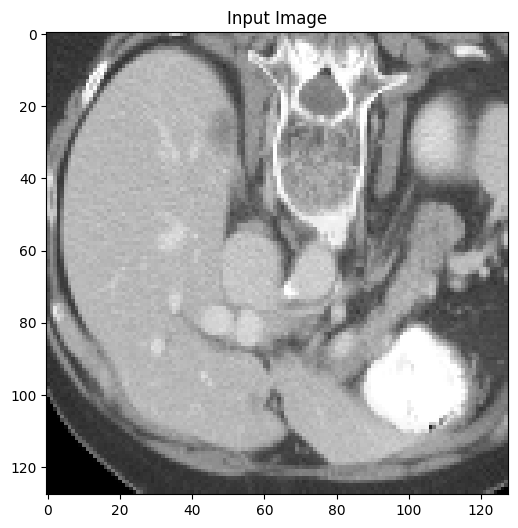

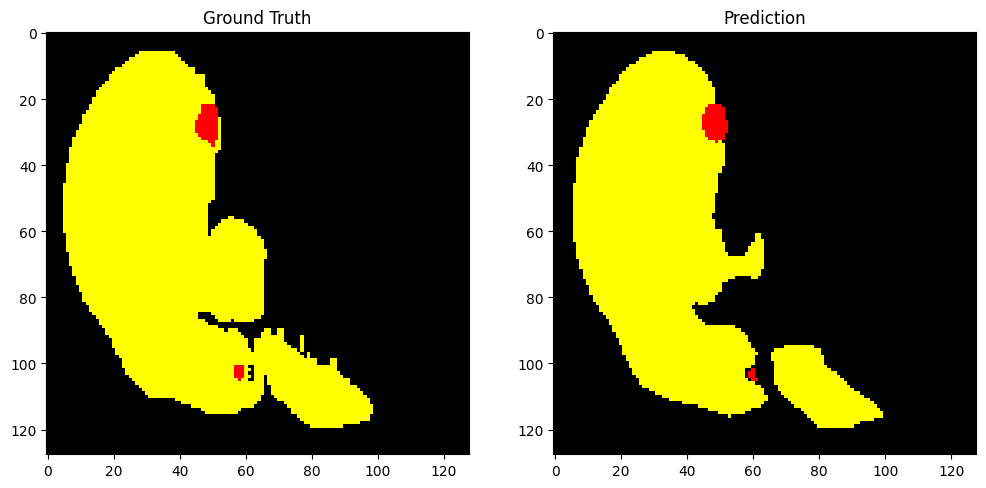

In [20]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth"
visualize_results(model, val_loader, weight_path, num_images, device)